In [1]:
import pandas as pd
import numpy as np
from itertools import product
from tqdm import tqdm
import warnings

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.model_selection import GridSearchCV, train_test_split, KFold, cross_val_score, cross_validate
from sklearn.pipeline import Pipeline, FeatureUnion

from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

from catboost import CatBoostRegressor

from category_encoders import OneHotEncoder, SumEncoder, HelmertEncoder

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
warnings.filterwarnings('ignore')

In [3]:
pd.set_option('display.max.columns', None)

In [4]:
stores = pd.read_csv('store.csv')
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')
train_data_prepared = pd.read_csv('train_data.csv')

### Prepare train and test

In [5]:
test_data.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0


#### test has no Customers column

In [6]:
train_data_prepared.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,month,year,day,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Date_index,CompetitionOpenSinceDay,CompetitionOpenSinceDate,qty_days_with_competitor
0,1,5,2015-07-31,5263,555,1,1,NaN,1,7,2015,31,c,basic,1270.0,9.0,2008.0,0,NaN,NaN,NaN,2015-07-31,1,2008-09-01,2524.0
1,2,5,2015-07-31,6064,625,1,1,NaN,1,7,2015,31,a,basic,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",2015-07-31,1,2007-11-01,2829.0
2,3,5,2015-07-31,8314,821,1,1,NaN,1,7,2015,31,a,basic,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",2015-07-31,1,2006-12-01,3164.0
3,4,5,2015-07-31,13995,1498,1,1,NaN,1,7,2015,31,c,extended,620.0,9.0,2009.0,0,NaN,NaN,NaN,2015-07-31,1,2009-09-01,2159.0
4,5,5,2015-07-31,4822,559,1,1,NaN,1,7,2015,31,a,basic,29910.0,4.0,2015.0,0,NaN,NaN,NaN,2015-07-31,1,2015-04-01,121.0


In [7]:
stores['CompetitionDistance'] = stores['CompetitionDistance'].fillna(0)

In [8]:
ASSORTMENT_MAPPING = {'a': 'basic', 'b': 'extra', 'c': 'extended'}
STATE_HOLIDAYS_MAPPING = {'a': 'public holiday', 'b': 'Easter holiday', 'c': 'Christmas', '0': None}

In [9]:
stores['Assortment'] = stores.Assortment.astype(str).map(ASSORTMENT_MAPPING)

In [10]:
test_data.head(1)

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0


In [11]:
test_data.shape, test_data.Store.nunique()

((41088, 8), 856)

In [12]:
STORES_IN_BOTH = list(set(train_data.Store) & set(test_data.Store))

In [13]:
len(STORES_IN_BOTH)

856

In [14]:
test_data['Date'] = pd.to_datetime(test_data['Date']).dt.date

test_data['month'] = pd.to_datetime(test_data.Date).dt.month
test_data['year'] = pd.to_datetime(test_data.Date).dt.year
test_data['day'] = pd.to_datetime(test_data.Date).dt.day

test_data['StateHoliday'] = test_data.StateHoliday.astype(str).map(STATE_HOLIDAYS_MAPPING)

In [15]:
test_data = test_data.merge(stores, on='Store', how='left')

In [16]:
test_data['CompetitionOpenSinceDay'] = 1

test_data['CompetitionOpenSinceDate'] = pd.to_datetime(dict(year=test_data.CompetitionOpenSinceYear,
                                                            month=test_data.CompetitionOpenSinceMonth,
                                                            day=test_data.CompetitionOpenSinceDay
                                                            )
                                                       ).dt.date

In [17]:
test_data['qty_days_with_competitor'] = (test_data['Date'] - test_data['CompetitionOpenSinceDate']
                                         ).dt.days.fillna(0)

In [18]:
test_data.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,month,year,day,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,CompetitionOpenSinceDay,CompetitionOpenSinceDate,qty_days_with_competitor
0,1,1,4,2015-09-17,1.0,1,None,0,9,2015,17,c,basic,1270.0,9.0,2008.0,0,NaN,NaN,NaN,1,2008-09-01,2572.0
1,2,3,4,2015-09-17,1.0,1,None,0,9,2015,17,a,basic,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",1,2006-12-01,3212.0
2,3,7,4,2015-09-17,1.0,1,None,0,9,2015,17,a,extended,24000.0,4.0,2013.0,0,NaN,NaN,NaN,1,2013-04-01,899.0
3,4,8,4,2015-09-17,1.0,1,None,0,9,2015,17,a,basic,7520.0,10.0,2014.0,0,NaN,NaN,NaN,1,2014-10-01,351.0
4,5,9,4,2015-09-17,1.0,1,None,0,9,2015,17,a,extended,2030.0,8.0,2000.0,0,NaN,NaN,NaN,1,2000-08-01,5525.0


In [19]:
train_data_prepared.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'month', 'year', 'day', 'StoreType',
       'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval', 'Date_index',
       'CompetitionOpenSinceDay', 'CompetitionOpenSinceDate',
       'qty_days_with_competitor'],
      dtype='object')

In [20]:
train_data_prepared.head(2)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,month,year,day,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Date_index,CompetitionOpenSinceDay,CompetitionOpenSinceDate,qty_days_with_competitor
0,1,5,2015-07-31,5263,555,1,1,NaN,1,7,2015,31,c,basic,1270.0,9.0,2008.0,0,NaN,NaN,NaN,2015-07-31,1,2008-09-01,2524.0
1,2,5,2015-07-31,6064,625,1,1,NaN,1,7,2015,31,a,basic,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",2015-07-31,1,2007-11-01,2829.0


In [21]:
train_data_prepared['StateHoliday'] = train_data_prepared['StateHoliday'].fillna('no_state_holiday')

In [22]:
train_data_prepared['PromoInterval'] = train_data_prepared['PromoInterval'].fillna('no_promo')

In [23]:
for col in train_data_prepared.columns:
    print(f'{col} has nans: {train_data_prepared[col].hasnans}')

Store has nans: False
DayOfWeek has nans: False
Date has nans: False
Sales has nans: False
Customers has nans: False
Open has nans: False
Promo has nans: False
StateHoliday has nans: False
SchoolHoliday has nans: False
month has nans: False
year has nans: False
day has nans: False
StoreType has nans: False
Assortment has nans: False
CompetitionDistance has nans: False
CompetitionOpenSinceMonth has nans: True
CompetitionOpenSinceYear has nans: True
Promo2 has nans: False
Promo2SinceWeek has nans: True
Promo2SinceYear has nans: True
PromoInterval has nans: False
Date_index has nans: False
CompetitionOpenSinceDay has nans: False
CompetitionOpenSinceDate has nans: True
qty_days_with_competitor has nans: False


In [24]:
for col in test_data.columns:
    print(f'{col} has nans: {test_data[col].hasnans}')

Id has nans: False
Store has nans: False
DayOfWeek has nans: False
Date has nans: False
Open has nans: True
Promo has nans: False
StateHoliday has nans: True
SchoolHoliday has nans: False
month has nans: False
year has nans: False
day has nans: False
StoreType has nans: False
Assortment has nans: False
CompetitionDistance has nans: False
CompetitionOpenSinceMonth has nans: True
CompetitionOpenSinceYear has nans: True
Promo2 has nans: False
Promo2SinceWeek has nans: True
Promo2SinceYear has nans: True
PromoInterval has nans: True
CompetitionOpenSinceDay has nans: False
CompetitionOpenSinceDate has nans: True
qty_days_with_competitor has nans: False


In [25]:
test_data['StateHoliday'] = test_data['StateHoliday'].fillna('no_state_holiday')

test_data['PromoInterval'] = test_data['PromoInterval'].fillna('no_promo')

In [26]:
train_data_prepared_dropped = train_data_prepared[train_data_prepared.Store.isin(test_data.Store)]

In [27]:
train_data_prepared_dropped.shape

(773231, 25)

# Models

## Predict Sales with and without customers

In [28]:
train_data_prepared_dropped.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,month,year,day,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Date_index,CompetitionOpenSinceDay,CompetitionOpenSinceDate,qty_days_with_competitor
0,1,5,2015-07-31,5263,555,1,1,no_state_holiday,1,7,2015,31,c,basic,1270.0,9.0,2008.0,0,NaN,NaN,no_promo,2015-07-31,1,2008-09-01,2524.0
2,3,5,2015-07-31,8314,821,1,1,no_state_holiday,1,7,2015,31,a,basic,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",2015-07-31,1,2006-12-01,3164.0
6,7,5,2015-07-31,15344,1414,1,1,no_state_holiday,1,7,2015,31,a,extended,24000.0,4.0,2013.0,0,NaN,NaN,no_promo,2015-07-31,1,2013-04-01,851.0
7,8,5,2015-07-31,8492,833,1,1,no_state_holiday,1,7,2015,31,a,basic,7520.0,10.0,2014.0,0,NaN,NaN,no_promo,2015-07-31,1,2014-10-01,303.0
8,9,5,2015-07-31,8565,687,1,1,no_state_holiday,1,7,2015,31,a,extended,2030.0,8.0,2000.0,0,NaN,NaN,no_promo,2015-07-31,1,2000-08-01,5477.0


In [29]:
train_data_prepared_dropped['Sales_logged'] = np.log(train_data_prepared_dropped['Sales'])
train_data_prepared_dropped['Customers_logged'] = np.log(train_data_prepared_dropped['Customers'])

In [30]:
train_data_prepared_dropped.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'month', 'year', 'day', 'StoreType',
       'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval', 'Date_index',
       'CompetitionOpenSinceDay', 'CompetitionOpenSinceDate',
       'qty_days_with_competitor', 'Sales_logged', 'Customers_logged'],
      dtype='object')

In [31]:
train_data_prepared_dropped.head(3)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,month,year,day,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Date_index,CompetitionOpenSinceDay,CompetitionOpenSinceDate,qty_days_with_competitor,Sales_logged,Customers_logged
0,1,5,2015-07-31,5263,555,1,1,no_state_holiday,1,7,2015,31,c,basic,1270.0,9.0,2008.0,0,NaN,NaN,no_promo,2015-07-31,1,2008-09-01,2524.0,8.568456,6.318968
2,3,5,2015-07-31,8314,821,1,1,no_state_holiday,1,7,2015,31,a,basic,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",2015-07-31,1,2006-12-01,3164.0,9.025696,6.710523
6,7,5,2015-07-31,15344,1414,1,1,no_state_holiday,1,7,2015,31,a,extended,24000.0,4.0,2013.0,0,NaN,NaN,no_promo,2015-07-31,1,2013-04-01,851.0,9.638480,7.254178


In [32]:
NUMERIC_FEATURES = ['Customers', 'CompetitionDistance', 'qty_days_with_competitor']
NUMERIC_FEATURES_CUSTOMERS = ['CompetitionDistance', 'qty_days_with_competitor']

CATEGORICAL_FEATURES = ['DayOfWeek', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 'month',
                        'year', 'day', 'StoreType','Assortment', 'Promo2', 'PromoInterval']

In [34]:
TRANSFORMERS_NAMES = ['StandardScaler', 'MinMaxScaler', 'RobustScaler']
TRANSFORMERS = [StandardScaler(), MinMaxScaler(), RobustScaler()]
TRANSFORMERS_MAPPING = dict(zip(TRANSFORMERS_NAMES, TRANSFORMERS))

ENCODERS_NAMES = ['OneHotEncoder', 'HelmertEncoder', 'SumEncoder']
ENCODERS = [OneHotEncoder(cols=CATEGORICAL_FEATURES),
            HelmertEncoder(cols=CATEGORICAL_FEATURES),
            SumEncoder(cols=CATEGORICAL_FEATURES)
           ]
ENCODERS_MAPPING = dict(zip(ENCODERS_NAMES, ENCODERS))

MODELS_NAMES = ['LinearRegression', 'DecisionTreeRegressor', 'GradientBoostingRegressor','CatBoostRegressor']
MODELS = [LinearRegression(), DecisionTreeRegressor(), GradientBoostingRegressor(), CatBoostRegressor()]

MODELS_MAPPING = dict(zip(MODELS_NAMES, MODELS))

In [35]:
METRICS_LIST_NAMES = ['R2', 'MAE', 'MAPE', 'MSE', 'RMSE']
METRICS_LIST = [r2_score, mean_absolute_error, mean_absolute_percentage_error, mean_squared_error,
               lambda true, predict: np.sqrt(mean_squared_error(true, predict))
               ]
METRICS_MAPPING = dict(zip(METRICS_LIST_NAMES, METRICS_LIST))

In [36]:
N_SPLITS = 5

In [37]:
cv = KFold(n_splits=N_SPLITS, shuffle=True, random_state=42)

In [38]:
baseline_metrics_df_features_index = pd.MultiIndex.from_product((list(range(N_SPLITS)), MODELS_NAMES,
                                                                 ['Train', 'Test'], ['True', 'False']))
baseline_metrics_df_features = pd.DataFrame(index=baseline_metrics_df_features_index,
                                           columns=METRICS_LIST_NAMES)

baseline_metrics_df_features.index.names = ['split_number', 'model', 'split', 'with_customers']

In [39]:
baseline_metrics_df_features.head()

R2  MAE MAPE  MSE  \
split_number model                 split with_customers                       
0            LinearRegression      Train True            NaN  NaN  NaN  NaN   
                                         False           NaN  NaN  NaN  NaN   
                                   Test  True            NaN  NaN  NaN  NaN   
                                         False           NaN  NaN  NaN  NaN   
             DecisionTreeRegressor Train True            NaN  NaN  NaN  NaN   

                                                        RMSE  
split_number model                 split with_customers       
0            LinearRegression      Train True            NaN  
                                         False           NaN  
                                   Test  True            NaN  
                                         False           NaN  
             DecisionTreeRegressor Train True            NaN

In [40]:
baseline_transformer = StandardScaler()
baseline_transformer_customers = StandardScaler()
baseline_encoder = SumEncoder(cols=CATEGORICAL_FEATURES)

In [41]:
train_data_prepared_dropped.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,month,year,day,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Date_index,CompetitionOpenSinceDay,CompetitionOpenSinceDate,qty_days_with_competitor,Sales_logged,Customers_logged
0,1,5,2015-07-31,5263,555,1,1,no_state_holiday,1,7,2015,31,c,basic,1270.0,9.0,2008.0,0,NaN,NaN,no_promo,2015-07-31,1,2008-09-01,2524.0,8.568456,6.318968
2,3,5,2015-07-31,8314,821,1,1,no_state_holiday,1,7,2015,31,a,basic,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",2015-07-31,1,2006-12-01,3164.0,9.025696,6.710523
6,7,5,2015-07-31,15344,1414,1,1,no_state_holiday,1,7,2015,31,a,extended,24000.0,4.0,2013.0,0,NaN,NaN,no_promo,2015-07-31,1,2013-04-01,851.0,9.638480,7.254178
7,8,5,2015-07-31,8492,833,1,1,no_state_holiday,1,7,2015,31,a,basic,7520.0,10.0,2014.0,0,NaN,NaN,no_promo,2015-07-31,1,2014-10-01,303.0,9.046880,6.725034
8,9,5,2015-07-31,8565,687,1,1,no_state_holiday,1,7,2015,31,a,extended,2030.0,8.0,2000.0,0,NaN,NaN,no_promo,2015-07-31,1,2000-08-01,5477.0,9.055439,6.532334


In [42]:
train_data_prepared_dropped = train_data_prepared_dropped.reset_index(drop=True)

In [43]:
for col in NUMERIC_FEATURES + CATEGORICAL_FEATURES:
    print(f'{col} has nans: {train_data_prepared_dropped[col].hasnans}')

Customers has nans: False
CompetitionDistance has nans: False
qty_days_with_competitor has nans: False
DayOfWeek has nans: False
Open has nans: False
Promo has nans: False
StateHoliday has nans: False
SchoolHoliday has nans: False
month has nans: False
year has nans: False
day has nans: False
StoreType has nans: False
Assortment has nans: False
Promo2 has nans: False
PromoInterval has nans: False


In [44]:
train_data_prepared_dropped['Sales_logged'] = train_data_prepared_dropped['Sales_logged'].replace(
    to_replace=[-np.inf, np.inf], value=[0, 0])

train_data_prepared_dropped['Customers_logged'] = train_data_prepared_dropped['Customers_logged'].replace(
    to_replace=[-np.inf, np.inf], value=[0, 0])

In [96]:
for split_index, splits in tqdm(enumerate(cv.split(train_data_prepared_dropped))):
    train_indexes, test_indexes = splits

    train_tmp = train_data_prepared_dropped.loc[train_indexes, :]
    test_tmp = train_data_prepared_dropped.loc[test_indexes, :]

    train_transformed_tmp_with_customers = pd.DataFrame(
        baseline_transformer_customers.fit_transform(train_tmp[NUMERIC_FEATURES]), columns=NUMERIC_FEATURES,
        index=train_tmp.index)
    
    train_transformed_tmp_without_customers = pd.DataFrame(
        baseline_transformer.fit_transform(train_tmp[NUMERIC_FEATURES_CUSTOMERS]),
        columns=NUMERIC_FEATURES_CUSTOMERS,
        index=train_tmp.index)

    test_transformed_tmp_with_customers = pd.DataFrame(
        baseline_transformer_customers.transform(test_tmp[NUMERIC_FEATURES]), columns=NUMERIC_FEATURES,
        index=test_tmp.index)
    
    test_transformed_tmp_without_customers = pd.DataFrame(
        baseline_transformer.transform(test_tmp[NUMERIC_FEATURES_CUSTOMERS]),
        columns=NUMERIC_FEATURES_CUSTOMERS,
        index=test_tmp.index)

    train_encoded_tmp = pd.DataFrame(baseline_encoder.fit_transform(
        train_tmp[CATEGORICAL_FEATURES]), columns=CATEGORICAL_FEATURES, index=train_tmp.index
                                    )

    test_encoded_tmp = pd.DataFrame(baseline_encoder.transform(
        test_tmp[CATEGORICAL_FEATURES]), columns=CATEGORICAL_FEATURES, index=test_tmp.index
                                    )

    train_prepared_tmp_with_customers = train_transformed_tmp_with_customers.join(train_encoded_tmp).fillna(0)
    test_prepared_tmp_with_customers = test_transformed_tmp_with_customers.join(test_encoded_tmp).fillna(0)

    train_prepared_tmp_without_customers = train_transformed_tmp_without_customers.join(train_encoded_tmp).fillna(0)
    test_prepared_tmp_without_customers = test_transformed_tmp_without_customers.join(test_encoded_tmp).fillna(0)
    
    
    for data, with_customers, num_features in zip(
        [(train_prepared_tmp_with_customers, test_prepared_tmp_with_customers),
         (train_prepared_tmp_without_customers, test_prepared_tmp_without_customers)],
        ['True', 'False'], [NUMERIC_FEATURES, NUMERIC_FEATURES_CUSTOMERS]
    ):
        train_tmp_df, test_tmp_df = data
        
        for model_name, model in MODELS_MAPPING.items():
        
            model.fit(train_tmp_df[num_features + CATEGORICAL_FEATURES], 
                      train_tmp['Sales_logged']
                     )
            
            train_predictions = model.predict(train_tmp_df[num_features + CATEGORICAL_FEATURES])
            test_predictions = model.predict(test_tmp_df[num_features + CATEGORICAL_FEATURES])

            for metric_name, metric in METRICS_MAPPING.items():
                baseline_metrics_df_features.loc[
                    (split_index, model_name, 'Train', with_customers), metric_name] = metric(
                    train_tmp['Sales_logged'], train_predictions)

                baseline_metrics_df_features.loc[
                    (split_index, model_name, 'Test', with_customers), metric_name] = metric(
                    test_tmp['Sales_logged'], test_predictions)

0it [00:00, ?it/s]

Learning rate set to 0.122538
0:	learn: 2.9016271	total: 193ms	remaining: 3m 13s
1:	learn: 2.5486466	total: 224ms	remaining: 1m 51s
2:	learn: 2.2391382	total: 253ms	remaining: 1m 24s
3:	learn: 1.9680004	total: 280ms	remaining: 1m 9s
4:	learn: 1.7299677	total: 307ms	remaining: 1m 1s
5:	learn: 1.5212770	total: 335ms	remaining: 55.5s
6:	learn: 1.3388115	total: 364ms	remaining: 51.6s
7:	learn: 1.1792535	total: 391ms	remaining: 48.5s
8:	learn: 1.0398323	total: 424ms	remaining: 46.7s
9:	learn: 0.9179145	total: 455ms	remaining: 45.1s
10:	learn: 0.8116318	total: 483ms	remaining: 43.4s
11:	learn: 0.7187869	total: 509ms	remaining: 41.9s
12:	learn: 0.6381910	total: 537ms	remaining: 40.7s
13:	learn: 0.5679960	total: 563ms	remaining: 39.7s
14:	learn: 0.5071986	total: 590ms	remaining: 38.8s
15:	learn: 0.4550005	total: 617ms	remaining: 38s
16:	learn: 0.4099293	total: 653ms	remaining: 37.8s
17:	learn: 0.3713259	total: 688ms	remaining: 37.5s
18:	learn: 0.3384381	total: 714ms	remaining: 36.9s
19:	learn:

166:	learn: 0.1621149	total: 4.81s	remaining: 24s
167:	learn: 0.1619885	total: 4.84s	remaining: 24s
168:	learn: 0.1618194	total: 4.88s	remaining: 24s
169:	learn: 0.1617315	total: 4.91s	remaining: 24s
170:	learn: 0.1616806	total: 4.93s	remaining: 23.9s
171:	learn: 0.1615960	total: 4.96s	remaining: 23.9s
172:	learn: 0.1615418	total: 4.98s	remaining: 23.8s
173:	learn: 0.1614935	total: 5.01s	remaining: 23.8s
174:	learn: 0.1614266	total: 5.04s	remaining: 23.8s
175:	learn: 0.1613491	total: 5.07s	remaining: 23.7s
176:	learn: 0.1612392	total: 5.1s	remaining: 23.7s
177:	learn: 0.1611837	total: 5.12s	remaining: 23.7s
178:	learn: 0.1610678	total: 5.15s	remaining: 23.6s
179:	learn: 0.1609648	total: 5.18s	remaining: 23.6s
180:	learn: 0.1608128	total: 5.21s	remaining: 23.6s
181:	learn: 0.1606670	total: 5.24s	remaining: 23.5s
182:	learn: 0.1604613	total: 5.27s	remaining: 23.5s
183:	learn: 0.1603734	total: 5.3s	remaining: 23.5s
184:	learn: 0.1603330	total: 5.32s	remaining: 23.4s
185:	learn: 0.1602377	

332:	learn: 0.1487061	total: 9.4s	remaining: 18.8s
333:	learn: 0.1486822	total: 9.43s	remaining: 18.8s
334:	learn: 0.1486334	total: 9.45s	remaining: 18.8s
335:	learn: 0.1485658	total: 9.48s	remaining: 18.7s
336:	learn: 0.1485075	total: 9.51s	remaining: 18.7s
337:	learn: 0.1484711	total: 9.54s	remaining: 18.7s
338:	learn: 0.1484305	total: 9.56s	remaining: 18.6s
339:	learn: 0.1483717	total: 9.59s	remaining: 18.6s
340:	learn: 0.1483348	total: 9.62s	remaining: 18.6s
341:	learn: 0.1482657	total: 9.65s	remaining: 18.6s
342:	learn: 0.1482390	total: 9.68s	remaining: 18.5s
343:	learn: 0.1481609	total: 9.7s	remaining: 18.5s
344:	learn: 0.1481163	total: 9.73s	remaining: 18.5s
345:	learn: 0.1480310	total: 9.76s	remaining: 18.4s
346:	learn: 0.1479610	total: 9.78s	remaining: 18.4s
347:	learn: 0.1478608	total: 9.81s	remaining: 18.4s
348:	learn: 0.1478090	total: 9.84s	remaining: 18.4s
349:	learn: 0.1477800	total: 9.87s	remaining: 18.3s
350:	learn: 0.1477424	total: 9.9s	remaining: 18.3s
351:	learn: 0.1

493:	learn: 0.1402695	total: 14s	remaining: 14.3s
494:	learn: 0.1402552	total: 14s	remaining: 14.3s
495:	learn: 0.1401854	total: 14s	remaining: 14.2s
496:	learn: 0.1401458	total: 14.1s	remaining: 14.2s
497:	learn: 0.1401190	total: 14.1s	remaining: 14.2s
498:	learn: 0.1400709	total: 14.1s	remaining: 14.2s
499:	learn: 0.1400085	total: 14.2s	remaining: 14.2s
500:	learn: 0.1399569	total: 14.2s	remaining: 14.2s
501:	learn: 0.1399335	total: 14.2s	remaining: 14.1s
502:	learn: 0.1399108	total: 14.3s	remaining: 14.1s
503:	learn: 0.1398460	total: 14.3s	remaining: 14.1s
504:	learn: 0.1398211	total: 14.3s	remaining: 14.1s
505:	learn: 0.1397814	total: 14.4s	remaining: 14s
506:	learn: 0.1397279	total: 14.4s	remaining: 14s
507:	learn: 0.1397158	total: 14.4s	remaining: 14s
508:	learn: 0.1396842	total: 14.5s	remaining: 13.9s
509:	learn: 0.1396618	total: 14.5s	remaining: 13.9s
510:	learn: 0.1396102	total: 14.5s	remaining: 13.9s
511:	learn: 0.1395466	total: 14.6s	remaining: 13.9s
512:	learn: 0.1395095	to

657:	learn: 0.1342588	total: 19.2s	remaining: 9.98s
658:	learn: 0.1342289	total: 19.2s	remaining: 9.96s
659:	learn: 0.1342074	total: 19.3s	remaining: 9.93s
660:	learn: 0.1341947	total: 19.3s	remaining: 9.89s
661:	learn: 0.1341710	total: 19.3s	remaining: 9.87s
662:	learn: 0.1341558	total: 19.4s	remaining: 9.84s
663:	learn: 0.1341272	total: 19.4s	remaining: 9.81s
664:	learn: 0.1340939	total: 19.4s	remaining: 9.78s
665:	learn: 0.1340487	total: 19.5s	remaining: 9.76s
666:	learn: 0.1339937	total: 19.5s	remaining: 9.73s
667:	learn: 0.1339773	total: 19.5s	remaining: 9.71s
668:	learn: 0.1339633	total: 19.6s	remaining: 9.68s
669:	learn: 0.1339282	total: 19.6s	remaining: 9.65s
670:	learn: 0.1338917	total: 19.6s	remaining: 9.62s
671:	learn: 0.1338262	total: 19.7s	remaining: 9.6s
672:	learn: 0.1338159	total: 19.7s	remaining: 9.56s
673:	learn: 0.1337841	total: 19.7s	remaining: 9.54s
674:	learn: 0.1337610	total: 19.8s	remaining: 9.51s
675:	learn: 0.1337471	total: 19.8s	remaining: 9.48s
676:	learn: 0

818:	learn: 0.1293119	total: 24.2s	remaining: 5.35s
819:	learn: 0.1292809	total: 24.2s	remaining: 5.32s
820:	learn: 0.1292541	total: 24.3s	remaining: 5.29s
821:	learn: 0.1292118	total: 24.3s	remaining: 5.26s
822:	learn: 0.1291778	total: 24.3s	remaining: 5.23s
823:	learn: 0.1291401	total: 24.4s	remaining: 5.2s
824:	learn: 0.1291131	total: 24.4s	remaining: 5.18s
825:	learn: 0.1291051	total: 24.4s	remaining: 5.15s
826:	learn: 0.1290904	total: 24.5s	remaining: 5.12s
827:	learn: 0.1290723	total: 24.5s	remaining: 5.09s
828:	learn: 0.1290547	total: 24.5s	remaining: 5.06s
829:	learn: 0.1290447	total: 24.5s	remaining: 5.03s
830:	learn: 0.1290093	total: 24.6s	remaining: 5s
831:	learn: 0.1289727	total: 24.6s	remaining: 4.97s
832:	learn: 0.1289378	total: 24.6s	remaining: 4.94s
833:	learn: 0.1289016	total: 24.7s	remaining: 4.91s
834:	learn: 0.1288853	total: 24.7s	remaining: 4.88s
835:	learn: 0.1288675	total: 24.7s	remaining: 4.85s
836:	learn: 0.1288144	total: 24.8s	remaining: 4.82s
837:	learn: 0.12

983:	learn: 0.1255901	total: 28.9s	remaining: 470ms
984:	learn: 0.1255696	total: 29s	remaining: 441ms
985:	learn: 0.1255451	total: 29s	remaining: 412ms
986:	learn: 0.1255285	total: 29s	remaining: 382ms
987:	learn: 0.1255115	total: 29s	remaining: 353ms
988:	learn: 0.1254877	total: 29.1s	remaining: 323ms
989:	learn: 0.1254662	total: 29.1s	remaining: 294ms
990:	learn: 0.1254502	total: 29.1s	remaining: 264ms
991:	learn: 0.1254269	total: 29.2s	remaining: 235ms
992:	learn: 0.1253980	total: 29.2s	remaining: 206ms
993:	learn: 0.1253649	total: 29.2s	remaining: 176ms
994:	learn: 0.1253388	total: 29.2s	remaining: 147ms
995:	learn: 0.1253030	total: 29.3s	remaining: 118ms
996:	learn: 0.1252723	total: 29.3s	remaining: 88.2ms
997:	learn: 0.1252399	total: 29.3s	remaining: 58.8ms
998:	learn: 0.1252313	total: 29.3s	remaining: 29.4ms
999:	learn: 0.1251994	total: 29.4s	remaining: 0us
Learning rate set to 0.122538
0:	learn: 3.3039975	total: 30.6ms	remaining: 30.6s
1:	learn: 3.3037909	total: 61.4ms	remainin

145:	learn: 3.2967169	total: 4.25s	remaining: 24.8s
146:	learn: 3.2967072	total: 4.27s	remaining: 24.8s
147:	learn: 3.2966670	total: 4.29s	remaining: 24.7s
148:	learn: 3.2966492	total: 4.32s	remaining: 24.7s
149:	learn: 3.2966355	total: 4.35s	remaining: 24.6s
150:	learn: 3.2966094	total: 4.38s	remaining: 24.6s
151:	learn: 3.2965784	total: 4.41s	remaining: 24.6s
152:	learn: 3.2965452	total: 4.43s	remaining: 24.5s
153:	learn: 3.2964880	total: 4.46s	remaining: 24.5s
154:	learn: 3.2964626	total: 4.48s	remaining: 24.4s
155:	learn: 3.2964305	total: 4.51s	remaining: 24.4s
156:	learn: 3.2964114	total: 4.54s	remaining: 24.4s
157:	learn: 3.2963667	total: 4.56s	remaining: 24.3s
158:	learn: 3.2963495	total: 4.59s	remaining: 24.3s
159:	learn: 3.2963249	total: 4.61s	remaining: 24.2s
160:	learn: 3.2962879	total: 4.64s	remaining: 24.2s
161:	learn: 3.2962186	total: 4.67s	remaining: 24.2s
162:	learn: 3.2961954	total: 4.7s	remaining: 24.1s
163:	learn: 3.2961799	total: 4.72s	remaining: 24.1s
164:	learn: 3

310:	learn: 3.2930164	total: 8.78s	remaining: 19.5s
311:	learn: 3.2929730	total: 8.81s	remaining: 19.4s
312:	learn: 3.2929555	total: 8.84s	remaining: 19.4s
313:	learn: 3.2929462	total: 8.87s	remaining: 19.4s
314:	learn: 3.2929385	total: 8.89s	remaining: 19.3s
315:	learn: 3.2929260	total: 8.92s	remaining: 19.3s
316:	learn: 3.2929178	total: 8.95s	remaining: 19.3s
317:	learn: 3.2929062	total: 8.97s	remaining: 19.2s
318:	learn: 3.2928851	total: 9.01s	remaining: 19.2s
319:	learn: 3.2928685	total: 9.04s	remaining: 19.2s
320:	learn: 3.2928570	total: 9.07s	remaining: 19.2s
321:	learn: 3.2928442	total: 9.11s	remaining: 19.2s
322:	learn: 3.2928361	total: 9.13s	remaining: 19.1s
323:	learn: 3.2928238	total: 9.16s	remaining: 19.1s
324:	learn: 3.2928149	total: 9.19s	remaining: 19.1s
325:	learn: 3.2927917	total: 9.21s	remaining: 19.1s
326:	learn: 3.2927834	total: 9.24s	remaining: 19s
327:	learn: 3.2927780	total: 9.26s	remaining: 19s
328:	learn: 3.2927628	total: 9.29s	remaining: 18.9s
329:	learn: 3.29

471:	learn: 3.2910194	total: 13.3s	remaining: 14.9s
472:	learn: 3.2910169	total: 13.3s	remaining: 14.8s
473:	learn: 3.2910076	total: 13.3s	remaining: 14.8s
474:	learn: 3.2910001	total: 13.4s	remaining: 14.8s
475:	learn: 3.2909960	total: 13.4s	remaining: 14.7s
476:	learn: 3.2909904	total: 13.4s	remaining: 14.7s
477:	learn: 3.2909786	total: 13.4s	remaining: 14.7s
478:	learn: 3.2909659	total: 13.5s	remaining: 14.6s
479:	learn: 3.2909570	total: 13.5s	remaining: 14.6s
480:	learn: 3.2909513	total: 13.5s	remaining: 14.6s
481:	learn: 3.2909452	total: 13.5s	remaining: 14.6s
482:	learn: 3.2909286	total: 13.6s	remaining: 14.5s
483:	learn: 3.2909141	total: 13.6s	remaining: 14.5s
484:	learn: 3.2909027	total: 13.6s	remaining: 14.5s
485:	learn: 3.2908990	total: 13.7s	remaining: 14.4s
486:	learn: 3.2908927	total: 13.7s	remaining: 14.4s
487:	learn: 3.2908865	total: 13.7s	remaining: 14.4s
488:	learn: 3.2908799	total: 13.7s	remaining: 14.4s
489:	learn: 3.2908732	total: 13.8s	remaining: 14.3s
490:	learn: 

635:	learn: 3.2896321	total: 17.8s	remaining: 10.2s
636:	learn: 3.2896230	total: 17.8s	remaining: 10.2s
637:	learn: 3.2896173	total: 17.9s	remaining: 10.1s
638:	learn: 3.2896080	total: 17.9s	remaining: 10.1s
639:	learn: 3.2896049	total: 17.9s	remaining: 10.1s
640:	learn: 3.2896033	total: 17.9s	remaining: 10s
641:	learn: 3.2896003	total: 18s	remaining: 10s
642:	learn: 3.2895891	total: 18s	remaining: 9.99s
643:	learn: 3.2895855	total: 18s	remaining: 9.96s
644:	learn: 3.2895764	total: 18.1s	remaining: 9.93s
645:	learn: 3.2895691	total: 18.1s	remaining: 9.91s
646:	learn: 3.2895619	total: 18.1s	remaining: 9.88s
647:	learn: 3.2895593	total: 18.1s	remaining: 9.85s
648:	learn: 3.2895473	total: 18.2s	remaining: 9.82s
649:	learn: 3.2895366	total: 18.2s	remaining: 9.79s
650:	learn: 3.2895200	total: 18.2s	remaining: 9.77s
651:	learn: 3.2895088	total: 18.2s	remaining: 9.74s
652:	learn: 3.2895028	total: 18.3s	remaining: 9.71s
653:	learn: 3.2894985	total: 18.3s	remaining: 9.68s
654:	learn: 3.2894914	

801:	learn: 3.2885026	total: 22.3s	remaining: 5.5s
802:	learn: 3.2885009	total: 22.3s	remaining: 5.48s
803:	learn: 3.2884966	total: 22.3s	remaining: 5.45s
804:	learn: 3.2884918	total: 22.4s	remaining: 5.42s
805:	learn: 3.2884855	total: 22.4s	remaining: 5.39s
806:	learn: 3.2884815	total: 22.4s	remaining: 5.36s
807:	learn: 3.2884720	total: 22.5s	remaining: 5.33s
808:	learn: 3.2884690	total: 22.5s	remaining: 5.31s
809:	learn: 3.2884614	total: 22.5s	remaining: 5.28s
810:	learn: 3.2884577	total: 22.5s	remaining: 5.25s
811:	learn: 3.2884525	total: 22.6s	remaining: 5.22s
812:	learn: 3.2884432	total: 22.6s	remaining: 5.2s
813:	learn: 3.2884387	total: 22.6s	remaining: 5.17s
814:	learn: 3.2884319	total: 22.6s	remaining: 5.14s
815:	learn: 3.2884257	total: 22.7s	remaining: 5.11s
816:	learn: 3.2884166	total: 22.7s	remaining: 5.09s
817:	learn: 3.2884117	total: 22.7s	remaining: 5.06s
818:	learn: 3.2884069	total: 22.8s	remaining: 5.03s
819:	learn: 3.2884014	total: 22.8s	remaining: 5s
820:	learn: 3.288

965:	learn: 3.2876606	total: 26.8s	remaining: 943ms
966:	learn: 3.2876578	total: 26.8s	remaining: 915ms
967:	learn: 3.2876542	total: 26.8s	remaining: 888ms
968:	learn: 3.2876492	total: 26.9s	remaining: 860ms
969:	learn: 3.2876461	total: 26.9s	remaining: 832ms
970:	learn: 3.2876398	total: 26.9s	remaining: 804ms
971:	learn: 3.2876381	total: 27s	remaining: 776ms
972:	learn: 3.2876338	total: 27s	remaining: 749ms
973:	learn: 3.2876311	total: 27s	remaining: 721ms
974:	learn: 3.2876262	total: 27s	remaining: 693ms
975:	learn: 3.2876240	total: 27.1s	remaining: 666ms
976:	learn: 3.2876110	total: 27.1s	remaining: 638ms
977:	learn: 3.2876064	total: 27.1s	remaining: 610ms
978:	learn: 3.2876028	total: 27.2s	remaining: 583ms
979:	learn: 3.2876011	total: 27.2s	remaining: 555ms
980:	learn: 3.2875981	total: 27.2s	remaining: 527ms
981:	learn: 3.2875927	total: 27.2s	remaining: 499ms
982:	learn: 3.2875869	total: 27.3s	remaining: 472ms
983:	learn: 3.2875851	total: 27.3s	remaining: 444ms
984:	learn: 3.287581

1it [04:56, 296.67s/it]

Learning rate set to 0.122538
0:	learn: 2.9030400	total: 26.9ms	remaining: 26.9s
1:	learn: 2.5498683	total: 53.2ms	remaining: 26.6s
2:	learn: 2.2401882	total: 85.2ms	remaining: 28.3s
3:	learn: 1.9693437	total: 114ms	remaining: 28.5s
4:	learn: 1.7311082	total: 142ms	remaining: 28.2s
5:	learn: 1.5222598	total: 173ms	remaining: 28.6s
6:	learn: 1.3396641	total: 200ms	remaining: 28.4s
7:	learn: 1.1797231	total: 228ms	remaining: 28.3s
8:	learn: 1.0402140	total: 254ms	remaining: 28s
9:	learn: 0.9181978	total: 282ms	remaining: 27.9s
10:	learn: 0.8118375	total: 309ms	remaining: 27.8s
11:	learn: 0.7189317	total: 336ms	remaining: 27.6s
12:	learn: 0.6382557	total: 363ms	remaining: 27.6s
13:	learn: 0.5679870	total: 393ms	remaining: 27.7s
14:	learn: 0.5070817	total: 420ms	remaining: 27.6s
15:	learn: 0.4547852	total: 447ms	remaining: 27.5s
16:	learn: 0.4096900	total: 473ms	remaining: 27.4s
17:	learn: 0.3711238	total: 501ms	remaining: 27.3s
18:	learn: 0.3382218	total: 528ms	remaining: 27.3s
19:	learn:

164:	learn: 0.1617433	total: 4.44s	remaining: 22.5s
165:	learn: 0.1616123	total: 4.47s	remaining: 22.5s
166:	learn: 0.1614502	total: 4.5s	remaining: 22.4s
167:	learn: 0.1612650	total: 4.53s	remaining: 22.4s
168:	learn: 0.1611086	total: 4.55s	remaining: 22.4s
169:	learn: 0.1609572	total: 4.58s	remaining: 22.4s
170:	learn: 0.1608663	total: 4.61s	remaining: 22.3s
171:	learn: 0.1607708	total: 4.63s	remaining: 22.3s
172:	learn: 0.1606624	total: 4.66s	remaining: 22.3s
173:	learn: 0.1605410	total: 4.68s	remaining: 22.2s
174:	learn: 0.1604481	total: 4.71s	remaining: 22.2s
175:	learn: 0.1603803	total: 4.74s	remaining: 22.2s
176:	learn: 0.1602164	total: 4.76s	remaining: 22.2s
177:	learn: 0.1600606	total: 4.79s	remaining: 22.1s
178:	learn: 0.1600069	total: 4.82s	remaining: 22.1s
179:	learn: 0.1599239	total: 4.84s	remaining: 22.1s
180:	learn: 0.1598348	total: 4.87s	remaining: 22s
181:	learn: 0.1597529	total: 4.9s	remaining: 22s
182:	learn: 0.1596834	total: 4.92s	remaining: 22s
183:	learn: 0.159633

325:	learn: 0.1478835	total: 9.41s	remaining: 19.5s
326:	learn: 0.1478550	total: 9.45s	remaining: 19.4s
327:	learn: 0.1477817	total: 9.48s	remaining: 19.4s
328:	learn: 0.1477167	total: 9.51s	remaining: 19.4s
329:	learn: 0.1476079	total: 9.55s	remaining: 19.4s
330:	learn: 0.1475632	total: 9.57s	remaining: 19.4s
331:	learn: 0.1474531	total: 9.6s	remaining: 19.3s
332:	learn: 0.1474199	total: 9.64s	remaining: 19.3s
333:	learn: 0.1473597	total: 9.68s	remaining: 19.3s
334:	learn: 0.1473106	total: 9.72s	remaining: 19.3s
335:	learn: 0.1472671	total: 9.75s	remaining: 19.3s
336:	learn: 0.1472197	total: 9.79s	remaining: 19.3s
337:	learn: 0.1471155	total: 9.83s	remaining: 19.2s
338:	learn: 0.1470213	total: 9.86s	remaining: 19.2s
339:	learn: 0.1469614	total: 9.89s	remaining: 19.2s
340:	learn: 0.1469147	total: 9.91s	remaining: 19.2s
341:	learn: 0.1468361	total: 9.94s	remaining: 19.1s
342:	learn: 0.1467315	total: 9.97s	remaining: 19.1s
343:	learn: 0.1467038	total: 9.99s	remaining: 19.1s
344:	learn: 0

484:	learn: 0.1395111	total: 14.2s	remaining: 15.1s
485:	learn: 0.1394590	total: 14.2s	remaining: 15s
486:	learn: 0.1394145	total: 14.3s	remaining: 15s
487:	learn: 0.1393827	total: 14.3s	remaining: 15s
488:	learn: 0.1393223	total: 14.3s	remaining: 14.9s
489:	learn: 0.1392261	total: 14.3s	remaining: 14.9s
490:	learn: 0.1391792	total: 14.4s	remaining: 14.9s
491:	learn: 0.1391191	total: 14.4s	remaining: 14.9s
492:	learn: 0.1390789	total: 14.4s	remaining: 14.8s
493:	learn: 0.1390334	total: 14.4s	remaining: 14.8s
494:	learn: 0.1390006	total: 14.5s	remaining: 14.8s
495:	learn: 0.1389697	total: 14.5s	remaining: 14.7s
496:	learn: 0.1389338	total: 14.5s	remaining: 14.7s
497:	learn: 0.1388829	total: 14.6s	remaining: 14.7s
498:	learn: 0.1388557	total: 14.6s	remaining: 14.6s
499:	learn: 0.1388098	total: 14.6s	remaining: 14.6s
500:	learn: 0.1387795	total: 14.6s	remaining: 14.6s
501:	learn: 0.1387568	total: 14.7s	remaining: 14.5s
502:	learn: 0.1386844	total: 14.7s	remaining: 14.5s
503:	learn: 0.1386

646:	learn: 0.1334814	total: 18.7s	remaining: 10.2s
647:	learn: 0.1334532	total: 18.8s	remaining: 10.2s
648:	learn: 0.1334232	total: 18.8s	remaining: 10.2s
649:	learn: 0.1334096	total: 18.8s	remaining: 10.1s
650:	learn: 0.1334028	total: 18.8s	remaining: 10.1s
651:	learn: 0.1333284	total: 18.9s	remaining: 10.1s
652:	learn: 0.1333120	total: 18.9s	remaining: 10s
653:	learn: 0.1332665	total: 18.9s	remaining: 10s
654:	learn: 0.1332496	total: 18.9s	remaining: 9.98s
655:	learn: 0.1332326	total: 19s	remaining: 9.95s
656:	learn: 0.1332106	total: 19s	remaining: 9.92s
657:	learn: 0.1331947	total: 19s	remaining: 9.89s
658:	learn: 0.1331604	total: 19.1s	remaining: 9.86s
659:	learn: 0.1330500	total: 19.1s	remaining: 9.84s
660:	learn: 0.1330144	total: 19.1s	remaining: 9.81s
661:	learn: 0.1329856	total: 19.1s	remaining: 9.78s
662:	learn: 0.1329607	total: 19.2s	remaining: 9.75s
663:	learn: 0.1329057	total: 19.2s	remaining: 9.72s
664:	learn: 0.1328858	total: 19.2s	remaining: 9.69s
665:	learn: 0.1328519	

806:	learn: 0.1287706	total: 23.3s	remaining: 5.57s
807:	learn: 0.1287673	total: 23.3s	remaining: 5.54s
808:	learn: 0.1287500	total: 23.3s	remaining: 5.51s
809:	learn: 0.1287296	total: 23.4s	remaining: 5.48s
810:	learn: 0.1287206	total: 23.4s	remaining: 5.45s
811:	learn: 0.1287055	total: 23.4s	remaining: 5.42s
812:	learn: 0.1286941	total: 23.4s	remaining: 5.39s
813:	learn: 0.1286693	total: 23.5s	remaining: 5.36s
814:	learn: 0.1286285	total: 23.5s	remaining: 5.33s
815:	learn: 0.1285987	total: 23.5s	remaining: 5.3s
816:	learn: 0.1285781	total: 23.5s	remaining: 5.27s
817:	learn: 0.1285561	total: 23.6s	remaining: 5.25s
818:	learn: 0.1285389	total: 23.6s	remaining: 5.21s
819:	learn: 0.1284904	total: 23.6s	remaining: 5.19s
820:	learn: 0.1284848	total: 23.7s	remaining: 5.16s
821:	learn: 0.1284360	total: 23.7s	remaining: 5.13s
822:	learn: 0.1283990	total: 23.7s	remaining: 5.1s
823:	learn: 0.1283885	total: 23.7s	remaining: 5.07s
824:	learn: 0.1283816	total: 23.8s	remaining: 5.04s
825:	learn: 0.

971:	learn: 0.1249511	total: 27.8s	remaining: 802ms
972:	learn: 0.1249263	total: 27.9s	remaining: 773ms
973:	learn: 0.1249015	total: 27.9s	remaining: 744ms
974:	learn: 0.1248779	total: 27.9s	remaining: 716ms
975:	learn: 0.1248625	total: 27.9s	remaining: 687ms
976:	learn: 0.1248410	total: 28s	remaining: 658ms
977:	learn: 0.1248281	total: 28s	remaining: 630ms
978:	learn: 0.1248153	total: 28s	remaining: 601ms
979:	learn: 0.1248125	total: 28s	remaining: 572ms
980:	learn: 0.1248053	total: 28.1s	remaining: 544ms
981:	learn: 0.1247877	total: 28.1s	remaining: 515ms
982:	learn: 0.1247688	total: 28.1s	remaining: 487ms
983:	learn: 0.1247541	total: 28.2s	remaining: 458ms
984:	learn: 0.1247479	total: 28.2s	remaining: 429ms
985:	learn: 0.1247191	total: 28.2s	remaining: 401ms
986:	learn: 0.1247020	total: 28.2s	remaining: 372ms
987:	learn: 0.1246912	total: 28.3s	remaining: 343ms
988:	learn: 0.1246372	total: 28.3s	remaining: 315ms
989:	learn: 0.1245958	total: 28.3s	remaining: 286ms
990:	learn: 0.124589

132:	learn: 3.2986172	total: 3.62s	remaining: 23.6s
133:	learn: 3.2985514	total: 3.65s	remaining: 23.6s
134:	learn: 3.2985383	total: 3.67s	remaining: 23.5s
135:	learn: 3.2985234	total: 3.7s	remaining: 23.5s
136:	learn: 3.2985003	total: 3.73s	remaining: 23.5s
137:	learn: 3.2984805	total: 3.76s	remaining: 23.5s
138:	learn: 3.2984656	total: 3.78s	remaining: 23.4s
139:	learn: 3.2984540	total: 3.81s	remaining: 23.4s
140:	learn: 3.2984185	total: 3.84s	remaining: 23.4s
141:	learn: 3.2983985	total: 3.86s	remaining: 23.3s
142:	learn: 3.2983686	total: 3.89s	remaining: 23.3s
143:	learn: 3.2983293	total: 3.91s	remaining: 23.3s
144:	learn: 3.2982965	total: 3.94s	remaining: 23.2s
145:	learn: 3.2982783	total: 3.96s	remaining: 23.2s
146:	learn: 3.2982409	total: 3.99s	remaining: 23.1s
147:	learn: 3.2982288	total: 4.01s	remaining: 23.1s
148:	learn: 3.2981891	total: 4.04s	remaining: 23.1s
149:	learn: 3.2981511	total: 4.07s	remaining: 23.1s
150:	learn: 3.2981249	total: 4.1s	remaining: 23.1s
151:	learn: 3.

297:	learn: 3.2948226	total: 8.58s	remaining: 20.2s
298:	learn: 3.2947305	total: 8.61s	remaining: 20.2s
299:	learn: 3.2947108	total: 8.64s	remaining: 20.2s
300:	learn: 3.2946997	total: 8.66s	remaining: 20.1s
301:	learn: 3.2946668	total: 8.7s	remaining: 20.1s
302:	learn: 3.2946480	total: 8.73s	remaining: 20.1s
303:	learn: 3.2946402	total: 8.75s	remaining: 20s
304:	learn: 3.2946241	total: 8.78s	remaining: 20s
305:	learn: 3.2946052	total: 8.81s	remaining: 20s
306:	learn: 3.2945915	total: 8.84s	remaining: 19.9s
307:	learn: 3.2945774	total: 8.86s	remaining: 19.9s
308:	learn: 3.2945646	total: 8.89s	remaining: 19.9s
309:	learn: 3.2945508	total: 8.91s	remaining: 19.8s
310:	learn: 3.2945410	total: 8.94s	remaining: 19.8s
311:	learn: 3.2945268	total: 8.97s	remaining: 19.8s
312:	learn: 3.2945030	total: 8.99s	remaining: 19.7s
313:	learn: 3.2944988	total: 9.02s	remaining: 19.7s
314:	learn: 3.2944630	total: 9.04s	remaining: 19.7s
315:	learn: 3.2944401	total: 9.07s	remaining: 19.6s
316:	learn: 3.29442

457:	learn: 3.2926488	total: 13.4s	remaining: 15.8s
458:	learn: 3.2926400	total: 13.4s	remaining: 15.8s
459:	learn: 3.2926238	total: 13.4s	remaining: 15.8s
460:	learn: 3.2926146	total: 13.5s	remaining: 15.7s
461:	learn: 3.2926086	total: 13.5s	remaining: 15.7s
462:	learn: 3.2925999	total: 13.5s	remaining: 15.7s
463:	learn: 3.2925918	total: 13.6s	remaining: 15.7s
464:	learn: 3.2925847	total: 13.6s	remaining: 15.7s
465:	learn: 3.2925750	total: 13.6s	remaining: 15.6s
466:	learn: 3.2925547	total: 13.7s	remaining: 15.6s
467:	learn: 3.2925488	total: 13.7s	remaining: 15.6s
468:	learn: 3.2925352	total: 13.7s	remaining: 15.6s
469:	learn: 3.2925198	total: 13.8s	remaining: 15.5s
470:	learn: 3.2925129	total: 13.8s	remaining: 15.5s
471:	learn: 3.2925042	total: 13.8s	remaining: 15.5s
472:	learn: 3.2924964	total: 13.9s	remaining: 15.5s
473:	learn: 3.2924869	total: 13.9s	remaining: 15.4s
474:	learn: 3.2924776	total: 13.9s	remaining: 15.4s
475:	learn: 3.2924660	total: 14s	remaining: 15.4s
476:	learn: 3.

622:	learn: 3.2912041	total: 18.4s	remaining: 11.1s
623:	learn: 3.2911981	total: 18.4s	remaining: 11.1s
624:	learn: 3.2911904	total: 18.4s	remaining: 11s
625:	learn: 3.2911847	total: 18.4s	remaining: 11s
626:	learn: 3.2911814	total: 18.5s	remaining: 11s
627:	learn: 3.2911730	total: 18.5s	remaining: 11s
628:	learn: 3.2911665	total: 18.5s	remaining: 10.9s
629:	learn: 3.2911596	total: 18.5s	remaining: 10.9s
630:	learn: 3.2911561	total: 18.6s	remaining: 10.9s
631:	learn: 3.2911448	total: 18.6s	remaining: 10.8s
632:	learn: 3.2911396	total: 18.6s	remaining: 10.8s
633:	learn: 3.2911338	total: 18.7s	remaining: 10.8s
634:	learn: 3.2911250	total: 18.7s	remaining: 10.7s
635:	learn: 3.2911182	total: 18.7s	remaining: 10.7s
636:	learn: 3.2911121	total: 18.7s	remaining: 10.7s
637:	learn: 3.2911081	total: 18.8s	remaining: 10.7s
638:	learn: 3.2911040	total: 18.8s	remaining: 10.6s
639:	learn: 3.2910955	total: 18.8s	remaining: 10.6s
640:	learn: 3.2910752	total: 18.9s	remaining: 10.6s
641:	learn: 3.291069

787:	learn: 3.2901446	total: 22.9s	remaining: 6.16s
788:	learn: 3.2901410	total: 22.9s	remaining: 6.13s
789:	learn: 3.2901374	total: 22.9s	remaining: 6.1s
790:	learn: 3.2901314	total: 23s	remaining: 6.07s
791:	learn: 3.2901283	total: 23s	remaining: 6.04s
792:	learn: 3.2901224	total: 23s	remaining: 6.01s
793:	learn: 3.2901170	total: 23s	remaining: 5.98s
794:	learn: 3.2901097	total: 23.1s	remaining: 5.95s
795:	learn: 3.2901048	total: 23.1s	remaining: 5.92s
796:	learn: 3.2900959	total: 23.1s	remaining: 5.89s
797:	learn: 3.2900914	total: 23.2s	remaining: 5.86s
798:	learn: 3.2900849	total: 23.2s	remaining: 5.83s
799:	learn: 3.2900811	total: 23.2s	remaining: 5.8s
800:	learn: 3.2900774	total: 23.2s	remaining: 5.77s
801:	learn: 3.2900750	total: 23.3s	remaining: 5.74s
802:	learn: 3.2900668	total: 23.3s	remaining: 5.71s
803:	learn: 3.2900607	total: 23.3s	remaining: 5.69s
804:	learn: 3.2900510	total: 23.4s	remaining: 5.66s
805:	learn: 3.2900455	total: 23.4s	remaining: 5.63s
806:	learn: 3.2900386	

951:	learn: 3.2892647	total: 27.4s	remaining: 1.38s
952:	learn: 3.2892578	total: 27.5s	remaining: 1.35s
953:	learn: 3.2892551	total: 27.5s	remaining: 1.32s
954:	learn: 3.2892511	total: 27.5s	remaining: 1.3s
955:	learn: 3.2892454	total: 27.5s	remaining: 1.27s
956:	learn: 3.2892401	total: 27.6s	remaining: 1.24s
957:	learn: 3.2892350	total: 27.6s	remaining: 1.21s
958:	learn: 3.2892292	total: 27.6s	remaining: 1.18s
959:	learn: 3.2892231	total: 27.7s	remaining: 1.15s
960:	learn: 3.2892211	total: 27.7s	remaining: 1.12s
961:	learn: 3.2892152	total: 27.7s	remaining: 1.09s
962:	learn: 3.2892081	total: 27.7s	remaining: 1.06s
963:	learn: 3.2892022	total: 27.8s	remaining: 1.04s
964:	learn: 3.2891944	total: 27.8s	remaining: 1.01s
965:	learn: 3.2891918	total: 27.8s	remaining: 979ms
966:	learn: 3.2891831	total: 27.8s	remaining: 950ms
967:	learn: 3.2891797	total: 27.9s	remaining: 921ms
968:	learn: 3.2891754	total: 27.9s	remaining: 893ms
969:	learn: 3.2891702	total: 27.9s	remaining: 864ms
970:	learn: 3

2it [09:53, 296.77s/it]

Learning rate set to 0.122538
0:	learn: 2.9059322	total: 28.4ms	remaining: 28.4s
1:	learn: 2.5524386	total: 57.2ms	remaining: 28.6s
2:	learn: 2.2424486	total: 84.2ms	remaining: 28s
3:	learn: 1.9708855	total: 111ms	remaining: 27.5s
4:	learn: 1.7324722	total: 138ms	remaining: 27.4s
5:	learn: 1.5234929	total: 167ms	remaining: 27.6s
6:	learn: 1.3407540	total: 195ms	remaining: 27.7s
7:	learn: 1.1809468	total: 224ms	remaining: 27.7s
8:	learn: 1.0413279	total: 251ms	remaining: 27.7s
9:	learn: 0.9191974	total: 283ms	remaining: 28s
10:	learn: 0.8127630	total: 312ms	remaining: 28s
11:	learn: 0.7197145	total: 343ms	remaining: 28.3s
12:	learn: 0.6388439	total: 372ms	remaining: 28.2s
13:	learn: 0.5684033	total: 428ms	remaining: 30.1s
14:	learn: 0.5074448	total: 459ms	remaining: 30.1s
15:	learn: 0.4552216	total: 484ms	remaining: 29.8s
16:	learn: 0.4100903	total: 511ms	remaining: 29.6s
17:	learn: 0.3714804	total: 539ms	remaining: 29.4s
18:	learn: 0.3385941	total: 566ms	remaining: 29.2s
19:	learn: 0.3

167:	learn: 0.1612563	total: 4.75s	remaining: 23.6s
168:	learn: 0.1611355	total: 4.79s	remaining: 23.5s
169:	learn: 0.1610048	total: 4.81s	remaining: 23.5s
170:	learn: 0.1608942	total: 4.85s	remaining: 23.5s
171:	learn: 0.1608119	total: 4.88s	remaining: 23.5s
172:	learn: 0.1607035	total: 4.9s	remaining: 23.4s
173:	learn: 0.1605506	total: 4.93s	remaining: 23.4s
174:	learn: 0.1604656	total: 4.96s	remaining: 23.4s
175:	learn: 0.1604019	total: 4.99s	remaining: 23.3s
176:	learn: 0.1603237	total: 5.01s	remaining: 23.3s
177:	learn: 0.1602435	total: 5.04s	remaining: 23.3s
178:	learn: 0.1601782	total: 5.07s	remaining: 23.2s
179:	learn: 0.1600990	total: 5.09s	remaining: 23.2s
180:	learn: 0.1599842	total: 5.12s	remaining: 23.2s
181:	learn: 0.1598327	total: 5.15s	remaining: 23.2s
182:	learn: 0.1597278	total: 5.18s	remaining: 23.1s
183:	learn: 0.1596451	total: 5.21s	remaining: 23.1s
184:	learn: 0.1595921	total: 5.24s	remaining: 23.1s
185:	learn: 0.1594987	total: 5.26s	remaining: 23s
186:	learn: 0.1

330:	learn: 0.1477174	total: 9.51s	remaining: 19.2s
331:	learn: 0.1476059	total: 9.54s	remaining: 19.2s
332:	learn: 0.1475369	total: 9.57s	remaining: 19.2s
333:	learn: 0.1474597	total: 9.6s	remaining: 19.1s
334:	learn: 0.1474063	total: 9.63s	remaining: 19.1s
335:	learn: 0.1473081	total: 9.67s	remaining: 19.1s
336:	learn: 0.1472667	total: 9.7s	remaining: 19.1s
337:	learn: 0.1472279	total: 9.74s	remaining: 19.1s
338:	learn: 0.1471869	total: 9.77s	remaining: 19.1s
339:	learn: 0.1471016	total: 9.81s	remaining: 19s
340:	learn: 0.1470443	total: 9.84s	remaining: 19s
341:	learn: 0.1469408	total: 9.87s	remaining: 19s
342:	learn: 0.1468031	total: 9.9s	remaining: 19s
343:	learn: 0.1467270	total: 9.94s	remaining: 19s
344:	learn: 0.1466654	total: 9.97s	remaining: 18.9s
345:	learn: 0.1465894	total: 10s	remaining: 18.9s
346:	learn: 0.1464950	total: 10s	remaining: 18.9s
347:	learn: 0.1464439	total: 10.1s	remaining: 18.9s
348:	learn: 0.1463201	total: 10.1s	remaining: 18.8s
349:	learn: 0.1462603	total: 

496:	learn: 0.1386578	total: 14.2s	remaining: 14.4s
497:	learn: 0.1385833	total: 14.3s	remaining: 14.4s
498:	learn: 0.1385295	total: 14.3s	remaining: 14.3s
499:	learn: 0.1384604	total: 14.3s	remaining: 14.3s
500:	learn: 0.1383936	total: 14.3s	remaining: 14.3s
501:	learn: 0.1383764	total: 14.4s	remaining: 14.3s
502:	learn: 0.1383537	total: 14.4s	remaining: 14.2s
503:	learn: 0.1382472	total: 14.4s	remaining: 14.2s
504:	learn: 0.1382069	total: 14.4s	remaining: 14.2s
505:	learn: 0.1381679	total: 14.5s	remaining: 14.1s
506:	learn: 0.1381168	total: 14.5s	remaining: 14.1s
507:	learn: 0.1380418	total: 14.5s	remaining: 14.1s
508:	learn: 0.1380038	total: 14.6s	remaining: 14s
509:	learn: 0.1379467	total: 14.6s	remaining: 14s
510:	learn: 0.1378969	total: 14.6s	remaining: 14s
511:	learn: 0.1378707	total: 14.6s	remaining: 13.9s
512:	learn: 0.1378192	total: 14.7s	remaining: 13.9s
513:	learn: 0.1377953	total: 14.7s	remaining: 13.9s
514:	learn: 0.1377541	total: 14.7s	remaining: 13.9s
515:	learn: 0.1377

661:	learn: 0.1321849	total: 18.8s	remaining: 9.61s
662:	learn: 0.1321372	total: 18.8s	remaining: 9.58s
663:	learn: 0.1320390	total: 18.9s	remaining: 9.55s
664:	learn: 0.1320307	total: 18.9s	remaining: 9.52s
665:	learn: 0.1319808	total: 18.9s	remaining: 9.49s
666:	learn: 0.1319416	total: 18.9s	remaining: 9.46s
667:	learn: 0.1319175	total: 19s	remaining: 9.43s
668:	learn: 0.1318749	total: 19s	remaining: 9.4s
669:	learn: 0.1318385	total: 19s	remaining: 9.37s
670:	learn: 0.1318186	total: 19.1s	remaining: 9.34s
671:	learn: 0.1317759	total: 19.1s	remaining: 9.31s
672:	learn: 0.1317651	total: 19.1s	remaining: 9.28s
673:	learn: 0.1317306	total: 19.1s	remaining: 9.26s
674:	learn: 0.1316956	total: 19.2s	remaining: 9.22s
675:	learn: 0.1316486	total: 19.2s	remaining: 9.2s
676:	learn: 0.1316267	total: 19.2s	remaining: 9.17s
677:	learn: 0.1316182	total: 19.2s	remaining: 9.14s
678:	learn: 0.1316127	total: 19.3s	remaining: 9.11s
679:	learn: 0.1315789	total: 19.3s	remaining: 9.08s
680:	learn: 0.131536

826:	learn: 0.1274794	total: 23.4s	remaining: 4.9s
827:	learn: 0.1274369	total: 23.4s	remaining: 4.87s
828:	learn: 0.1273770	total: 23.5s	remaining: 4.84s
829:	learn: 0.1273399	total: 23.5s	remaining: 4.81s
830:	learn: 0.1273283	total: 23.5s	remaining: 4.79s
831:	learn: 0.1273039	total: 23.6s	remaining: 4.76s
832:	learn: 0.1272972	total: 23.6s	remaining: 4.73s
833:	learn: 0.1272569	total: 23.6s	remaining: 4.7s
834:	learn: 0.1272428	total: 23.6s	remaining: 4.67s
835:	learn: 0.1272228	total: 23.7s	remaining: 4.64s
836:	learn: 0.1271793	total: 23.7s	remaining: 4.62s
837:	learn: 0.1271456	total: 23.7s	remaining: 4.59s
838:	learn: 0.1271331	total: 23.8s	remaining: 4.56s
839:	learn: 0.1271214	total: 23.8s	remaining: 4.53s
840:	learn: 0.1270890	total: 23.8s	remaining: 4.5s
841:	learn: 0.1270703	total: 23.8s	remaining: 4.47s
842:	learn: 0.1270611	total: 23.9s	remaining: 4.44s
843:	learn: 0.1270301	total: 23.9s	remaining: 4.42s
844:	learn: 0.1270007	total: 23.9s	remaining: 4.39s
845:	learn: 0.1

991:	learn: 0.1236913	total: 28.2s	remaining: 227ms
992:	learn: 0.1236816	total: 28.2s	remaining: 199ms
993:	learn: 0.1236694	total: 28.2s	remaining: 170ms
994:	learn: 0.1236575	total: 28.2s	remaining: 142ms
995:	learn: 0.1236436	total: 28.3s	remaining: 114ms
996:	learn: 0.1236048	total: 28.3s	remaining: 85.2ms
997:	learn: 0.1235928	total: 28.3s	remaining: 56.8ms
998:	learn: 0.1235669	total: 28.4s	remaining: 28.4ms
999:	learn: 0.1235247	total: 28.4s	remaining: 0us
Learning rate set to 0.122538
0:	learn: 3.3088873	total: 27ms	remaining: 27s
1:	learn: 3.3087732	total: 55ms	remaining: 27.4s
2:	learn: 3.3085711	total: 81.4ms	remaining: 27.1s
3:	learn: 3.3085066	total: 108ms	remaining: 26.9s
4:	learn: 3.3083730	total: 135ms	remaining: 26.9s
5:	learn: 3.3079426	total: 169ms	remaining: 28s
6:	learn: 3.3078260	total: 200ms	remaining: 28.4s
7:	learn: 3.3077129	total: 225ms	remaining: 28s
8:	learn: 3.3074230	total: 252ms	remaining: 27.7s
9:	learn: 3.3071536	total: 278ms	remaining: 27.5s
10:	lear

155:	learn: 3.3011094	total: 4.42s	remaining: 23.9s
156:	learn: 3.3010705	total: 4.45s	remaining: 23.9s
157:	learn: 3.3010426	total: 4.48s	remaining: 23.9s
158:	learn: 3.3010295	total: 4.5s	remaining: 23.8s
159:	learn: 3.3010118	total: 4.53s	remaining: 23.8s
160:	learn: 3.3010045	total: 4.55s	remaining: 23.7s
161:	learn: 3.3009735	total: 4.58s	remaining: 23.7s
162:	learn: 3.3009587	total: 4.6s	remaining: 23.6s
163:	learn: 3.3009260	total: 4.63s	remaining: 23.6s
164:	learn: 3.3009075	total: 4.66s	remaining: 23.6s
165:	learn: 3.3008780	total: 4.68s	remaining: 23.5s
166:	learn: 3.3008567	total: 4.71s	remaining: 23.5s
167:	learn: 3.3008378	total: 4.73s	remaining: 23.4s
168:	learn: 3.3008128	total: 4.76s	remaining: 23.4s
169:	learn: 3.3007961	total: 4.78s	remaining: 23.4s
170:	learn: 3.3007854	total: 4.81s	remaining: 23.3s
171:	learn: 3.3007558	total: 4.83s	remaining: 23.3s
172:	learn: 3.3007274	total: 4.86s	remaining: 23.2s
173:	learn: 3.3006834	total: 4.88s	remaining: 23.2s
174:	learn: 3.

319:	learn: 3.2978705	total: 9.32s	remaining: 19.8s
320:	learn: 3.2978572	total: 9.35s	remaining: 19.8s
321:	learn: 3.2978268	total: 9.38s	remaining: 19.7s
322:	learn: 3.2978098	total: 9.41s	remaining: 19.7s
323:	learn: 3.2978039	total: 9.43s	remaining: 19.7s
324:	learn: 3.2977928	total: 9.46s	remaining: 19.6s
325:	learn: 3.2977817	total: 9.48s	remaining: 19.6s
326:	learn: 3.2977695	total: 9.51s	remaining: 19.6s
327:	learn: 3.2977620	total: 9.54s	remaining: 19.5s
328:	learn: 3.2977475	total: 9.57s	remaining: 19.5s
329:	learn: 3.2977178	total: 9.6s	remaining: 19.5s
330:	learn: 3.2976910	total: 9.63s	remaining: 19.5s
331:	learn: 3.2976809	total: 9.66s	remaining: 19.4s
332:	learn: 3.2976714	total: 9.69s	remaining: 19.4s
333:	learn: 3.2976546	total: 9.71s	remaining: 19.4s
334:	learn: 3.2976446	total: 9.74s	remaining: 19.3s
335:	learn: 3.2976185	total: 9.77s	remaining: 19.3s
336:	learn: 3.2976148	total: 9.79s	remaining: 19.3s
337:	learn: 3.2976048	total: 9.82s	remaining: 19.2s
338:	learn: 3

483:	learn: 3.2960894	total: 13.8s	remaining: 14.7s
484:	learn: 3.2960830	total: 13.9s	remaining: 14.7s
485:	learn: 3.2960739	total: 13.9s	remaining: 14.7s
486:	learn: 3.2960654	total: 13.9s	remaining: 14.7s
487:	learn: 3.2960611	total: 13.9s	remaining: 14.6s
488:	learn: 3.2960546	total: 14s	remaining: 14.6s
489:	learn: 3.2960483	total: 14s	remaining: 14.6s
490:	learn: 3.2960390	total: 14s	remaining: 14.5s
491:	learn: 3.2960316	total: 14s	remaining: 14.5s
492:	learn: 3.2960248	total: 14.1s	remaining: 14.5s
493:	learn: 3.2960194	total: 14.1s	remaining: 14.4s
494:	learn: 3.2959836	total: 14.1s	remaining: 14.4s
495:	learn: 3.2959796	total: 14.2s	remaining: 14.4s
496:	learn: 3.2959726	total: 14.2s	remaining: 14.3s
497:	learn: 3.2959673	total: 14.2s	remaining: 14.3s
498:	learn: 3.2959636	total: 14.2s	remaining: 14.3s
499:	learn: 3.2959525	total: 14.3s	remaining: 14.3s
500:	learn: 3.2959404	total: 14.3s	remaining: 14.2s
501:	learn: 3.2959356	total: 14.3s	remaining: 14.2s
502:	learn: 3.295926

648:	learn: 3.2948281	total: 18.3s	remaining: 9.92s
649:	learn: 3.2948216	total: 18.4s	remaining: 9.89s
650:	learn: 3.2948168	total: 18.4s	remaining: 9.86s
651:	learn: 3.2948116	total: 18.4s	remaining: 9.83s
652:	learn: 3.2948056	total: 18.4s	remaining: 9.8s
653:	learn: 3.2947970	total: 18.5s	remaining: 9.77s
654:	learn: 3.2947914	total: 18.5s	remaining: 9.74s
655:	learn: 3.2947867	total: 18.5s	remaining: 9.71s
656:	learn: 3.2947742	total: 18.6s	remaining: 9.69s
657:	learn: 3.2947692	total: 18.6s	remaining: 9.66s
658:	learn: 3.2947665	total: 18.6s	remaining: 9.63s
659:	learn: 3.2947608	total: 18.6s	remaining: 9.6s
660:	learn: 3.2947436	total: 18.7s	remaining: 9.57s
661:	learn: 3.2947397	total: 18.7s	remaining: 9.54s
662:	learn: 3.2947321	total: 18.7s	remaining: 9.51s
663:	learn: 3.2947281	total: 18.7s	remaining: 9.48s
664:	learn: 3.2947245	total: 18.8s	remaining: 9.45s
665:	learn: 3.2947208	total: 18.8s	remaining: 9.42s
666:	learn: 3.2947158	total: 18.8s	remaining: 9.39s
667:	learn: 3.

811:	learn: 3.2938027	total: 22.8s	remaining: 5.28s
812:	learn: 3.2937982	total: 22.9s	remaining: 5.26s
813:	learn: 3.2937959	total: 22.9s	remaining: 5.23s
814:	learn: 3.2937831	total: 22.9s	remaining: 5.2s
815:	learn: 3.2937705	total: 22.9s	remaining: 5.17s
816:	learn: 3.2937665	total: 23s	remaining: 5.14s
817:	learn: 3.2937627	total: 23s	remaining: 5.12s
818:	learn: 3.2937607	total: 23s	remaining: 5.09s
819:	learn: 3.2937560	total: 23s	remaining: 5.06s
820:	learn: 3.2937492	total: 23.1s	remaining: 5.03s
821:	learn: 3.2937394	total: 23.1s	remaining: 5s
822:	learn: 3.2937336	total: 23.1s	remaining: 4.97s
823:	learn: 3.2937306	total: 23.2s	remaining: 4.95s
824:	learn: 3.2937265	total: 23.2s	remaining: 4.92s
825:	learn: 3.2937239	total: 23.2s	remaining: 4.89s
826:	learn: 3.2937214	total: 23.2s	remaining: 4.86s
827:	learn: 3.2937179	total: 23.3s	remaining: 4.83s
828:	learn: 3.2937113	total: 23.3s	remaining: 4.8s
829:	learn: 3.2937086	total: 23.3s	remaining: 4.77s
830:	learn: 3.2937044	tot

976:	learn: 3.2929909	total: 27.4s	remaining: 644ms
977:	learn: 3.2929865	total: 27.4s	remaining: 616ms
978:	learn: 3.2929803	total: 27.4s	remaining: 588ms
979:	learn: 3.2929785	total: 27.4s	remaining: 560ms
980:	learn: 3.2929740	total: 27.5s	remaining: 532ms
981:	learn: 3.2929715	total: 27.5s	remaining: 504ms
982:	learn: 3.2929672	total: 27.5s	remaining: 476ms
983:	learn: 3.2929618	total: 27.5s	remaining: 448ms
984:	learn: 3.2929569	total: 27.6s	remaining: 420ms
985:	learn: 3.2929528	total: 27.6s	remaining: 392ms
986:	learn: 3.2929495	total: 27.6s	remaining: 364ms
987:	learn: 3.2929468	total: 27.7s	remaining: 336ms
988:	learn: 3.2929424	total: 27.7s	remaining: 308ms
989:	learn: 3.2929394	total: 27.7s	remaining: 280ms
990:	learn: 3.2929353	total: 27.7s	remaining: 252ms
991:	learn: 3.2929309	total: 27.8s	remaining: 224ms
992:	learn: 3.2929281	total: 27.8s	remaining: 196ms
993:	learn: 3.2929237	total: 27.8s	remaining: 168ms
994:	learn: 3.2929208	total: 27.8s	remaining: 140ms
995:	learn: 

3it [14:52, 297.69s/it]

Learning rate set to 0.122538
0:	learn: 2.9044825	total: 27.4ms	remaining: 27.3s
1:	learn: 2.5511361	total: 57.8ms	remaining: 28.8s
2:	learn: 2.2413046	total: 87.1ms	remaining: 28.9s
3:	learn: 1.9703436	total: 114ms	remaining: 28.4s
4:	learn: 1.7319946	total: 141ms	remaining: 28s
5:	learn: 1.5230512	total: 172ms	remaining: 28.5s
6:	learn: 1.3403592	total: 205ms	remaining: 29.1s
7:	learn: 1.1804728	total: 244ms	remaining: 30.3s
8:	learn: 1.0409073	total: 292ms	remaining: 32.2s
9:	learn: 0.9187860	total: 330ms	remaining: 32.7s
10:	learn: 0.8123551	total: 369ms	remaining: 33.2s
11:	learn: 0.7194226	total: 404ms	remaining: 33.2s
12:	learn: 0.6385179	total: 438ms	remaining: 33.3s
13:	learn: 0.5680849	total: 475ms	remaining: 33.4s
14:	learn: 0.5072253	total: 507ms	remaining: 33.3s
15:	learn: 0.4548292	total: 535ms	remaining: 32.9s
16:	learn: 0.4097130	total: 568ms	remaining: 32.8s
17:	learn: 0.3710523	total: 596ms	remaining: 32.5s
18:	learn: 0.3380389	total: 624ms	remaining: 32.2s
19:	learn:

163:	learn: 0.1609303	total: 4.89s	remaining: 24.9s
164:	learn: 0.1608033	total: 4.92s	remaining: 24.9s
165:	learn: 0.1607007	total: 4.95s	remaining: 24.8s
166:	learn: 0.1606412	total: 4.97s	remaining: 24.8s
167:	learn: 0.1605891	total: 5s	remaining: 24.7s
168:	learn: 0.1605200	total: 5.02s	remaining: 24.7s
169:	learn: 0.1604351	total: 5.05s	remaining: 24.6s
170:	learn: 0.1603103	total: 5.07s	remaining: 24.6s
171:	learn: 0.1601722	total: 5.1s	remaining: 24.6s
172:	learn: 0.1600044	total: 5.13s	remaining: 24.5s
173:	learn: 0.1599499	total: 5.15s	remaining: 24.5s
174:	learn: 0.1598890	total: 5.19s	remaining: 24.5s
175:	learn: 0.1597747	total: 5.22s	remaining: 24.5s
176:	learn: 0.1596719	total: 5.25s	remaining: 24.4s
177:	learn: 0.1595980	total: 5.28s	remaining: 24.4s
178:	learn: 0.1594959	total: 5.31s	remaining: 24.3s
179:	learn: 0.1593938	total: 5.34s	remaining: 24.3s
180:	learn: 0.1592513	total: 5.37s	remaining: 24.3s
181:	learn: 0.1591581	total: 5.4s	remaining: 24.3s
182:	learn: 0.159

328:	learn: 0.1470426	total: 9.65s	remaining: 19.7s
329:	learn: 0.1470069	total: 9.68s	remaining: 19.7s
330:	learn: 0.1469339	total: 9.71s	remaining: 19.6s
331:	learn: 0.1468576	total: 9.75s	remaining: 19.6s
332:	learn: 0.1467873	total: 9.78s	remaining: 19.6s
333:	learn: 0.1467448	total: 9.81s	remaining: 19.6s
334:	learn: 0.1466881	total: 9.84s	remaining: 19.5s
335:	learn: 0.1466150	total: 9.87s	remaining: 19.5s
336:	learn: 0.1465648	total: 9.9s	remaining: 19.5s
337:	learn: 0.1465275	total: 9.93s	remaining: 19.4s
338:	learn: 0.1463958	total: 9.96s	remaining: 19.4s
339:	learn: 0.1463062	total: 9.99s	remaining: 19.4s
340:	learn: 0.1462351	total: 10s	remaining: 19.4s
341:	learn: 0.1461836	total: 10.1s	remaining: 19.3s
342:	learn: 0.1461225	total: 10.1s	remaining: 19.3s
343:	learn: 0.1460770	total: 10.1s	remaining: 19.3s
344:	learn: 0.1459521	total: 10.2s	remaining: 19.3s
345:	learn: 0.1458891	total: 10.2s	remaining: 19.3s
346:	learn: 0.1458007	total: 10.2s	remaining: 19.3s
347:	learn: 0.1

488:	learn: 0.1386647	total: 14.7s	remaining: 15.3s
489:	learn: 0.1386058	total: 14.7s	remaining: 15.3s
490:	learn: 0.1385772	total: 14.7s	remaining: 15.3s
491:	learn: 0.1385256	total: 14.8s	remaining: 15.3s
492:	learn: 0.1384616	total: 14.8s	remaining: 15.2s
493:	learn: 0.1384377	total: 14.8s	remaining: 15.2s
494:	learn: 0.1383968	total: 14.9s	remaining: 15.2s
495:	learn: 0.1383201	total: 14.9s	remaining: 15.1s
496:	learn: 0.1382897	total: 14.9s	remaining: 15.1s
497:	learn: 0.1382409	total: 15s	remaining: 15.1s
498:	learn: 0.1382166	total: 15s	remaining: 15.1s
499:	learn: 0.1381855	total: 15s	remaining: 15s
500:	learn: 0.1381485	total: 15.1s	remaining: 15s
501:	learn: 0.1381166	total: 15.1s	remaining: 15s
502:	learn: 0.1380917	total: 15.1s	remaining: 14.9s
503:	learn: 0.1380700	total: 15.1s	remaining: 14.9s
504:	learn: 0.1379984	total: 15.2s	remaining: 14.9s
505:	learn: 0.1379534	total: 15.2s	remaining: 14.8s
506:	learn: 0.1379282	total: 15.2s	remaining: 14.8s
507:	learn: 0.1379038	to

650:	learn: 0.1325040	total: 19.7s	remaining: 10.5s
651:	learn: 0.1324944	total: 19.7s	remaining: 10.5s
652:	learn: 0.1324540	total: 19.7s	remaining: 10.5s
653:	learn: 0.1324241	total: 19.7s	remaining: 10.4s
654:	learn: 0.1323880	total: 19.8s	remaining: 10.4s
655:	learn: 0.1323613	total: 19.8s	remaining: 10.4s
656:	learn: 0.1323446	total: 19.8s	remaining: 10.4s
657:	learn: 0.1323064	total: 19.9s	remaining: 10.3s
658:	learn: 0.1322901	total: 19.9s	remaining: 10.3s
659:	learn: 0.1322415	total: 19.9s	remaining: 10.3s
660:	learn: 0.1322202	total: 19.9s	remaining: 10.2s
661:	learn: 0.1321745	total: 20s	remaining: 10.2s
662:	learn: 0.1321337	total: 20s	remaining: 10.2s
663:	learn: 0.1321226	total: 20s	remaining: 10.1s
664:	learn: 0.1320559	total: 20.1s	remaining: 10.1s
665:	learn: 0.1319917	total: 20.1s	remaining: 10.1s
666:	learn: 0.1319566	total: 20.1s	remaining: 10s
667:	learn: 0.1319376	total: 20.1s	remaining: 10s
668:	learn: 0.1319061	total: 20.2s	remaining: 9.98s
669:	learn: 0.1318682	

811:	learn: 0.1274767	total: 24.7s	remaining: 5.71s
812:	learn: 0.1274226	total: 24.7s	remaining: 5.68s
813:	learn: 0.1274046	total: 24.8s	remaining: 5.66s
814:	learn: 0.1273932	total: 24.8s	remaining: 5.63s
815:	learn: 0.1273844	total: 24.8s	remaining: 5.59s
816:	learn: 0.1273756	total: 24.8s	remaining: 5.56s
817:	learn: 0.1273477	total: 24.9s	remaining: 5.53s
818:	learn: 0.1273107	total: 24.9s	remaining: 5.5s
819:	learn: 0.1272630	total: 24.9s	remaining: 5.47s
820:	learn: 0.1272377	total: 25s	remaining: 5.44s
821:	learn: 0.1272153	total: 25s	remaining: 5.41s
822:	learn: 0.1271764	total: 25s	remaining: 5.38s
823:	learn: 0.1271438	total: 25.1s	remaining: 5.35s
824:	learn: 0.1271237	total: 25.1s	remaining: 5.32s
825:	learn: 0.1271033	total: 25.1s	remaining: 5.29s
826:	learn: 0.1270926	total: 25.1s	remaining: 5.26s
827:	learn: 0.1270721	total: 25.2s	remaining: 5.22s
828:	learn: 0.1270605	total: 25.2s	remaining: 5.19s
829:	learn: 0.1270168	total: 25.2s	remaining: 5.16s
830:	learn: 0.12700

974:	learn: 0.1235602	total: 29.4s	remaining: 754ms
975:	learn: 0.1235508	total: 29.4s	remaining: 724ms
976:	learn: 0.1235372	total: 29.5s	remaining: 694ms
977:	learn: 0.1235336	total: 29.5s	remaining: 664ms
978:	learn: 0.1235246	total: 29.5s	remaining: 633ms
979:	learn: 0.1235079	total: 29.6s	remaining: 603ms
980:	learn: 0.1234926	total: 29.6s	remaining: 573ms
981:	learn: 0.1234671	total: 29.6s	remaining: 543ms
982:	learn: 0.1234580	total: 29.6s	remaining: 513ms
983:	learn: 0.1234374	total: 29.7s	remaining: 482ms
984:	learn: 0.1234066	total: 29.7s	remaining: 452ms
985:	learn: 0.1233876	total: 29.7s	remaining: 422ms
986:	learn: 0.1233556	total: 29.8s	remaining: 392ms
987:	learn: 0.1233386	total: 29.8s	remaining: 362ms
988:	learn: 0.1233171	total: 29.8s	remaining: 331ms
989:	learn: 0.1232900	total: 29.8s	remaining: 301ms
990:	learn: 0.1232796	total: 29.9s	remaining: 271ms
991:	learn: 0.1232696	total: 29.9s	remaining: 241ms
992:	learn: 0.1232598	total: 29.9s	remaining: 211ms
993:	learn: 

137:	learn: 3.2997525	total: 3.8s	remaining: 23.7s
138:	learn: 3.2997242	total: 3.82s	remaining: 23.7s
139:	learn: 3.2997009	total: 3.85s	remaining: 23.6s
140:	learn: 3.2996656	total: 3.87s	remaining: 23.6s
141:	learn: 3.2996417	total: 3.9s	remaining: 23.5s
142:	learn: 3.2996156	total: 3.92s	remaining: 23.5s
143:	learn: 3.2995795	total: 3.94s	remaining: 23.4s
144:	learn: 3.2995512	total: 3.97s	remaining: 23.4s
145:	learn: 3.2995115	total: 4s	remaining: 23.4s
146:	learn: 3.2994653	total: 4.02s	remaining: 23.3s
147:	learn: 3.2994435	total: 4.04s	remaining: 23.3s
148:	learn: 3.2994221	total: 4.07s	remaining: 23.3s
149:	learn: 3.2994075	total: 4.1s	remaining: 23.2s
150:	learn: 3.2993930	total: 4.12s	remaining: 23.2s
151:	learn: 3.2993793	total: 4.15s	remaining: 23.1s
152:	learn: 3.2993688	total: 4.17s	remaining: 23.1s
153:	learn: 3.2993500	total: 4.19s	remaining: 23s
154:	learn: 3.2993203	total: 4.22s	remaining: 23s
155:	learn: 3.2993060	total: 4.24s	remaining: 22.9s
156:	learn: 3.2992826	

299:	learn: 3.2958689	total: 8.3s	remaining: 19.4s
300:	learn: 3.2958568	total: 8.33s	remaining: 19.3s
301:	learn: 3.2958419	total: 8.35s	remaining: 19.3s
302:	learn: 3.2958311	total: 8.38s	remaining: 19.3s
303:	learn: 3.2958217	total: 8.41s	remaining: 19.2s
304:	learn: 3.2957915	total: 8.44s	remaining: 19.2s
305:	learn: 3.2957651	total: 8.47s	remaining: 19.2s
306:	learn: 3.2957500	total: 8.5s	remaining: 19.2s
307:	learn: 3.2957396	total: 8.52s	remaining: 19.2s
308:	learn: 3.2956966	total: 8.55s	remaining: 19.1s
309:	learn: 3.2956825	total: 8.58s	remaining: 19.1s
310:	learn: 3.2956740	total: 8.6s	remaining: 19.1s
311:	learn: 3.2956682	total: 8.63s	remaining: 19s
312:	learn: 3.2956602	total: 8.65s	remaining: 19s
313:	learn: 3.2956455	total: 8.69s	remaining: 19s
314:	learn: 3.2956324	total: 8.72s	remaining: 19s
315:	learn: 3.2956165	total: 8.75s	remaining: 18.9s
316:	learn: 3.2956052	total: 8.78s	remaining: 18.9s
317:	learn: 3.2955946	total: 8.8s	remaining: 18.9s
318:	learn: 3.2955840	to

462:	learn: 3.2939960	total: 12.8s	remaining: 14.9s
463:	learn: 3.2939930	total: 12.9s	remaining: 14.9s
464:	learn: 3.2939841	total: 12.9s	remaining: 14.8s
465:	learn: 3.2939709	total: 12.9s	remaining: 14.8s
466:	learn: 3.2939609	total: 13s	remaining: 14.8s
467:	learn: 3.2939537	total: 13s	remaining: 14.8s
468:	learn: 3.2939478	total: 13s	remaining: 14.7s
469:	learn: 3.2939424	total: 13s	remaining: 14.7s
470:	learn: 3.2939248	total: 13.1s	remaining: 14.7s
471:	learn: 3.2939045	total: 13.1s	remaining: 14.6s
472:	learn: 3.2938997	total: 13.1s	remaining: 14.6s
473:	learn: 3.2938940	total: 13.1s	remaining: 14.6s
474:	learn: 3.2938811	total: 13.2s	remaining: 14.6s
475:	learn: 3.2938730	total: 13.2s	remaining: 14.5s
476:	learn: 3.2938650	total: 13.2s	remaining: 14.5s
477:	learn: 3.2938565	total: 13.3s	remaining: 14.5s
478:	learn: 3.2938504	total: 13.3s	remaining: 14.5s
479:	learn: 3.2938361	total: 13.3s	remaining: 14.5s
480:	learn: 3.2938296	total: 13.4s	remaining: 14.4s
481:	learn: 3.293826

626:	learn: 3.2927100	total: 17.3s	remaining: 10.3s
627:	learn: 3.2927021	total: 17.3s	remaining: 10.3s
628:	learn: 3.2926960	total: 17.4s	remaining: 10.2s
629:	learn: 3.2926926	total: 17.4s	remaining: 10.2s
630:	learn: 3.2926892	total: 17.4s	remaining: 10.2s
631:	learn: 3.2926842	total: 17.4s	remaining: 10.2s
632:	learn: 3.2926686	total: 17.5s	remaining: 10.1s
633:	learn: 3.2926630	total: 17.5s	remaining: 10.1s
634:	learn: 3.2926567	total: 17.5s	remaining: 10.1s
635:	learn: 3.2926481	total: 17.6s	remaining: 10s
636:	learn: 3.2926348	total: 17.6s	remaining: 10s
637:	learn: 3.2926269	total: 17.6s	remaining: 9.99s
638:	learn: 3.2926225	total: 17.6s	remaining: 9.96s
639:	learn: 3.2926138	total: 17.7s	remaining: 9.94s
640:	learn: 3.2926108	total: 17.7s	remaining: 9.91s
641:	learn: 3.2926067	total: 17.7s	remaining: 9.88s
642:	learn: 3.2925970	total: 17.7s	remaining: 9.85s
643:	learn: 3.2925918	total: 17.8s	remaining: 9.83s
644:	learn: 3.2925817	total: 17.8s	remaining: 9.8s
645:	learn: 3.292

785:	learn: 3.2916821	total: 21.8s	remaining: 5.95s
786:	learn: 3.2916723	total: 21.9s	remaining: 5.92s
787:	learn: 3.2916670	total: 21.9s	remaining: 5.89s
788:	learn: 3.2916598	total: 21.9s	remaining: 5.87s
789:	learn: 3.2916542	total: 22s	remaining: 5.84s
790:	learn: 3.2916486	total: 22s	remaining: 5.82s
791:	learn: 3.2916425	total: 22.1s	remaining: 5.79s
792:	learn: 3.2916396	total: 22.1s	remaining: 5.76s
793:	learn: 3.2916321	total: 22.1s	remaining: 5.74s
794:	learn: 3.2916254	total: 22.2s	remaining: 5.71s
795:	learn: 3.2916204	total: 22.2s	remaining: 5.69s
796:	learn: 3.2916153	total: 22.2s	remaining: 5.66s
797:	learn: 3.2916100	total: 22.3s	remaining: 5.64s
798:	learn: 3.2916074	total: 22.3s	remaining: 5.61s
799:	learn: 3.2915991	total: 22.3s	remaining: 5.58s
800:	learn: 3.2915965	total: 22.4s	remaining: 5.56s
801:	learn: 3.2915701	total: 22.4s	remaining: 5.53s
802:	learn: 3.2915653	total: 22.4s	remaining: 5.5s
803:	learn: 3.2915638	total: 22.5s	remaining: 5.48s
804:	learn: 3.291

944:	learn: 3.2908040	total: 26.3s	remaining: 1.53s
945:	learn: 3.2908012	total: 26.3s	remaining: 1.5s
946:	learn: 3.2907961	total: 26.4s	remaining: 1.48s
947:	learn: 3.2907935	total: 26.4s	remaining: 1.45s
948:	learn: 3.2907829	total: 26.4s	remaining: 1.42s
949:	learn: 3.2907775	total: 26.4s	remaining: 1.39s
950:	learn: 3.2907757	total: 26.5s	remaining: 1.36s
951:	learn: 3.2907668	total: 26.5s	remaining: 1.33s
952:	learn: 3.2907650	total: 26.5s	remaining: 1.31s
953:	learn: 3.2907604	total: 26.5s	remaining: 1.28s
954:	learn: 3.2907552	total: 26.6s	remaining: 1.25s
955:	learn: 3.2907529	total: 26.6s	remaining: 1.22s
956:	learn: 3.2907503	total: 26.6s	remaining: 1.2s
957:	learn: 3.2907446	total: 26.7s	remaining: 1.17s
958:	learn: 3.2907400	total: 26.7s	remaining: 1.14s
959:	learn: 3.2907370	total: 26.7s	remaining: 1.11s
960:	learn: 3.2907278	total: 26.7s	remaining: 1.08s
961:	learn: 3.2907228	total: 26.8s	remaining: 1.06s
962:	learn: 3.2907171	total: 26.8s	remaining: 1.03s
963:	learn: 3.

4it [20:01, 302.24s/it]

Learning rate set to 0.122538
0:	learn: 2.9007080	total: 28.4ms	remaining: 28.4s
1:	learn: 2.5478402	total: 59.2ms	remaining: 29.6s
2:	learn: 2.2384217	total: 87.2ms	remaining: 29s
3:	learn: 1.9673525	total: 114ms	remaining: 28.4s
4:	learn: 1.7293852	total: 141ms	remaining: 28.1s
5:	learn: 1.5207570	total: 171ms	remaining: 28.3s
6:	learn: 1.3383439	total: 198ms	remaining: 28.1s
7:	learn: 1.1788354	total: 227ms	remaining: 28.2s
8:	learn: 1.0394689	total: 255ms	remaining: 28.1s
9:	learn: 0.9175846	total: 283ms	remaining: 28s
10:	learn: 0.8113271	total: 310ms	remaining: 27.9s
11:	learn: 0.7185173	total: 336ms	remaining: 27.7s
12:	learn: 0.6379356	total: 364ms	remaining: 27.6s
13:	learn: 0.5677611	total: 392ms	remaining: 27.6s
14:	learn: 0.5070045	total: 421ms	remaining: 27.6s
15:	learn: 0.4548863	total: 448ms	remaining: 27.5s
16:	learn: 0.4098125	total: 474ms	remaining: 27.4s
17:	learn: 0.3712983	total: 501ms	remaining: 27.4s
18:	learn: 0.3384146	total: 539ms	remaining: 27.8s
19:	learn: 0

163:	learn: 0.1624856	total: 7.12s	remaining: 36.3s
164:	learn: 0.1623665	total: 7.15s	remaining: 36.2s
165:	learn: 0.1622632	total: 7.17s	remaining: 36s
166:	learn: 0.1621980	total: 7.2s	remaining: 35.9s
167:	learn: 0.1621013	total: 7.23s	remaining: 35.8s
168:	learn: 0.1619479	total: 7.25s	remaining: 35.7s
169:	learn: 0.1618914	total: 7.27s	remaining: 35.5s
170:	learn: 0.1617823	total: 7.3s	remaining: 35.4s
171:	learn: 0.1616800	total: 7.33s	remaining: 35.3s
172:	learn: 0.1616094	total: 7.36s	remaining: 35.2s
173:	learn: 0.1613862	total: 7.39s	remaining: 35.1s
174:	learn: 0.1613474	total: 7.41s	remaining: 34.9s
175:	learn: 0.1612681	total: 7.43s	remaining: 34.8s
176:	learn: 0.1611443	total: 7.46s	remaining: 34.7s
177:	learn: 0.1610264	total: 7.51s	remaining: 34.7s
178:	learn: 0.1608833	total: 7.54s	remaining: 34.6s
179:	learn: 0.1607824	total: 7.57s	remaining: 34.5s
180:	learn: 0.1606932	total: 7.59s	remaining: 34.3s
181:	learn: 0.1606350	total: 7.62s	remaining: 34.2s
182:	learn: 0.16

328:	learn: 0.1488031	total: 13.5s	remaining: 27.5s
329:	learn: 0.1487592	total: 13.5s	remaining: 27.4s
330:	learn: 0.1486703	total: 13.5s	remaining: 27.3s
331:	learn: 0.1485957	total: 13.5s	remaining: 27.3s
332:	learn: 0.1485310	total: 13.6s	remaining: 27.2s
333:	learn: 0.1484917	total: 13.6s	remaining: 27.1s
334:	learn: 0.1484570	total: 13.6s	remaining: 27s
335:	learn: 0.1483881	total: 13.6s	remaining: 27s
336:	learn: 0.1482577	total: 13.7s	remaining: 26.9s
337:	learn: 0.1481083	total: 13.7s	remaining: 26.9s
338:	learn: 0.1480363	total: 13.8s	remaining: 27s
339:	learn: 0.1479994	total: 13.9s	remaining: 27s
340:	learn: 0.1479759	total: 14s	remaining: 27s
341:	learn: 0.1479324	total: 14.1s	remaining: 27s
342:	learn: 0.1477979	total: 14.2s	remaining: 27.1s
343:	learn: 0.1477802	total: 14.2s	remaining: 27.1s
344:	learn: 0.1477551	total: 14.3s	remaining: 27.2s
345:	learn: 0.1477150	total: 14.4s	remaining: 27.2s
346:	learn: 0.1476836	total: 14.5s	remaining: 27.3s
347:	learn: 0.1475705	tota

491:	learn: 0.1402071	total: 20.1s	remaining: 20.8s
492:	learn: 0.1401607	total: 20.1s	remaining: 20.7s
493:	learn: 0.1401188	total: 20.2s	remaining: 20.7s
494:	learn: 0.1400698	total: 20.2s	remaining: 20.6s
495:	learn: 0.1400028	total: 20.2s	remaining: 20.6s
496:	learn: 0.1399607	total: 20.3s	remaining: 20.5s
497:	learn: 0.1399154	total: 20.3s	remaining: 20.4s
498:	learn: 0.1398580	total: 20.3s	remaining: 20.4s
499:	learn: 0.1398015	total: 20.3s	remaining: 20.3s
500:	learn: 0.1397650	total: 20.4s	remaining: 20.3s
501:	learn: 0.1397387	total: 20.4s	remaining: 20.2s
502:	learn: 0.1397015	total: 20.4s	remaining: 20.2s
503:	learn: 0.1396653	total: 20.5s	remaining: 20.1s
504:	learn: 0.1396280	total: 20.5s	remaining: 20.1s
505:	learn: 0.1395422	total: 20.5s	remaining: 20s
506:	learn: 0.1395152	total: 20.6s	remaining: 20s
507:	learn: 0.1394873	total: 20.6s	remaining: 19.9s
508:	learn: 0.1394734	total: 20.6s	remaining: 19.9s
509:	learn: 0.1394560	total: 20.6s	remaining: 19.8s
510:	learn: 0.13

651:	learn: 0.1341808	total: 26.4s	remaining: 14.1s
652:	learn: 0.1341654	total: 26.5s	remaining: 14.1s
653:	learn: 0.1341271	total: 26.6s	remaining: 14.1s
654:	learn: 0.1340926	total: 26.7s	remaining: 14.1s
655:	learn: 0.1340682	total: 26.8s	remaining: 14s
656:	learn: 0.1340401	total: 26.8s	remaining: 14s
657:	learn: 0.1340174	total: 26.9s	remaining: 14s
658:	learn: 0.1339670	total: 27s	remaining: 14s
659:	learn: 0.1339309	total: 27.1s	remaining: 13.9s
660:	learn: 0.1338762	total: 27.1s	remaining: 13.9s
661:	learn: 0.1338516	total: 27.1s	remaining: 13.9s
662:	learn: 0.1338216	total: 27.2s	remaining: 13.8s
663:	learn: 0.1338003	total: 27.2s	remaining: 13.8s
664:	learn: 0.1337549	total: 27.2s	remaining: 13.7s
665:	learn: 0.1337256	total: 27.2s	remaining: 13.7s
666:	learn: 0.1336888	total: 27.3s	remaining: 13.6s
667:	learn: 0.1336541	total: 27.3s	remaining: 13.6s
668:	learn: 0.1336465	total: 27.3s	remaining: 13.5s
669:	learn: 0.1336316	total: 27.4s	remaining: 13.5s
670:	learn: 0.1335835	

815:	learn: 0.1292536	total: 33.1s	remaining: 7.47s
816:	learn: 0.1292479	total: 33.1s	remaining: 7.42s
817:	learn: 0.1292198	total: 33.2s	remaining: 7.38s
818:	learn: 0.1291728	total: 33.2s	remaining: 7.34s
819:	learn: 0.1291543	total: 33.2s	remaining: 7.29s
820:	learn: 0.1291227	total: 33.2s	remaining: 7.25s
821:	learn: 0.1290970	total: 33.3s	remaining: 7.21s
822:	learn: 0.1290644	total: 33.3s	remaining: 7.16s
823:	learn: 0.1290505	total: 33.3s	remaining: 7.12s
824:	learn: 0.1290136	total: 33.4s	remaining: 7.08s
825:	learn: 0.1289982	total: 33.4s	remaining: 7.03s
826:	learn: 0.1289892	total: 33.4s	remaining: 6.99s
827:	learn: 0.1289633	total: 33.5s	remaining: 6.95s
828:	learn: 0.1289482	total: 33.6s	remaining: 6.92s
829:	learn: 0.1289184	total: 33.6s	remaining: 6.89s
830:	learn: 0.1289064	total: 33.7s	remaining: 6.86s
831:	learn: 0.1288767	total: 33.8s	remaining: 6.83s
832:	learn: 0.1288665	total: 33.9s	remaining: 6.79s
833:	learn: 0.1288443	total: 34s	remaining: 6.76s
834:	learn: 0.

976:	learn: 0.1254129	total: 39.9s	remaining: 938ms
977:	learn: 0.1254063	total: 39.9s	remaining: 897ms
978:	learn: 0.1253952	total: 39.9s	remaining: 856ms
979:	learn: 0.1253722	total: 39.9s	remaining: 815ms
980:	learn: 0.1253425	total: 40s	remaining: 774ms
981:	learn: 0.1253361	total: 40s	remaining: 733ms
982:	learn: 0.1253015	total: 40s	remaining: 692ms
983:	learn: 0.1252749	total: 40.1s	remaining: 651ms
984:	learn: 0.1252490	total: 40.1s	remaining: 611ms
985:	learn: 0.1252092	total: 40.1s	remaining: 570ms
986:	learn: 0.1251880	total: 40.1s	remaining: 529ms
987:	learn: 0.1251719	total: 40.2s	remaining: 488ms
988:	learn: 0.1251535	total: 40.2s	remaining: 447ms
989:	learn: 0.1250844	total: 40.2s	remaining: 406ms
990:	learn: 0.1250725	total: 40.3s	remaining: 366ms
991:	learn: 0.1250379	total: 40.3s	remaining: 325ms
992:	learn: 0.1250322	total: 40.3s	remaining: 284ms
993:	learn: 0.1249931	total: 40.3s	remaining: 244ms
994:	learn: 0.1249637	total: 40.4s	remaining: 203ms
995:	learn: 0.1249

140:	learn: 3.2954590	total: 3.81s	remaining: 23.2s
141:	learn: 3.2954396	total: 3.84s	remaining: 23.2s
142:	learn: 3.2954150	total: 3.86s	remaining: 23.2s
143:	learn: 3.2953919	total: 3.89s	remaining: 23.1s
144:	learn: 3.2953752	total: 3.91s	remaining: 23.1s
145:	learn: 3.2953554	total: 3.94s	remaining: 23.1s
146:	learn: 3.2953012	total: 3.97s	remaining: 23s
147:	learn: 3.2952562	total: 4s	remaining: 23s
148:	learn: 3.2952047	total: 4.03s	remaining: 23s
149:	learn: 3.2951839	total: 4.06s	remaining: 23s
150:	learn: 3.2951591	total: 4.08s	remaining: 22.9s
151:	learn: 3.2951380	total: 4.11s	remaining: 22.9s
152:	learn: 3.2951102	total: 4.13s	remaining: 22.9s
153:	learn: 3.2950812	total: 4.16s	remaining: 22.8s
154:	learn: 3.2950584	total: 4.18s	remaining: 22.8s
155:	learn: 3.2950097	total: 4.21s	remaining: 22.8s
156:	learn: 3.2949236	total: 4.24s	remaining: 22.8s
157:	learn: 3.2949130	total: 4.26s	remaining: 22.7s
158:	learn: 3.2948884	total: 4.29s	remaining: 22.7s
159:	learn: 3.2948722	t

306:	learn: 3.2916314	total: 8.36s	remaining: 18.9s
307:	learn: 3.2916039	total: 8.39s	remaining: 18.9s
308:	learn: 3.2915959	total: 8.42s	remaining: 18.8s
309:	learn: 3.2915831	total: 8.45s	remaining: 18.8s
310:	learn: 3.2915597	total: 8.48s	remaining: 18.8s
311:	learn: 3.2915496	total: 8.51s	remaining: 18.8s
312:	learn: 3.2915407	total: 8.54s	remaining: 18.7s
313:	learn: 3.2915282	total: 8.56s	remaining: 18.7s
314:	learn: 3.2914969	total: 8.6s	remaining: 18.7s
315:	learn: 3.2914844	total: 8.63s	remaining: 18.7s
316:	learn: 3.2914608	total: 8.67s	remaining: 18.7s
317:	learn: 3.2914123	total: 8.7s	remaining: 18.7s
318:	learn: 3.2913979	total: 8.74s	remaining: 18.7s
319:	learn: 3.2913879	total: 8.78s	remaining: 18.7s
320:	learn: 3.2913739	total: 8.81s	remaining: 18.6s
321:	learn: 3.2913565	total: 8.84s	remaining: 18.6s
322:	learn: 3.2913421	total: 8.87s	remaining: 18.6s
323:	learn: 3.2913297	total: 8.91s	remaining: 18.6s
324:	learn: 3.2913163	total: 8.94s	remaining: 18.6s
325:	learn: 3.

468:	learn: 3.2895911	total: 13.5s	remaining: 15.3s
469:	learn: 3.2895738	total: 13.6s	remaining: 15.3s
470:	learn: 3.2895679	total: 13.6s	remaining: 15.3s
471:	learn: 3.2895620	total: 13.6s	remaining: 15.2s
472:	learn: 3.2895542	total: 13.7s	remaining: 15.2s
473:	learn: 3.2895462	total: 13.7s	remaining: 15.2s
474:	learn: 3.2895413	total: 13.7s	remaining: 15.2s
475:	learn: 3.2895297	total: 13.7s	remaining: 15.1s
476:	learn: 3.2895208	total: 13.8s	remaining: 15.1s
477:	learn: 3.2895155	total: 13.8s	remaining: 15.1s
478:	learn: 3.2895024	total: 13.8s	remaining: 15s
479:	learn: 3.2894969	total: 13.9s	remaining: 15s
480:	learn: 3.2894806	total: 13.9s	remaining: 15s
481:	learn: 3.2894406	total: 13.9s	remaining: 15s
482:	learn: 3.2894290	total: 13.9s	remaining: 14.9s
483:	learn: 3.2894226	total: 14s	remaining: 14.9s
484:	learn: 3.2894173	total: 14s	remaining: 14.9s
485:	learn: 3.2894068	total: 14.1s	remaining: 14.9s
486:	learn: 3.2894025	total: 14.1s	remaining: 14.8s
487:	learn: 3.2893956	to

630:	learn: 3.2881106	total: 18.5s	remaining: 10.8s
631:	learn: 3.2881041	total: 18.5s	remaining: 10.8s
632:	learn: 3.2880968	total: 18.6s	remaining: 10.8s
633:	learn: 3.2880914	total: 18.6s	remaining: 10.7s
634:	learn: 3.2880865	total: 18.6s	remaining: 10.7s
635:	learn: 3.2880775	total: 18.6s	remaining: 10.7s
636:	learn: 3.2880680	total: 18.7s	remaining: 10.6s
637:	learn: 3.2880521	total: 18.7s	remaining: 10.6s
638:	learn: 3.2880435	total: 18.7s	remaining: 10.6s
639:	learn: 3.2880401	total: 18.7s	remaining: 10.5s
640:	learn: 3.2880328	total: 18.8s	remaining: 10.5s
641:	learn: 3.2880267	total: 18.8s	remaining: 10.5s
642:	learn: 3.2880219	total: 18.8s	remaining: 10.4s
643:	learn: 3.2880192	total: 18.8s	remaining: 10.4s
644:	learn: 3.2880090	total: 18.9s	remaining: 10.4s
645:	learn: 3.2880050	total: 18.9s	remaining: 10.4s
646:	learn: 3.2879999	total: 18.9s	remaining: 10.3s
647:	learn: 3.2879954	total: 19s	remaining: 10.3s
648:	learn: 3.2879891	total: 19s	remaining: 10.3s
649:	learn: 3.28

793:	learn: 3.2870068	total: 23.4s	remaining: 6.08s
794:	learn: 3.2870050	total: 23.5s	remaining: 6.05s
795:	learn: 3.2870005	total: 23.5s	remaining: 6.02s
796:	learn: 3.2869959	total: 23.5s	remaining: 5.99s
797:	learn: 3.2869906	total: 23.6s	remaining: 5.96s
798:	learn: 3.2869833	total: 23.6s	remaining: 5.93s
799:	learn: 3.2869790	total: 23.6s	remaining: 5.91s
800:	learn: 3.2869727	total: 23.7s	remaining: 5.88s
801:	learn: 3.2869703	total: 23.7s	remaining: 5.85s
802:	learn: 3.2869686	total: 23.7s	remaining: 5.82s
803:	learn: 3.2869632	total: 23.8s	remaining: 5.79s
804:	learn: 3.2869597	total: 23.8s	remaining: 5.76s
805:	learn: 3.2869503	total: 23.8s	remaining: 5.73s
806:	learn: 3.2869459	total: 23.9s	remaining: 5.71s
807:	learn: 3.2869404	total: 23.9s	remaining: 5.68s
808:	learn: 3.2869376	total: 23.9s	remaining: 5.65s
809:	learn: 3.2869297	total: 24s	remaining: 5.62s
810:	learn: 3.2869225	total: 24s	remaining: 5.59s
811:	learn: 3.2869170	total: 24s	remaining: 5.56s
812:	learn: 3.2869

957:	learn: 3.2861365	total: 28.6s	remaining: 1.25s
958:	learn: 3.2861299	total: 28.7s	remaining: 1.23s
959:	learn: 3.2861262	total: 28.7s	remaining: 1.2s
960:	learn: 3.2861219	total: 28.8s	remaining: 1.17s
961:	learn: 3.2861201	total: 28.8s	remaining: 1.14s
962:	learn: 3.2861144	total: 28.8s	remaining: 1.11s
963:	learn: 3.2861107	total: 28.9s	remaining: 1.08s
964:	learn: 3.2861056	total: 28.9s	remaining: 1.05s
965:	learn: 3.2861029	total: 28.9s	remaining: 1.02s
966:	learn: 3.2860977	total: 29s	remaining: 988ms
967:	learn: 3.2860930	total: 29s	remaining: 959ms
968:	learn: 3.2860888	total: 29s	remaining: 929ms
969:	learn: 3.2860828	total: 29.1s	remaining: 899ms
970:	learn: 3.2860789	total: 29.1s	remaining: 869ms
971:	learn: 3.2860754	total: 29.1s	remaining: 840ms
972:	learn: 3.2860745	total: 29.2s	remaining: 810ms
973:	learn: 3.2860717	total: 29.2s	remaining: 780ms
974:	learn: 3.2860696	total: 29.3s	remaining: 750ms
975:	learn: 3.2860627	total: 29.3s	remaining: 720ms
976:	learn: 3.28606

5it [25:17, 303.44s/it]


In [98]:
baseline_metrics_df_features.head()

R2       MAE  \
split_number model                 split with_customers                       
0            LinearRegression      Train True            0.452685  1.934956   
                                         False           0.000213  2.464032   
                                   Test  True             0.45249  1.939775   
                                         False           0.000185  2.469809   
             DecisionTreeRegressor Train True            0.999836  0.014504   

                                                                       MAPE  \
split_number model                 split with_customers                       
0            LinearRegression      Train True            3250668608683864.0   
                                         False           5547663565829724.0   
                                   Test  True            3273938181308801.5   
                                         False           5587391357690942.0   
             DecisionTreeRegressor Train True                       0.00167   

                                                               MSE      RMSE  
split_number model                 split with_customers                       
0            LinearRegression      Train True             5.975442  2.444472  
                                         False           10.915412  3.303848  
                                   Test  True             6.009037  2.451334  
                                         False           10.973181  3.312579  
             DecisionTreeRegressor Train True             0.001794  0.042359

In [100]:
baseline_metrics_df_features = baseline_metrics_df_features.reset_index()

In [101]:
baseline_metrics_df_features.head()

,split_number,model,split,with_customers,R2,MAE,MAPE,MSE,RMSE
0,0,LinearRegression,Train,True,0.452685,1.934956,3250668608683864.0,5.975442,2.444472
1,0,LinearRegression,Train,False,0.000213,2.464032,5547663565829724.0,10.915412,3.303848
2,0,LinearRegression,Test,True,0.45249,1.939775,3273938181308801.5,6.009037,2.451334
3,0,LinearRegression,Test,False,0.000185,2.469809,5587391357690942.0,10.973181,3.312579
4,0,DecisionTreeRegressor,Train,True,0.999836,0.014504,0.00167,0.001794,0.042359


In [103]:
baseline_metrics_df_features_groupped = baseline_metrics_df_features.groupby(
    ['model', 'split', 'with_customers'])[METRICS_LIST_NAMES].apply(lambda df: df.mean())

In [104]:
baseline_metrics_df_features_groupped.head()

R2       MAE          MAPE  \
model                 split with_customers                                     
CatBoostRegressor     Test  False           0.004782  2.462890  5.543051e+15   
                            True            0.998584  0.091407  1.715429e+13   
                      Train False           0.010109  2.456395  5.528203e+15   
                            True            0.998588  0.091033  1.714569e+13   
DecisionTreeRegressor Test  False          -0.714469  2.681703  5.755143e+15   

                                                  MSE      RMSE  
model                 split with_customers                       
CatBoostRegressor     Test  False           10.876890  3.298002  
                            True             0.015470  0.124377  
                      Train False           10.818769  3.289189  
                            True             0.015433  0.124228  
DecisionTreeRegressor Test  False           18.737446  4.328652

In [105]:
baseline_metrics_df_features_groupped = baseline_metrics_df_features_groupped.reset_index()

In [106]:
baseline_metrics_df_features_groupped.head()

,model,split,with_customers,R2,MAE,MAPE,MSE,RMSE
0,CatBoostRegressor,Test,False,0.004782,2.462890,5.543051e+15,10.876890,3.298002
1,CatBoostRegressor,Test,True,0.998584,0.091407,1.715429e+13,0.015470,0.124377
2,CatBoostRegressor,Train,False,0.010109,2.456395,5.528203e+15,10.818769,3.289189
3,CatBoostRegressor,Train,True,0.998588,0.091033,1.714569e+13,0.015433,0.124228
4,DecisionTreeRegressor,Test,False,-0.714469,2.681703,5.755143e+15,18.737446,4.328652


In [107]:
baseline_metrics_df_features_groupped.shape

(20, 8)

In [109]:
baseline_metrics_df_features_groupped.groupby('with_customers').apply(lambda df: df.groupby(
    ['model', 'split'])[METRICS_LIST_NAMES].agg({'R2': 'max', 'MAE': 'min', 'MAPE': 'min', 
                                                'MSE': 'min', 'RMSE': 'min'
                                                }))

R2       MAE  \
with_customers model                     split                       
False          CatBoostRegressor         Test   0.004782  2.462890   
                                         Train  0.010109  2.456395   
               DecisionTreeRegressor     Test  -0.714469  2.681703   
                                         Train  0.602376  0.993399   
               ExtraTreesRegressor       Test  -0.423279  2.685077   
                                         Train  0.602376  0.993399   
               GradientBoostingRegressor Test   0.003169  2.464154   
                                         Train  0.003750  2.463465   
               LinearRegression          Test   0.000191  2.466761   
                                         Train  0.000210  2.466748   
True           CatBoostRegressor         Test   0.998584  0.091407   
                                         Train  0.998588  0.091033   
               DecisionTreeRegressor     Test   0.998784  0.075709   
                                         Train  0.999836  0.014488   
               ExtraTreesRegressor       Test   0.999029  0.068114   
                                         Train  0.999836  0.014488   
               GradientBoostingRegressor Test   0.997094  0.129629   
                                         Train  0.997101  0.129501   
               LinearRegression          Test   0.452629  1.936789   
                                         Train  0.452648  1.936774   

                                                        MAPE        MSE  \
with_customers model                     split                            
False          CatBoostRegressor         Test   5.543051e+15  10.876890   
                                         Train  5.528203e+15  10.818769   
               DecisionTreeRegressor     Test   5.755143e+15  18.737446   
                                         Train  2.216313e+15   4.345742   
               ExtraTreesRegressor       Test   5.933301e+15  15.555016   
                                         Train  2.216313e+15   4.345742   
               GradientBoostingRegressor Test   5.547616e+15  10.894508   
                                         Train  5.545979e+15  10.888262   
               LinearRegression          Test   5.553828e+15  10.927059   
                                         Train  5.553801e+15  10.926946   
True           CatBoostRegressor         Test   1.715429e+13   0.015470   
                                         Train  1.714569e+13   0.015433   
               DecisionTreeRegressor     Test   8.675771e-03   0.013294   
                                         Train  1.667783e-03   0.001787   
               ExtraTreesRegressor       Test   1.326503e+09   0.010611   
                                         Train  1.667783e-03   0.001787   
               GradientBoostingRegressor Test   8.896322e+12   0.031755   
                                         Train  8.897933e+12   0.031687   
               LinearRegression          Test   3.254282e+15   5.982251   
                                         Train  3.254254e+15   5.982143   

                                                    RMSE  
with_customers model                     split            
False          CatBoostRegressor         Test   3.298002  
                                         Train  3.289189  
               DecisionTreeRegressor     Test   4.328652  
                                         Train  2.084642  
               ExtraTreesRegressor       Test   3.943978  
                                         Train  2.084642  
               GradientBoostingRegressor Test   3.300672  
                                         Train  3.299736  
               LinearRegression          Test   3.305599  
                                         Train  3.305592  
True           CatBoostRegressor         Test   0.124377  
                                         Train  0.124228  
               DecisionTreeRegressor

#### When we use "Customers" feature, all metrics for all models are much better

## Fit models to predict Customers

In [45]:
train_data_prepared_dropped.head(1)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,month,year,day,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Date_index,CompetitionOpenSinceDay,CompetitionOpenSinceDate,qty_days_with_competitor,Sales_logged,Customers_logged
0,1,5,2015-07-31,5263,555,1,1,no_state_holiday,1,7,2015,31,c,basic,1270.0,9.0,2008.0,0,NaN,NaN,no_promo,2015-07-31,1,2008-09-01,2524.0,8.568456,6.318968


### Fit baseline models to determine best pipeline

In [46]:
all_baseline_results = pd.DataFrame()

In [47]:
for transformer_name, encoder_name, model_name in tqdm(product(TRANSFORMERS_NAMES,
                                                               ENCODERS_NAMES,
                                                               MODELS_NAMES[:-1]
                                                              )
                                                      ):
    transformer = TRANSFORMERS_MAPPING.get(transformer_name)
    encoder = ENCODERS_MAPPING.get(encoder_name)
    model = MODELS_MAPPING.get(model_name)
    
    tmp_df = train_data_prepared_dropped.copy(deep=True)
    
    tmp_encoded = encoder.fit_transform(tmp_df[CATEGORICAL_FEATURES])
    tmp_transformed = pd.DataFrame(transformer.fit_transform(tmp_df[NUMERIC_FEATURES_CUSTOMERS]),
                                   columns=NUMERIC_FEATURES_CUSTOMERS, index=tmp_df.index
                                  )
    
    tmp_df_prepared = tmp_transformed.join(tmp_encoded).fillna(0)
    
    cross_val_results = cross_validate(model, tmp_df_prepared, tmp_df['Customers_logged'],
                                       scoring=('r2', 'neg_mean_absolute_error','neg_mean_squared_error',
                                                'neg_root_mean_squared_error',
                                                'neg_mean_absolute_percentage_error'
                                               ), 
                                       cv=KFold(n_splits=N_SPLITS,
                                                shuffle=True,
                                                random_state=42
                                               ),
                                       return_train_score=True
                                      )
    
    cross_val_results = pd.DataFrame(cross_val_results)
    cross_val_results.index = pd.MultiIndex.from_product(([model_name], list(range(N_SPLITS))))
    cross_val_results.index.names = ['model', 'split_number']

    cross_val_results =- cross_val_results

    rename_map = [el.replace('_neg', '') for el in cross_val_results.filter(like='neg').columns.tolist()]
    rename_map = dict(zip(cross_val_results.filter(like='neg').columns, rename_map))

    cross_val_results = cross_val_results.rename(columns=rename_map)
    
    all_baseline_results = pd.concat((all_baseline_results, cross_val_results))

27it [1:39:45, 221.70s/it]


In [48]:
all_baseline_results.head()

fit_time  score_time   test_r2  train_r2  \
model            split_number                                             
LinearRegression 0            -3.276316   -0.063951 -0.982151 -0.982176   
                 1            -2.886074   -0.057887 -0.982061 -0.982198   
                 2            -3.002848   -0.052827 -0.982059 -0.982197   
                 3            -2.892053   -0.059972 -0.982176 -0.982170   
                 4            -2.810644   -0.052587 -0.982387 -0.982117   

                               test_mean_absolute_error  \
model            split_number                             
LinearRegression 0                             0.246999   
                 1                             0.247469   
                 2                             0.247489   
                 3                             0.247061   
                 4                             0.246525   

                               train_mean_absolute_error  \
model            split_number                              
LinearRegression 0                              0.247131   
                 1                              0.247008   
                 2                              0.246972   
                 3                              0.247126   
                 4                              0.247176   

                               test_mean_squared_error  \
model            split_number                            
LinearRegression 0                            0.109910   
                 1                            0.109936   
                 2                            0.109131   
                 3                            0.108816   
                 4                            0.108693   

                               train_mean_squared_error  \
model            split_number                             
LinearRegression 0                             0.109115   
                 1                             0.109115   
                 2                             0.109318   
                 3                             0.109384   
                 4                             0.109419   

                               test_root_mean_squared_error  \
model            split_number                                 
LinearRegression 0                                 0.331526   
                 1                                 0.331566   
                 2                                 0.330349   
                 3                                 0.329873   
                 4                                 0.329687   

                               train_root_mean_squared_error  \
model            split_number                                  
LinearRegression 0                                  0.330326   
                 1                                  0.330325   
                 2                                  0.330633   
                 3                                  0.330733   
                 4                                  0.330785   

                               test_mean_absolute_percentage_error  \
model            split_number                                        
LinearRegression 0                                    8.819268e+13   
                 1                                    8.780807e+13   
                 2                                    8.647377e+13   
                 3                                    8.743608e+13   
                 4                                    8.713047e+13   

                               train_mean_absolute_percentage_error  
model            split_number                                        
LinearRegression 0                                     8.733347e+13  
                 1                                     8.709990e+13  
                 2                                     8.765663e+13  
                 3                                     8.765605e+13  
                 4                             

In [49]:
all_baseline_results.shape

(135, 12)

In [54]:
baseline_results_index = pd.MultiIndex.from_product((TRANSFORMERS_NAMES, ENCODERS_NAMES, MODELS_NAMES[:-1], 
                                                    list(range(N_SPLITS)))
                                                   )

In [57]:
all_baseline_results.index = baseline_results_index
all_baseline_results.index.names = ['transformer', 'encoder', 'model', 'split_number']

In [58]:
all_baseline_results.head()

fit_time  \
transformer    encoder       model            split_number             
StandardScaler OneHotEncoder LinearRegression 0            -3.276316   
                                              1            -2.886074   
                                              2            -3.002848   
                                              3            -2.892053   
                                              4            -2.810644   

                                                            score_time  \
transformer    encoder       model            split_number               
StandardScaler OneHotEncoder LinearRegression 0              -0.063951   
                                              1              -0.057887   
                                              2              -0.052827   
                                              3              -0.059972   
                                              4              -0.052587   

                                                             test_r2  \
transformer    encoder       model            split_number             
StandardScaler OneHotEncoder LinearRegression 0            -0.982151   
                                              1            -0.982061   
                                              2            -0.982059   
                                              3            -0.982176   
                                              4            -0.982387   

                                                            train_r2  \
transformer    encoder       model            split_number             
StandardScaler OneHotEncoder LinearRegression 0            -0.982176   
                                              1            -0.982198   
                                              2            -0.982197   
                                              3            -0.982170   
                                              4            -0.982117   

                                                            test_mean_absolute_error  \
transformer    encoder       model            split_number                             
StandardScaler OneHotEncoder LinearRegression 0                             0.246999   
                                              1                             0.247469   
                                              2                             0.247489   
                                              3                             0.247061   
                                              4                             0.246525   

                                                            train_mean_absolute_error  \
transformer    encoder       model            split_number                              
StandardScaler OneHotEncoder LinearRegression 0                              0.247131   
                                              1                              0.247008   
                                              2                              0.246972   
                                              3                              0.247126   
                                              4                              0.247176   

                                                            test_mean_squared_error  \
transformer    encoder       model            split_number                            
StandardScaler OneHotEncoder LinearRegression 0                            0.109910   
                                              1                            0.109936   
                                              2                            0.109131   
                                              3                            0.108816   
                                              4                            0.108693   

                                                            train_mean_squared_error  \
transformer    encoder       model            split_number                             

In [60]:
all_baseline_results[['fit_time', 'score_time', 'test_r2', 'train_r2']] =- all_baseline_results[['fit_time', 'score_time', 'test_r2', 'train_r2']]

In [61]:
all_baseline_results.head()

fit_time  \
transformer    encoder       model            split_number             
StandardScaler OneHotEncoder LinearRegression 0             3.276316   
                                              1             2.886074   
                                              2             3.002848   
                                              3             2.892053   
                                              4             2.810644   

                                                            score_time  \
transformer    encoder       model            split_number               
StandardScaler OneHotEncoder LinearRegression 0               0.063951   
                                              1               0.057887   
                                              2               0.052827   
                                              3               0.059972   
                                              4               0.052587   

                                                             test_r2  \
transformer    encoder       model            split_number             
StandardScaler OneHotEncoder LinearRegression 0             0.982151   
                                              1             0.982061   
                                              2             0.982059   
                                              3             0.982176   
                                              4             0.982387   

                                                            train_r2  \
transformer    encoder       model            split_number             
StandardScaler OneHotEncoder LinearRegression 0             0.982176   
                                              1             0.982198   
                                              2             0.982197   
                                              3             0.982170   
                                              4             0.982117   

                                                            test_mean_absolute_error  \
transformer    encoder       model            split_number                             
StandardScaler OneHotEncoder LinearRegression 0                             0.246999   
                                              1                             0.247469   
                                              2                             0.247489   
                                              3                             0.247061   
                                              4                             0.246525   

                                                            train_mean_absolute_error  \
transformer    encoder       model            split_number                              
StandardScaler OneHotEncoder LinearRegression 0                              0.247131   
                                              1                              0.247008   
                                              2                              0.246972   
                                              3                              0.247126   
                                              4                              0.247176   

                                                            test_mean_squared_error  \
transformer    encoder       model            split_number                            
StandardScaler OneHotEncoder LinearRegression 0                            0.109910   
                                              1                            0.109936   
                                              2                            0.109131   
                                              3                            0.108816   
                                              4                            0.108693   

                                                            train_mean_squared_error  \
transformer    encoder       model            split_number                             

In [63]:
all_baseline_results = all_baseline_results.reset_index()

In [64]:
all_baseline_results.head()

,transformer,encoder,model,split_number,fit_time,score_time,test_r2,train_r2,test_mean_absolute_error,train_mean_absolute_error,test_mean_squared_error,train_mean_squared_error,test_root_mean_squared_error,train_root_mean_squared_error,test_mean_absolute_percentage_error,train_mean_absolute_percentage_error
0,StandardScaler,OneHotEncoder,LinearRegression,0,3.276316,0.063951,0.982151,0.982176,0.246999,0.247131,0.109910,0.109115,0.331526,0.330326,8.819268e+13,8.733347e+13
1,StandardScaler,OneHotEncoder,LinearRegression,1,2.886074,0.057887,0.982061,0.982198,0.247469,0.247008,0.109936,0.109115,0.331566,0.330325,8.780807e+13,8.709990e+13
2,StandardScaler,OneHotEncoder,LinearRegression,2,3.002848,0.052827,0.982059,0.982197,0.247489,0.246972,0.109131,0.109318,0.330349,0.330633,8.647377e+13,8.765663e+13
3,StandardScaler,OneHotEncoder,LinearRegression,3,2.892053,0.059972,0.982176,0.982170,0.247061,0.247126,0.108816,0.109384,0.329873,0.330733,8.743608e+13,8.765605e+13
4,StandardScaler,OneHotEncoder,LinearRegression,4,2.810644,0.052587,0.982387,0.982117,0.246525,0.247176,0.108693,0.109419,0.329687,0.330785,8.713047e+13,8.729430e+13


In [65]:
metrics_columns = ['fit_time', 'score_time', 'test_r2', 'train_r2', 'test_mean_absolute_error',
                   'train_mean_absolute_error', 'test_mean_squared_error', 'train_mean_squared_error',
                   'test_root_mean_squared_error', 'train_root_mean_squared_error', 
                   'test_mean_absolute_percentage_error', 'train_mean_absolute_percentage_error'
                  ]

In [68]:
groupped_baseline_metrics_splits = all_baseline_results.groupby(
    ['transformer', 'encoder', 'model'])[metrics_columns].apply(lambda df: df.mean())

In [69]:
groupped_baseline_metrics_splits.head()

fit_time  score_time  \
transformer  encoder        model                                               
MinMaxScaler HelmertEncoder DecisionTreeRegressor        9.104906    0.099489   
                            GradientBoostingRegressor  120.315845    0.314316   
                            LinearRegression             2.221204    0.043779   
             OneHotEncoder  DecisionTreeRegressor        7.873494    0.094428   
                            GradientBoostingRegressor  110.861949    0.346729   

                                                        test_r2  train_r2  \
transformer  encoder        model                                           
MinMaxScaler HelmertEncoder DecisionTreeRegressor      0.996096  0.999918   
                            GradientBoostingRegressor  0.985748  0.985754   
                            LinearRegression           0.982167  0.982172   
             OneHotEncoder  DecisionTreeRegressor      0.996159  0.999918   
                            GradientBoostingRegressor  0.985585  0.985595   

                                                       test_mean_absolute_error  \
transformer  encoder        model                                                 
MinMaxScaler HelmertEncoder DecisionTreeRegressor                      0.083011   
                            GradientBoostingRegressor                  0.212393   
                            LinearRegression                           0.247124   
             OneHotEncoder  DecisionTreeRegressor                      0.082919   
                            GradientBoostingRegressor                  0.213191   

                                                       train_mean_absolute_error  \
transformer  encoder        model                                                  
MinMaxScaler HelmertEncoder DecisionTreeRegressor                       0.001068   
                            GradientBoostingRegressor                   0.212334   
                            LinearRegression                            0.247095   
             OneHotEncoder  DecisionTreeRegressor                       0.001068   
                            GradientBoostingRegressor                   0.213115   

                                                       test_mean_squared_error  \
transformer  encoder        model                                                
MinMaxScaler HelmertEncoder DecisionTreeRegressor                     0.023925   
                            GradientBoostingRegressor                 0.087352   
                            LinearRegression                          0.109296   
             OneHotEncoder  DecisionTreeRegressor                     0.023540   
                            GradientBoostingRegressor                 0.088350   

                                                       train_mean_squared_error  \
transformer  encoder        model                                                 
MinMaxScaler HelmertEncoder DecisionTreeRegressor                      0.000503   
                            GradientBoostingRegressor                  0.087311   
                            LinearRegression                           0.109271   
             OneHotEncoder  DecisionTreeRegressor                      0.000503   
                            GradientBoostingRegressor                  0.088290   

                                                       test_root_mean_squared_error  \
transformer  encoder        model                                                     
MinMaxScaler HelmertEncoder DecisionTreeRegressor                          0.154643   
                            GradientBoostingRegressor                      0.295550   
                            LinearRegression                               0.330599   
             OneHotEncoder  DecisionTreeRegressor                          0.153405   
                            GradientBoostingRegressor                      0.297235   

           

In [70]:
groupped_baseline_metrics_splits

fit_time  \
transformer    encoder        model                                   
MinMaxScaler   HelmertEncoder DecisionTreeRegressor        9.104906   
                              GradientBoostingRegressor  120.315845   
                              LinearRegression             2.221204   
               OneHotEncoder  DecisionTreeRegressor        7.873494   
                              GradientBoostingRegressor  110.861949   
                              LinearRegression             2.876520   
               SumEncoder     DecisionTreeRegressor        8.328521   
                              GradientBoostingRegressor  108.681340   
                              LinearRegression             2.501378   
RobustScaler   HelmertEncoder DecisionTreeRegressor        9.673954   
                              GradientBoostingRegressor  127.684142   
                              LinearRegression             2.493553   
               OneHotEncoder  DecisionTreeRegressor        7.714911   
                              GradientBoostingRegressor  111.537602   
                              LinearRegression             2.872183   
               SumEncoder     DecisionTreeRegressor        8.380717   
                              GradientBoostingRegressor  111.108008   
                              LinearRegression             2.470320   
StandardScaler HelmertEncoder DecisionTreeRegressor        9.683202   
                              GradientBoostingRegressor  128.227202   
                              LinearRegression             2.469678   
               OneHotEncoder  DecisionTreeRegressor        7.612555   
                              GradientBoostingRegressor  116.070424   
                              LinearRegression             2.973587   
               SumEncoder     DecisionTreeRegressor        7.976466   
                              GradientBoostingRegressor  107.086204   
                              LinearRegression             2.536204   

                                                         score_time   test_r2  \
transformer    encoder        model                                             
MinMaxScaler   HelmertEncoder DecisionTreeRegressor        0.099489  0.996096   
                              GradientBoostingRegressor    0.314316  0.985748   
                              LinearRegression             0.043779  0.982167   
               OneHotEncoder  DecisionTreeRegressor        0.094428  0.996159   
                              GradientBoostingRegressor    0.346729  0.985585   
                              LinearRegression             0.058539  0.982166   
               SumEncoder     DecisionTreeRegressor        0.098923  0.996159   
                              GradientBoostingRegressor    0.326163  0.985585   
                              LinearRegression             0.059203  0.982167   
RobustScaler   HelmertEncoder DecisionTreeRegressor        0.106470  0.996049   
                              GradientBoostingRegressor    0.339568  0.985748   
                              LinearRegression             0.046781  0.982166   
               OneHotEncoder  DecisionTreeRegressor        0.097661  0.996164   
                              GradientBoostingRegressor    0.355810  0.985585   
                              LinearRegression             0.060535  0.982167   
               SumEncoder     DecisionTreeRegressor        0.102087  0.996099   
                              GradientBoostingRegressor    0.341204  0.985585   
                              LinearRegression             0.049072  0.982167   
StandardScaler HelmertEncoder DecisionTreeRegressor        0.106072  0.996071   
                              GradientBoostingRegressor    0.336167  0.985748   
                              LinearRegression             0.050049  0.982166   
               OneHotEncoder  DecisionTreeRegressor        0.093625  0.996133   
                              GradientBoostingRegressor

#### linear regression should be suitable for predicting a number of customers for testing set

### Prepare test set and predict number of customers

In [75]:
transformer = MinMaxScaler()
encoder = SumEncoder(cols=CATEGORICAL_FEATURES)
model = LinearRegression()

In [76]:
test_data.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,month,year,day,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,CompetitionOpenSinceDay,CompetitionOpenSinceDate,qty_days_with_competitor
0,1,1,4,2015-09-17,1.0,1,no_state_holiday,0,9,2015,17,c,basic,1270.0,9.0,2008.0,0,NaN,NaN,no_promo,1,2008-09-01,2572.0
1,2,3,4,2015-09-17,1.0,1,no_state_holiday,0,9,2015,17,a,basic,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",1,2006-12-01,3212.0
2,3,7,4,2015-09-17,1.0,1,no_state_holiday,0,9,2015,17,a,extended,24000.0,4.0,2013.0,0,NaN,NaN,no_promo,1,2013-04-01,899.0
3,4,8,4,2015-09-17,1.0,1,no_state_holiday,0,9,2015,17,a,basic,7520.0,10.0,2014.0,0,NaN,NaN,no_promo,1,2014-10-01,351.0
4,5,9,4,2015-09-17,1.0,1,no_state_holiday,0,9,2015,17,a,extended,2030.0,8.0,2000.0,0,NaN,NaN,no_promo,1,2000-08-01,5525.0


In [78]:
train_data_prepared_dropped.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,month,year,day,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Date_index,CompetitionOpenSinceDay,CompetitionOpenSinceDate,qty_days_with_competitor,Sales_logged,Customers_logged
0,1,5,2015-07-31,5263,555,1,1,no_state_holiday,1,7,2015,31,c,basic,1270.0,9.0,2008.0,0,NaN,NaN,no_promo,2015-07-31,1,2008-09-01,2524.0,8.568456,6.318968
1,3,5,2015-07-31,8314,821,1,1,no_state_holiday,1,7,2015,31,a,basic,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",2015-07-31,1,2006-12-01,3164.0,9.025696,6.710523
2,7,5,2015-07-31,15344,1414,1,1,no_state_holiday,1,7,2015,31,a,extended,24000.0,4.0,2013.0,0,NaN,NaN,no_promo,2015-07-31,1,2013-04-01,851.0,9.638480,7.254178
3,8,5,2015-07-31,8492,833,1,1,no_state_holiday,1,7,2015,31,a,basic,7520.0,10.0,2014.0,0,NaN,NaN,no_promo,2015-07-31,1,2014-10-01,303.0,9.046880,6.725034
4,9,5,2015-07-31,8565,687,1,1,no_state_holiday,1,7,2015,31,a,extended,2030.0,8.0,2000.0,0,NaN,NaN,no_promo,2015-07-31,1,2000-08-01,5477.0,9.055439,6.532334


In [77]:
train_transformed = pd.DataFrame(transformer.fit_transform(train_data_prepared_dropped[NUMERIC_FEATURES_CUSTOMERS]),
                                columns=NUMERIC_FEATURES_CUSTOMERS, index=train_data_prepared_dropped.index
                               )

train_encoded = encoder.fit_transform(train_data_prepared_dropped[CATEGORICAL_FEATURES])

train_prepared = train_transformed.join(train_encoded).fillna(0)


test_transformed = pd.DataFrame(transformer.transform(test_data[NUMERIC_FEATURES_CUSTOMERS]),
                                columns=NUMERIC_FEATURES_CUSTOMERS, index=test_data.index
                               )

test_encoded = encoder.transform(test_data[CATEGORICAL_FEATURES])

test_prepared = test_transformed.join(test_encoded).fillna(0)

In [79]:
model.fit(train_prepared, train_data_prepared_dropped['Customers_logged'])

LinearRegression()

In [80]:
test_prepared.head()

,CompetitionDistance,qty_days_with_competitor,intercept,DayOfWeek_0,DayOfWeek_1,DayOfWeek_2,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,Open_0,Promo_0,StateHoliday_0,StateHoliday_1,StateHoliday_2,SchoolHoliday_0,month_0,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,year_0,year_1,day_0,day_1,day_2,day_3,day_4,day_5,day_6,day_7,day_8,day_9,day_10,day_11,day_12,day_13,day_14,day_15,day_16,day_17,day_18,day_19,day_20,day_21,day_22,day_23,day_24,day_25,day_26,day_27,day_28,day_29,StoreType_0,StoreType_1,StoreType_2,Assortment_0,Assortment_1,Promo2_0,PromoInterval_0,PromoInterval_1,PromoInterval_2
0,0.016741,0.081426,1,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
1,0.186264,0.096255,1,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,-1.0,0.0,1.0,0.0
2,0.316372,0.042659,1,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0
3,0.099130,0.029961,1,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
4,0.026760,0.149852,1,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0


In [83]:
test_data['Customers_logged'] = model.predict(test_prepared)
test_data['Customers'] = np.exp(test_data['Customers_logged'])

In [84]:
test_data.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,month,year,day,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,CompetitionOpenSinceDay,CompetitionOpenSinceDate,qty_days_with_competitor,Customers_logged,Customers
0,1,1,4,2015-09-17,1.0,1,no_state_holiday,0,9,2015,17,c,basic,1270.0,9.0,2008.0,0,NaN,NaN,no_promo,1,2008-09-01,2572.0,6.652100,774.408575
1,2,3,4,2015-09-17,1.0,1,no_state_holiday,0,9,2015,17,a,basic,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",1,2006-12-01,3212.0,6.501007,665.811821
2,3,7,4,2015-09-17,1.0,1,no_state_holiday,0,9,2015,17,a,extended,24000.0,4.0,2013.0,0,NaN,NaN,no_promo,1,2013-04-01,899.0,6.636108,762.123334
3,4,8,4,2015-09-17,1.0,1,no_state_holiday,0,9,2015,17,a,basic,7520.0,10.0,2014.0,0,NaN,NaN,no_promo,1,2014-10-01,351.0,6.646271,769.907788
4,5,9,4,2015-09-17,1.0,1,no_state_holiday,0,9,2015,17,a,extended,2030.0,8.0,2000.0,0,NaN,NaN,no_promo,1,2000-08-01,5525.0,6.719238,828.186426


In [86]:
train_data_prepared_dropped.head(2)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,month,year,day,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Date_index,CompetitionOpenSinceDay,CompetitionOpenSinceDate,qty_days_with_competitor,Sales_logged,Customers_logged
0,1,5,2015-07-31,5263,555,1,1,no_state_holiday,1,7,2015,31,c,basic,1270.0,9.0,2008.0,0,NaN,NaN,no_promo,2015-07-31,1,2008-09-01,2524.0,8.568456,6.318968
1,3,5,2015-07-31,8314,821,1,1,no_state_holiday,1,7,2015,31,a,basic,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",2015-07-31,1,2006-12-01,3164.0,9.025696,6.710523


In [88]:
train_data_prepared_dropped['Date_index'] = pd.DatetimeIndex(train_data_prepared_dropped['Date_index'])

In [90]:
all_data = pd.concat((train_data_prepared_dropped, test_data))

In [91]:
all_data.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,month,year,day,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Date_index,CompetitionOpenSinceDay,CompetitionOpenSinceDate,qty_days_with_competitor,Sales_logged,Customers_logged,Id
0,1,5,2015-07-31,5263.0,555.0,1.0,1,no_state_holiday,1,7,2015,31,c,basic,1270.0,9.0,2008.0,0,NaN,NaN,no_promo,2015-07-31,1,2008-09-01,2524.0,8.568456,6.318968,NaN
1,3,5,2015-07-31,8314.0,821.0,1.0,1,no_state_holiday,1,7,2015,31,a,basic,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",2015-07-31,1,2006-12-01,3164.0,9.025696,6.710523,NaN
2,7,5,2015-07-31,15344.0,1414.0,1.0,1,no_state_holiday,1,7,2015,31,a,extended,24000.0,4.0,2013.0,0,NaN,NaN,no_promo,2015-07-31,1,2013-04-01,851.0,9.638480,7.254178,NaN
3,8,5,2015-07-31,8492.0,833.0,1.0,1,no_state_holiday,1,7,2015,31,a,basic,7520.0,10.0,2014.0,0,NaN,NaN,no_promo,2015-07-31,1,2014-10-01,303.0,9.046880,6.725034,NaN
4,9,5,2015-07-31,8565.0,687.0,1.0,1,no_state_holiday,1,7,2015,31,a,extended,2030.0,8.0,2000.0,0,NaN,NaN,no_promo,2015-07-31,1,2000-08-01,5477.0,9.055439,6.532334,NaN


In [92]:
all_data.tail()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,month,year,day,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Date_index,CompetitionOpenSinceDay,CompetitionOpenSinceDate,qty_days_with_competitor,Sales_logged,Customers_logged,Id
41083,1111,6,2015-08-01,NaN,614.948981,1.0,0,no_state_holiday,0,8,2015,1,a,basic,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct",NaT,1,2014-06-01,426.0,NaN,6.421539,41084.0
41084,1112,6,2015-08-01,NaN,714.878814,1.0,0,no_state_holiday,0,8,2015,1,c,extended,1880.0,4.0,2006.0,0,NaN,NaN,no_promo,NaT,1,2006-04-01,3409.0,NaN,6.572113,41085.0
41085,1113,6,2015-08-01,NaN,708.904417,1.0,0,no_state_holiday,0,8,2015,1,a,extended,9260.0,NaN,NaN,0,NaN,NaN,no_promo,NaT,1,NaT,0.0,NaN,6.563721,41086.0
41086,1114,6,2015-08-01,NaN,734.068461,1.0,0,no_state_holiday,0,8,2015,1,a,extended,870.0,NaN,NaN,0,NaN,NaN,no_promo,NaT,1,NaT,0.0,NaN,6.598602,41087.0
41087,1115,6,2015-08-01,NaN,506.754844,1.0,0,no_state_holiday,1,8,2015,1,d,extended,5350.0,NaN,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec",NaT,1,NaT,0.0,NaN,6.228027,41088.0


In [120]:
train_data_prepared_dropped['Date'] = pd.to_datetime(train_data_prepared_dropped['Date']).dt.date
train_data_prepared_dropped['Date_index'] = pd.DatetimeIndex(train_data_prepared_dropped['Date'])

test_data['Date'] = pd.to_datetime(test_data['Date']).dt.date
test_data['Date_index'] = pd.DatetimeIndex(test_data['Date'])

all_data['Date'] = pd.to_datetime(all_data['Date']).dt.date
all_data['Date_index'] = pd.DatetimeIndex(all_data['Date'])

In [121]:
all_data.loc[all_data.Date.isin(train_data_prepared_dropped.Date), 'color'] = 'b'
all_data.loc[all_data.Date.isin(test_data.Date), 'color'] = 'r'

In [122]:
all_data.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,month,year,day,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Date_index,CompetitionOpenSinceDay,CompetitionOpenSinceDate,qty_days_with_competitor,Sales_logged,Customers_logged,Id,color
0,1,5,2015-07-31,5263.0,555.0,1.0,1,no_state_holiday,1,7,2015,31,c,basic,1270.0,9.0,2008.0,0,NaN,NaN,no_promo,2015-07-31,1,2008-09-01,2524.0,8.568456,6.318968,NaN,b
1,3,5,2015-07-31,8314.0,821.0,1.0,1,no_state_holiday,1,7,2015,31,a,basic,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",2015-07-31,1,2006-12-01,3164.0,9.025696,6.710523,NaN,b
2,7,5,2015-07-31,15344.0,1414.0,1.0,1,no_state_holiday,1,7,2015,31,a,extended,24000.0,4.0,2013.0,0,NaN,NaN,no_promo,2015-07-31,1,2013-04-01,851.0,9.638480,7.254178,NaN,b
3,8,5,2015-07-31,8492.0,833.0,1.0,1,no_state_holiday,1,7,2015,31,a,basic,7520.0,10.0,2014.0,0,NaN,NaN,no_promo,2015-07-31,1,2014-10-01,303.0,9.046880,6.725034,NaN,b
4,9,5,2015-07-31,8565.0,687.0,1.0,1,no_state_holiday,1,7,2015,31,a,extended,2030.0,8.0,2000.0,0,NaN,NaN,no_promo,2015-07-31,1,2000-08-01,5477.0,9.055439,6.532334,NaN,b


In [123]:
all_data.color.unique()

array(['b', 'r'], dtype=object)

In [134]:
test_data.Date.min(), train_data_prepared_dropped.Date.max()

(datetime.date(2015, 8, 1), datetime.date(2015, 7, 31))

In [135]:
all_data.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,month,year,day,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Date_index,CompetitionOpenSinceDay,CompetitionOpenSinceDate,qty_days_with_competitor,Sales_logged,Customers_logged,Id,color
0,1,5,2015-07-31,5263.0,555.0,1.0,1,no_state_holiday,1,7,2015,31,c,basic,1270.0,9.0,2008.0,0,NaN,NaN,no_promo,2015-07-31,1,2008-09-01,2524.0,8.568456,6.318968,NaN,b
1,3,5,2015-07-31,8314.0,821.0,1.0,1,no_state_holiday,1,7,2015,31,a,basic,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",2015-07-31,1,2006-12-01,3164.0,9.025696,6.710523,NaN,b
2,7,5,2015-07-31,15344.0,1414.0,1.0,1,no_state_holiday,1,7,2015,31,a,extended,24000.0,4.0,2013.0,0,NaN,NaN,no_promo,2015-07-31,1,2013-04-01,851.0,9.638480,7.254178,NaN,b
3,8,5,2015-07-31,8492.0,833.0,1.0,1,no_state_holiday,1,7,2015,31,a,basic,7520.0,10.0,2014.0,0,NaN,NaN,no_promo,2015-07-31,1,2014-10-01,303.0,9.046880,6.725034,NaN,b
4,9,5,2015-07-31,8565.0,687.0,1.0,1,no_state_holiday,1,7,2015,31,a,extended,2030.0,8.0,2000.0,0,NaN,NaN,no_promo,2015-07-31,1,2000-08-01,5477.0,9.055439,6.532334,NaN,b


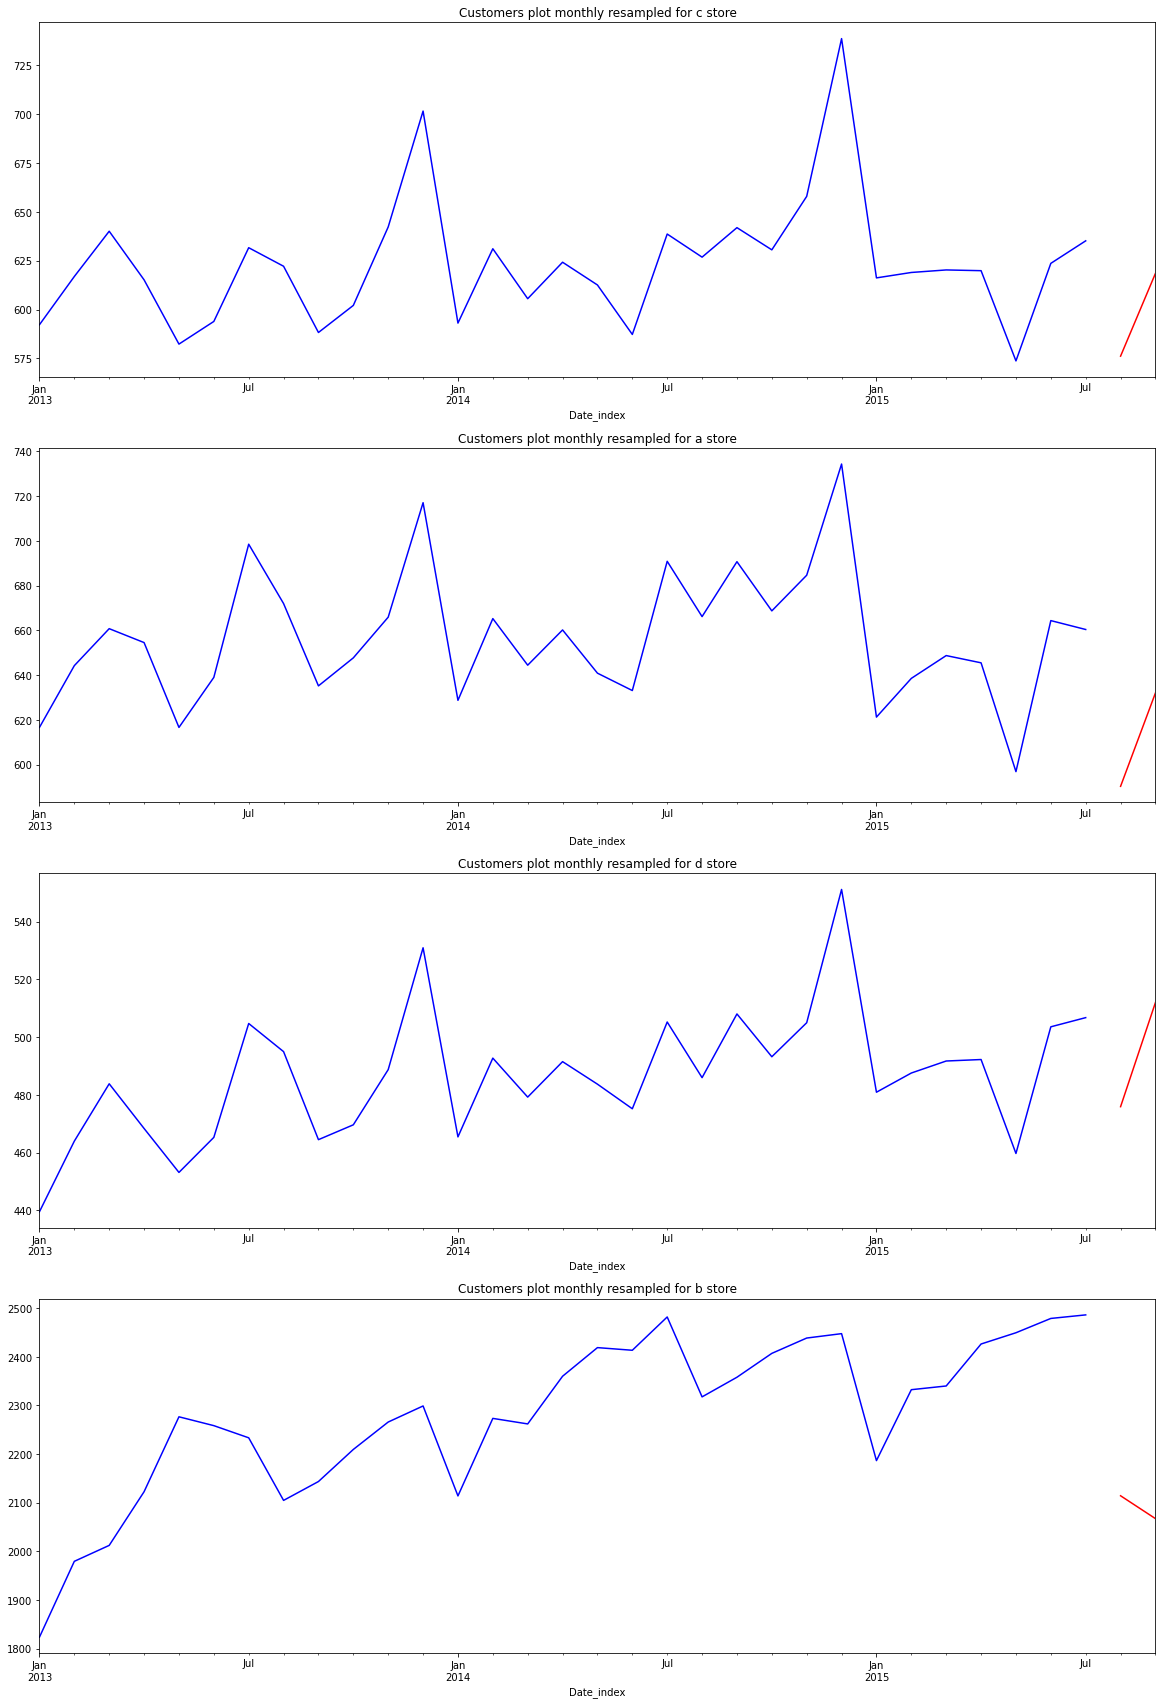

In [138]:
fig, axs = plt.subplots(nrows=all_data.StoreType.nunique(), ncols=1, figsize=(20, 30))

for idx, store_type in enumerate(all_data.StoreType.unique()):
    all_data.loc[(all_data.StoreType == store_type) & (all_data.color == 'b'), :].set_index(
        'Date_index').Customers.resample('M').mean().plot(
        ax=axs[idx], title=f'Customers plot monthly resampled for {store_type} store', color='b');
    
    all_data.loc[(all_data.StoreType == store_type) & (all_data.color == 'r'), :].set_index(
        'Date_index').Customers.resample('M').mean().plot(
        ax=axs[idx], title=f'Customers plot monthly resampled for {store_type} store', color='r');

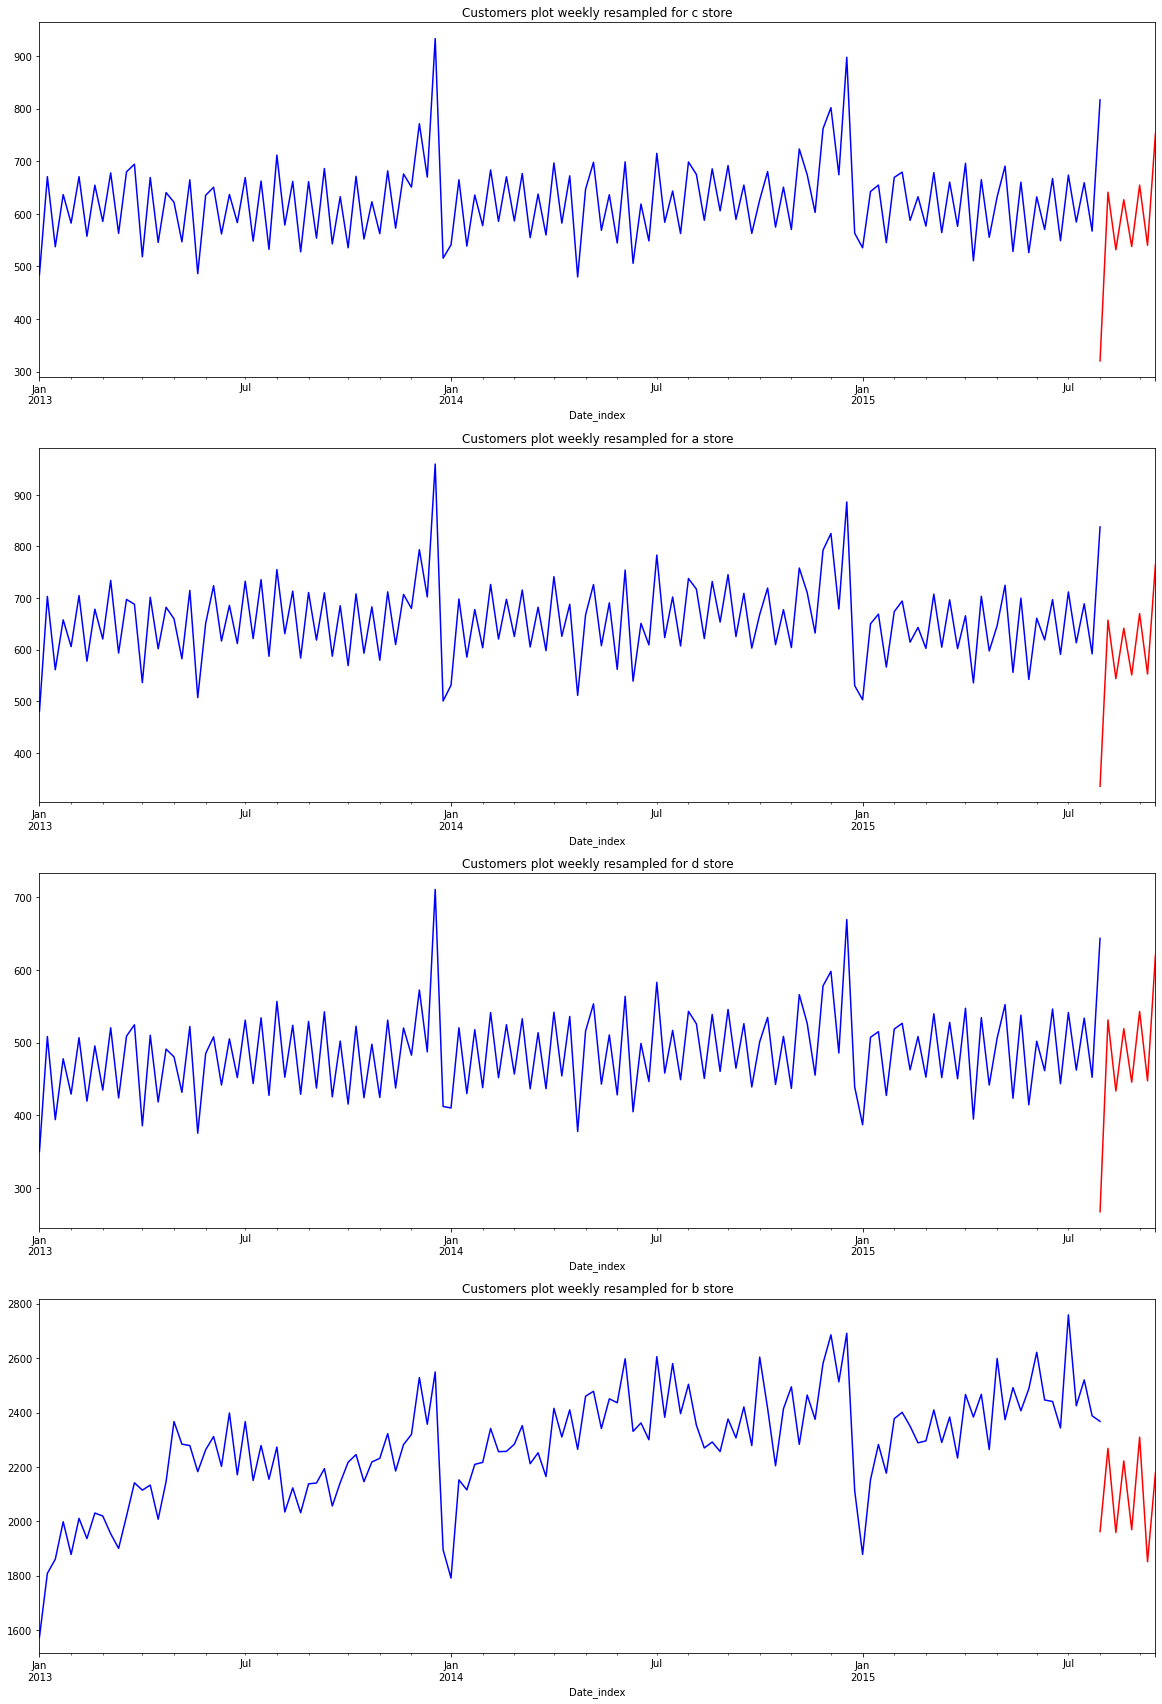

In [139]:
fig, axs = plt.subplots(nrows=all_data.StoreType.nunique(), ncols=1, figsize=(20, 30))

for idx, store_type in enumerate(all_data.StoreType.unique()):
    all_data.loc[(all_data.StoreType == store_type) & (all_data.color == 'b'), :].set_index(
        'Date_index').Customers.resample('W').mean().plot(
        ax=axs[idx], title=f'Customers plot weekly resampled for {store_type} store', color='b');
    
    all_data.loc[(all_data.StoreType == store_type) & (all_data.color == 'r'), :].set_index(
        'Date_index').Customers.resample('W').mean().plot(
        ax=axs[idx], title=f'Customers plot weekly resampled for {store_type} store', color='r');

## Fit models to predict sales

In [142]:
all_baseline_results_sales = pd.DataFrame()

In [143]:
for transformer_name, encoder_name, model_name in tqdm(product(TRANSFORMERS_NAMES,
                                                               ENCODERS_NAMES,
                                                               MODELS_NAMES[:-1]
                                                              )
                                                      ):
    transformer = TRANSFORMERS_MAPPING.get(transformer_name)
    encoder = ENCODERS_MAPPING.get(encoder_name)
    model = MODELS_MAPPING.get(model_name)
    
    tmp_df = train_data_prepared_dropped.copy(deep=True)
    
    tmp_encoded = encoder.fit_transform(tmp_df[CATEGORICAL_FEATURES])
    tmp_transformed = pd.DataFrame(transformer.fit_transform(tmp_df[NUMERIC_FEATURES]),
                                   columns=NUMERIC_FEATURES, index=tmp_df.index
                                  )
    
    tmp_df_prepared = tmp_transformed.join(tmp_encoded).fillna(0)
    
    cross_val_results = cross_validate(model, tmp_df_prepared, tmp_df['Sales_logged'],
                                       scoring=('r2', 'neg_mean_absolute_error','neg_mean_squared_error',
                                                'neg_root_mean_squared_error',
                                                'neg_mean_absolute_percentage_error'
                                               ), 
                                       cv=KFold(n_splits=N_SPLITS,
                                                shuffle=True,
                                                random_state=42
                                               ),
                                       return_train_score=True
                                      )
    
    cross_val_results = pd.DataFrame(cross_val_results)
    cross_val_results.index = pd.MultiIndex.from_product(([model_name], list(range(N_SPLITS))))
    cross_val_results.index.names = ['model', 'split_number']

    cross_val_results =- cross_val_results

    rename_map = [el.replace('_neg', '') for el in cross_val_results.filter(like='neg').columns.tolist()]
    rename_map = dict(zip(cross_val_results.filter(like='neg').columns, rename_map))

    cross_val_results = cross_val_results.rename(columns=rename_map)
    
    all_baseline_results_sales = pd.concat((all_baseline_results_sales, cross_val_results))

27it [1:47:40, 239.27s/it]


In [144]:
all_baseline_results_sales.head()

fit_time  score_time   test_r2  train_r2  \
model            split_number                                             
LinearRegression 0            -3.175758   -0.062617 -0.996276 -0.996373   
                 1            -3.095896   -0.074585 -0.996253 -0.996378   
                 2            -3.147606   -0.071649 -0.996389 -0.996344   
                 3            -3.093532   -0.053807 -0.996359 -0.996352   
                 4            -3.119698   -0.054511 -0.996485 -0.996320   

                               test_mean_absolute_error  \
model            split_number                             
LinearRegression 0                             0.143531   
                 1                             0.143355   
                 2                             0.143573   
                 3                             0.143218   
                 4                             0.142991   

                               train_mean_absolute_error  \
model            split_number                              
LinearRegression 0                              0.143269   
                 1                              0.143320   
                 2                              0.143253   
                 3                              0.143339   
                 4                              0.143404   

                               test_mean_squared_error  \
model            split_number                            
LinearRegression 0                            0.040873   
                 1                            0.040966   
                 2                            0.039160   
                 3                            0.039646   
                 4                            0.038674   

                               train_mean_squared_error  \
model            split_number                             
LinearRegression 0                             0.039600   
                 1                             0.039578   
                 2                             0.040029   
                 3                             0.039907   
                 4                             0.040151   

                               test_root_mean_squared_error  \
model            split_number                                 
LinearRegression 0                                 0.202172   
                 1                                 0.202401   
                 2                                 0.197888   
                 3                                 0.199114   
                 4                                 0.196658   

                               train_root_mean_squared_error  \
model            split_number                                  
LinearRegression 0                                  0.198998   
                 1                                  0.198941   
                 2                                  0.200073   
                 3                                  0.199768   
                 4                                  0.200376   

                               test_mean_absolute_percentage_error  \
model            split_number                                        
LinearRegression 0                                    6.665711e+13   
                 1                                    6.580904e+13   
                 2                                    6.429535e+13   
                 3                                    6.539740e+13   
                 4                                    6.536455e+13   

                               train_mean_absolute_percentage_error  
model            split_number                                        
LinearRegression 0                                     6.525072e+13  
                 1                                     6.545053e+13  
                 2                                     6.587899e+13  
                 3                                     6.539771e+13  
                 4                             

In [145]:
all_baseline_results_sales.shape

(135, 12)

In [146]:
baseline_results_index = pd.MultiIndex.from_product((TRANSFORMERS_NAMES, ENCODERS_NAMES, MODELS_NAMES[:-1], 
                                                    list(range(N_SPLITS)))
                                                   )

In [147]:
all_baseline_results_sales.index = baseline_results_index
all_baseline_results_sales.index.names = ['transformer', 'encoder', 'model', 'split_number']

In [148]:
all_baseline_results_sales.head()

fit_time  \
transformer    encoder       model            split_number             
StandardScaler OneHotEncoder LinearRegression 0            -3.175758   
                                              1            -3.095896   
                                              2            -3.147606   
                                              3            -3.093532   
                                              4            -3.119698   

                                                            score_time  \
transformer    encoder       model            split_number               
StandardScaler OneHotEncoder LinearRegression 0              -0.062617   
                                              1              -0.074585   
                                              2              -0.071649   
                                              3              -0.053807   
                                              4              -0.054511   

                                                             test_r2  \
transformer    encoder       model            split_number             
StandardScaler OneHotEncoder LinearRegression 0            -0.996276   
                                              1            -0.996253   
                                              2            -0.996389   
                                              3            -0.996359   
                                              4            -0.996485   

                                                            train_r2  \
transformer    encoder       model            split_number             
StandardScaler OneHotEncoder LinearRegression 0            -0.996373   
                                              1            -0.996378   
                                              2            -0.996344   
                                              3            -0.996352   
                                              4            -0.996320   

                                                            test_mean_absolute_error  \
transformer    encoder       model            split_number                             
StandardScaler OneHotEncoder LinearRegression 0                             0.143531   
                                              1                             0.143355   
                                              2                             0.143573   
                                              3                             0.143218   
                                              4                             0.142991   

                                                            train_mean_absolute_error  \
transformer    encoder       model            split_number                              
StandardScaler OneHotEncoder LinearRegression 0                              0.143269   
                                              1                              0.143320   
                                              2                              0.143253   
                                              3                              0.143339   
                                              4                              0.143404   

                                                            test_mean_squared_error  \
transformer    encoder       model            split_number                            
StandardScaler OneHotEncoder LinearRegression 0                            0.040873   
                                              1                            0.040966   
                                              2                            0.039160   
                                              3                            0.039646   
                                              4                            0.038674   

                                                            train_mean_squared_error  \
transformer    encoder       model            split_number                             

In [149]:
all_baseline_results_sales[['fit_time', 'score_time', 'test_r2', 'train_r2']] =- all_baseline_results_sales[['fit_time', 'score_time', 'test_r2', 'train_r2']]

In [150]:
all_baseline_results_sales.head()

fit_time  \
transformer    encoder       model            split_number             
StandardScaler OneHotEncoder LinearRegression 0             3.175758   
                                              1             3.095896   
                                              2             3.147606   
                                              3             3.093532   
                                              4             3.119698   

                                                            score_time  \
transformer    encoder       model            split_number               
StandardScaler OneHotEncoder LinearRegression 0               0.062617   
                                              1               0.074585   
                                              2               0.071649   
                                              3               0.053807   
                                              4               0.054511   

                                                             test_r2  \
transformer    encoder       model            split_number             
StandardScaler OneHotEncoder LinearRegression 0             0.996276   
                                              1             0.996253   
                                              2             0.996389   
                                              3             0.996359   
                                              4             0.996485   

                                                            train_r2  \
transformer    encoder       model            split_number             
StandardScaler OneHotEncoder LinearRegression 0             0.996373   
                                              1             0.996378   
                                              2             0.996344   
                                              3             0.996352   
                                              4             0.996320   

                                                            test_mean_absolute_error  \
transformer    encoder       model            split_number                             
StandardScaler OneHotEncoder LinearRegression 0                             0.143531   
                                              1                             0.143355   
                                              2                             0.143573   
                                              3                             0.143218   
                                              4                             0.142991   

                                                            train_mean_absolute_error  \
transformer    encoder       model            split_number                              
StandardScaler OneHotEncoder LinearRegression 0                              0.143269   
                                              1                              0.143320   
                                              2                              0.143253   
                                              3                              0.143339   
                                              4                              0.143404   

                                                            test_mean_squared_error  \
transformer    encoder       model            split_number                            
StandardScaler OneHotEncoder LinearRegression 0                            0.040873   
                                              1                            0.040966   
                                              2                            0.039160   
                                              3                            0.039646   
                                              4                            0.038674   

                                                            train_mean_squared_error  \
transformer    encoder       model            split_number                             

In [159]:
all_baseline_results_sales_catboost = pd.DataFrame()

In [160]:
for transformer_name, model_name in tqdm(product(TRANSFORMERS_NAMES, [MODELS_NAMES[-1]])):
    transformer = TRANSFORMERS_MAPPING.get(transformer_name)
    model = CatBoostRegressor(cat_features=CATEGORICAL_FEATURES)
    
    tmp_df = train_data_prepared_dropped.copy(deep=True)
    
    tmp_transformed = pd.DataFrame(transformer.fit_transform(tmp_df[NUMERIC_FEATURES]),
                                   columns=NUMERIC_FEATURES, index=tmp_df.index
                                  )
    
    tmp_df_prepared = tmp_transformed.join(tmp_df[CATEGORICAL_FEATURES].astype(str)).fillna(0)
    
    cross_val_results = cross_validate(model, tmp_df_prepared, tmp_df['Sales_logged'],
                                       scoring=('r2', 'neg_mean_absolute_error','neg_mean_squared_error',
                                                'neg_root_mean_squared_error',
                                                'neg_mean_absolute_percentage_error'
                                               ), 
                                       cv=KFold(n_splits=N_SPLITS,
                                                shuffle=True,
                                                random_state=42
                                               ),
                                       return_train_score=True
                                      )
    
    cross_val_results = pd.DataFrame(cross_val_results)
    cross_val_results.index = pd.MultiIndex.from_product(([model_name], list(range(N_SPLITS))))
    cross_val_results.index.names = ['model', 'split_number']

    cross_val_results =- cross_val_results

    rename_map = [el.replace('_neg', '') for el in cross_val_results.filter(like='neg').columns.tolist()]
    rename_map = dict(zip(cross_val_results.filter(like='neg').columns, rename_map))

    cross_val_results = cross_val_results.rename(columns=rename_map)
    
    all_baseline_results_sales_catboost = pd.concat((all_baseline_results_sales_catboost, cross_val_results))

0it [00:00, ?it/s]

Learning rate set to 0.122538
0:	learn: 2.9022670	total: 431ms	remaining: 7m 10s
1:	learn: 2.5499252	total: 995ms	remaining: 8m 16s
2:	learn: 2.2397861	total: 1.46s	remaining: 8m 4s
3:	learn: 1.9689329	total: 1.85s	remaining: 7m 42s
4:	learn: 1.7310982	total: 2.25s	remaining: 7m 27s
5:	learn: 1.5224628	total: 2.62s	remaining: 7m 14s
6:	learn: 1.3395021	total: 3s	remaining: 7m 5s
7:	learn: 1.1793727	total: 3.3s	remaining: 6m 49s
8:	learn: 1.0392619	total: 3.69s	remaining: 6m 45s
9:	learn: 0.9171294	total: 4.05s	remaining: 6m 40s
10:	learn: 0.8105624	total: 4.39s	remaining: 6m 35s
11:	learn: 0.7172012	total: 4.77s	remaining: 6m 33s
12:	learn: 0.6357001	total: 5.14s	remaining: 6m 30s
13:	learn: 0.5648848	total: 5.54s	remaining: 6m 30s
14:	learn: 0.5033537	total: 5.92s	remaining: 6m 28s
15:	learn: 0.4494973	total: 6.29s	remaining: 6m 26s
16:	learn: 0.4020568	total: 6.59s	remaining: 6m 21s
17:	learn: 0.3612136	total: 6.91s	remaining: 6m 16s
18:	learn: 0.3260966	total: 7.21s	remaining: 6m 12

157:	learn: 0.1147729	total: 53.7s	remaining: 4m 46s
158:	learn: 0.1146575	total: 54s	remaining: 4m 45s
159:	learn: 0.1145656	total: 54.3s	remaining: 4m 45s
160:	learn: 0.1143562	total: 54.6s	remaining: 4m 44s
161:	learn: 0.1142196	total: 55s	remaining: 4m 44s
162:	learn: 0.1140159	total: 55.4s	remaining: 4m 44s
163:	learn: 0.1139212	total: 55.7s	remaining: 4m 43s
164:	learn: 0.1137916	total: 56s	remaining: 4m 43s
165:	learn: 0.1137214	total: 56.3s	remaining: 4m 42s
166:	learn: 0.1136618	total: 56.6s	remaining: 4m 42s
167:	learn: 0.1135371	total: 56.9s	remaining: 4m 41s
168:	learn: 0.1134398	total: 57.2s	remaining: 4m 41s
169:	learn: 0.1133046	total: 57.5s	remaining: 4m 40s
170:	learn: 0.1130969	total: 57.8s	remaining: 4m 40s
171:	learn: 0.1129708	total: 58.2s	remaining: 4m 40s
172:	learn: 0.1126725	total: 58.6s	remaining: 4m 39s
173:	learn: 0.1125616	total: 59s	remaining: 4m 39s
174:	learn: 0.1124963	total: 59.4s	remaining: 4m 39s
175:	learn: 0.1123320	total: 59.7s	remaining: 4m 39s
1

311:	learn: 0.0989716	total: 1m 42s	remaining: 3m 46s
312:	learn: 0.0988466	total: 1m 43s	remaining: 3m 46s
313:	learn: 0.0987867	total: 1m 43s	remaining: 3m 46s
314:	learn: 0.0986641	total: 1m 43s	remaining: 3m 45s
315:	learn: 0.0986095	total: 1m 44s	remaining: 3m 45s
316:	learn: 0.0985382	total: 1m 44s	remaining: 3m 44s
317:	learn: 0.0984923	total: 1m 44s	remaining: 3m 44s
318:	learn: 0.0984286	total: 1m 45s	remaining: 3m 44s
319:	learn: 0.0983892	total: 1m 45s	remaining: 3m 43s
320:	learn: 0.0982712	total: 1m 45s	remaining: 3m 43s
321:	learn: 0.0982029	total: 1m 45s	remaining: 3m 43s
322:	learn: 0.0981606	total: 1m 46s	remaining: 3m 42s
323:	learn: 0.0980999	total: 1m 46s	remaining: 3m 42s
324:	learn: 0.0980251	total: 1m 46s	remaining: 3m 42s
325:	learn: 0.0979806	total: 1m 47s	remaining: 3m 41s
326:	learn: 0.0979461	total: 1m 47s	remaining: 3m 41s
327:	learn: 0.0979179	total: 1m 48s	remaining: 3m 41s
328:	learn: 0.0978525	total: 1m 48s	remaining: 3m 40s
329:	learn: 0.0977429	total:

465:	learn: 0.0901188	total: 2m 31s	remaining: 2m 53s
466:	learn: 0.0900413	total: 2m 31s	remaining: 2m 53s
467:	learn: 0.0900288	total: 2m 32s	remaining: 2m 52s
468:	learn: 0.0900146	total: 2m 32s	remaining: 2m 52s
469:	learn: 0.0900007	total: 2m 32s	remaining: 2m 52s
470:	learn: 0.0899451	total: 2m 32s	remaining: 2m 51s
471:	learn: 0.0899362	total: 2m 33s	remaining: 2m 51s
472:	learn: 0.0898901	total: 2m 33s	remaining: 2m 51s
473:	learn: 0.0898694	total: 2m 33s	remaining: 2m 50s
474:	learn: 0.0898103	total: 2m 34s	remaining: 2m 50s
475:	learn: 0.0897674	total: 2m 34s	remaining: 2m 49s
476:	learn: 0.0897284	total: 2m 34s	remaining: 2m 49s
477:	learn: 0.0896568	total: 2m 35s	remaining: 2m 49s
478:	learn: 0.0896190	total: 2m 35s	remaining: 2m 48s
479:	learn: 0.0896044	total: 2m 35s	remaining: 2m 48s
480:	learn: 0.0895592	total: 2m 35s	remaining: 2m 48s
481:	learn: 0.0895370	total: 2m 36s	remaining: 2m 47s
482:	learn: 0.0894304	total: 2m 36s	remaining: 2m 47s
483:	learn: 0.0894208	total:

618:	learn: 0.0835338	total: 3m 16s	remaining: 2m 1s
619:	learn: 0.0835176	total: 3m 17s	remaining: 2m
620:	learn: 0.0834649	total: 3m 17s	remaining: 2m
621:	learn: 0.0834506	total: 3m 17s	remaining: 2m
622:	learn: 0.0833945	total: 3m 18s	remaining: 1m 59s
623:	learn: 0.0833562	total: 3m 18s	remaining: 1m 59s
624:	learn: 0.0832923	total: 3m 18s	remaining: 1m 59s
625:	learn: 0.0832748	total: 3m 18s	remaining: 1m 58s
626:	learn: 0.0831895	total: 3m 19s	remaining: 1m 58s
627:	learn: 0.0831248	total: 3m 19s	remaining: 1m 58s
628:	learn: 0.0831172	total: 3m 19s	remaining: 1m 57s
629:	learn: 0.0830753	total: 3m 19s	remaining: 1m 57s
630:	learn: 0.0830620	total: 3m 20s	remaining: 1m 57s
631:	learn: 0.0830514	total: 3m 20s	remaining: 1m 56s
632:	learn: 0.0829959	total: 3m 20s	remaining: 1m 56s
633:	learn: 0.0829825	total: 3m 21s	remaining: 1m 56s
634:	learn: 0.0829592	total: 3m 21s	remaining: 1m 55s
635:	learn: 0.0829271	total: 3m 21s	remaining: 1m 55s
636:	learn: 0.0829031	total: 3m 22s	remai

771:	learn: 0.0791989	total: 4m 1s	remaining: 1m 11s
772:	learn: 0.0791749	total: 4m 2s	remaining: 1m 11s
773:	learn: 0.0791505	total: 4m 2s	remaining: 1m 10s
774:	learn: 0.0791300	total: 4m 2s	remaining: 1m 10s
775:	learn: 0.0791183	total: 4m 3s	remaining: 1m 10s
776:	learn: 0.0791102	total: 4m 3s	remaining: 1m 9s
777:	learn: 0.0791049	total: 4m 3s	remaining: 1m 9s
778:	learn: 0.0790931	total: 4m 3s	remaining: 1m 9s
779:	learn: 0.0790489	total: 4m 4s	remaining: 1m 8s
780:	learn: 0.0790144	total: 4m 4s	remaining: 1m 8s
781:	learn: 0.0790078	total: 4m 4s	remaining: 1m 8s
782:	learn: 0.0789549	total: 4m 4s	remaining: 1m 7s
783:	learn: 0.0789488	total: 4m 5s	remaining: 1m 7s
784:	learn: 0.0789424	total: 4m 5s	remaining: 1m 7s
785:	learn: 0.0789074	total: 4m 5s	remaining: 1m 6s
786:	learn: 0.0788887	total: 4m 6s	remaining: 1m 6s
787:	learn: 0.0788839	total: 4m 6s	remaining: 1m 6s
788:	learn: 0.0788499	total: 4m 6s	remaining: 1m 5s
789:	learn: 0.0788246	total: 4m 6s	remaining: 1m 5s
790:	le

927:	learn: 0.0756699	total: 4m 47s	remaining: 22.3s
928:	learn: 0.0756427	total: 4m 47s	remaining: 22s
929:	learn: 0.0756367	total: 4m 48s	remaining: 21.7s
930:	learn: 0.0755562	total: 4m 48s	remaining: 21.4s
931:	learn: 0.0755472	total: 4m 48s	remaining: 21.1s
932:	learn: 0.0755349	total: 4m 49s	remaining: 20.8s
933:	learn: 0.0755041	total: 4m 49s	remaining: 20.4s
934:	learn: 0.0754897	total: 4m 49s	remaining: 20.1s
935:	learn: 0.0754822	total: 4m 49s	remaining: 19.8s
936:	learn: 0.0754563	total: 4m 50s	remaining: 19.5s
937:	learn: 0.0754316	total: 4m 50s	remaining: 19.2s
938:	learn: 0.0754258	total: 4m 50s	remaining: 18.9s
939:	learn: 0.0754181	total: 4m 51s	remaining: 18.6s
940:	learn: 0.0754122	total: 4m 51s	remaining: 18.3s
941:	learn: 0.0753816	total: 4m 51s	remaining: 18s
942:	learn: 0.0753590	total: 4m 52s	remaining: 17.7s
943:	learn: 0.0753215	total: 4m 52s	remaining: 17.4s
944:	learn: 0.0753044	total: 4m 52s	remaining: 17s
945:	learn: 0.0752530	total: 4m 53s	remaining: 16.7s

85:	learn: 0.1257334	total: 24.7s	remaining: 4m 22s
86:	learn: 0.1256321	total: 24.8s	remaining: 4m 20s
87:	learn: 0.1254040	total: 25.1s	remaining: 4m 20s
88:	learn: 0.1251596	total: 25.4s	remaining: 4m 19s
89:	learn: 0.1249787	total: 25.7s	remaining: 4m 19s
90:	learn: 0.1248899	total: 26s	remaining: 4m 19s
91:	learn: 0.1245475	total: 26.3s	remaining: 4m 19s
92:	learn: 0.1243480	total: 26.6s	remaining: 4m 19s
93:	learn: 0.1241798	total: 26.9s	remaining: 4m 19s
94:	learn: 0.1239964	total: 27.2s	remaining: 4m 18s
95:	learn: 0.1239096	total: 27.4s	remaining: 4m 18s
96:	learn: 0.1236979	total: 27.7s	remaining: 4m 17s
97:	learn: 0.1235401	total: 28s	remaining: 4m 17s
98:	learn: 0.1233369	total: 28.3s	remaining: 4m 17s
99:	learn: 0.1232825	total: 28.6s	remaining: 4m 17s
100:	learn: 0.1231461	total: 28.9s	remaining: 4m 16s
101:	learn: 0.1230114	total: 29.2s	remaining: 4m 16s
102:	learn: 0.1227279	total: 29.5s	remaining: 4m 16s
103:	learn: 0.1224029	total: 29.8s	remaining: 4m 16s
104:	learn: 

242:	learn: 0.1046922	total: 1m 13s	remaining: 3m 48s
243:	learn: 0.1046180	total: 1m 13s	remaining: 3m 48s
244:	learn: 0.1045564	total: 1m 13s	remaining: 3m 47s
245:	learn: 0.1044631	total: 1m 14s	remaining: 3m 47s
246:	learn: 0.1044348	total: 1m 14s	remaining: 3m 47s
247:	learn: 0.1043573	total: 1m 14s	remaining: 3m 46s
248:	learn: 0.1043148	total: 1m 15s	remaining: 3m 46s
249:	learn: 0.1041619	total: 1m 15s	remaining: 3m 46s
250:	learn: 0.1040201	total: 1m 15s	remaining: 3m 45s
251:	learn: 0.1038841	total: 1m 15s	remaining: 3m 45s
252:	learn: 0.1038198	total: 1m 16s	remaining: 3m 45s
253:	learn: 0.1037774	total: 1m 16s	remaining: 3m 44s
254:	learn: 0.1036927	total: 1m 16s	remaining: 3m 44s
255:	learn: 0.1035572	total: 1m 17s	remaining: 3m 44s
256:	learn: 0.1034379	total: 1m 17s	remaining: 3m 43s
257:	learn: 0.1034040	total: 1m 17s	remaining: 3m 43s
258:	learn: 0.1033120	total: 1m 18s	remaining: 3m 43s
259:	learn: 0.1031696	total: 1m 18s	remaining: 3m 42s
260:	learn: 0.1031019	total:

395:	learn: 0.0927354	total: 2m	remaining: 3m 3s
396:	learn: 0.0927169	total: 2m	remaining: 3m 3s
397:	learn: 0.0926659	total: 2m 1s	remaining: 3m 3s
398:	learn: 0.0926139	total: 2m 1s	remaining: 3m 3s
399:	learn: 0.0925595	total: 2m 1s	remaining: 3m 2s
400:	learn: 0.0924514	total: 2m 2s	remaining: 3m 2s
401:	learn: 0.0923733	total: 2m 2s	remaining: 3m 2s
402:	learn: 0.0923359	total: 2m 2s	remaining: 3m 1s
403:	learn: 0.0922693	total: 2m 3s	remaining: 3m 1s
404:	learn: 0.0922212	total: 2m 3s	remaining: 3m 1s
405:	learn: 0.0921803	total: 2m 3s	remaining: 3m 1s
406:	learn: 0.0921600	total: 2m 4s	remaining: 3m
407:	learn: 0.0921052	total: 2m 4s	remaining: 3m
408:	learn: 0.0920880	total: 2m 4s	remaining: 3m
409:	learn: 0.0920464	total: 2m 5s	remaining: 2m 59s
410:	learn: 0.0919915	total: 2m 5s	remaining: 2m 59s
411:	learn: 0.0919413	total: 2m 5s	remaining: 2m 59s
412:	learn: 0.0919256	total: 2m 6s	remaining: 2m 59s
413:	learn: 0.0918811	total: 2m 6s	remaining: 2m 58s
414:	learn: 0.0918202	

548:	learn: 0.0855328	total: 2m 49s	remaining: 2m 19s
549:	learn: 0.0855082	total: 2m 49s	remaining: 2m 19s
550:	learn: 0.0854819	total: 2m 50s	remaining: 2m 18s
551:	learn: 0.0854713	total: 2m 50s	remaining: 2m 18s
552:	learn: 0.0854341	total: 2m 50s	remaining: 2m 18s
553:	learn: 0.0854115	total: 2m 51s	remaining: 2m 17s
554:	learn: 0.0853908	total: 2m 51s	remaining: 2m 17s
555:	learn: 0.0853122	total: 2m 51s	remaining: 2m 17s
556:	learn: 0.0852677	total: 2m 52s	remaining: 2m 16s
557:	learn: 0.0852630	total: 2m 52s	remaining: 2m 16s
558:	learn: 0.0852481	total: 2m 52s	remaining: 2m 16s
559:	learn: 0.0852220	total: 2m 52s	remaining: 2m 15s
560:	learn: 0.0852137	total: 2m 53s	remaining: 2m 15s
561:	learn: 0.0852036	total: 2m 53s	remaining: 2m 15s
562:	learn: 0.0851858	total: 2m 53s	remaining: 2m 14s
563:	learn: 0.0851150	total: 2m 54s	remaining: 2m 14s
564:	learn: 0.0850734	total: 2m 54s	remaining: 2m 14s
565:	learn: 0.0849916	total: 2m 54s	remaining: 2m 14s
566:	learn: 0.0849749	total:

702:	learn: 0.0805725	total: 3m 37s	remaining: 1m 31s
703:	learn: 0.0805453	total: 3m 37s	remaining: 1m 31s
704:	learn: 0.0804731	total: 3m 38s	remaining: 1m 31s
705:	learn: 0.0804001	total: 3m 38s	remaining: 1m 30s
706:	learn: 0.0803473	total: 3m 38s	remaining: 1m 30s
707:	learn: 0.0803000	total: 3m 38s	remaining: 1m 30s
708:	learn: 0.0802911	total: 3m 39s	remaining: 1m 29s
709:	learn: 0.0802456	total: 3m 39s	remaining: 1m 29s
710:	learn: 0.0802097	total: 3m 39s	remaining: 1m 29s
711:	learn: 0.0801929	total: 3m 40s	remaining: 1m 29s
712:	learn: 0.0801616	total: 3m 40s	remaining: 1m 28s
713:	learn: 0.0801400	total: 3m 40s	remaining: 1m 28s
714:	learn: 0.0800836	total: 3m 41s	remaining: 1m 28s
715:	learn: 0.0800775	total: 3m 41s	remaining: 1m 27s
716:	learn: 0.0800311	total: 3m 41s	remaining: 1m 27s
717:	learn: 0.0799964	total: 3m 41s	remaining: 1m 27s
718:	learn: 0.0799208	total: 3m 42s	remaining: 1m 26s
719:	learn: 0.0798714	total: 3m 42s	remaining: 1m 26s
720:	learn: 0.0798555	total:

857:	learn: 0.0761835	total: 4m 24s	remaining: 43.8s
858:	learn: 0.0761587	total: 4m 24s	remaining: 43.5s
859:	learn: 0.0761386	total: 4m 25s	remaining: 43.2s
860:	learn: 0.0761290	total: 4m 25s	remaining: 42.9s
861:	learn: 0.0761068	total: 4m 25s	remaining: 42.6s
862:	learn: 0.0760775	total: 4m 26s	remaining: 42.3s
863:	learn: 0.0760551	total: 4m 26s	remaining: 42s
864:	learn: 0.0760148	total: 4m 26s	remaining: 41.7s
865:	learn: 0.0759753	total: 4m 27s	remaining: 41.3s
866:	learn: 0.0759645	total: 4m 27s	remaining: 41s
867:	learn: 0.0759401	total: 4m 27s	remaining: 40.7s
868:	learn: 0.0759240	total: 4m 28s	remaining: 40.4s
869:	learn: 0.0758723	total: 4m 28s	remaining: 40.1s
870:	learn: 0.0758460	total: 4m 28s	remaining: 39.8s
871:	learn: 0.0758134	total: 4m 29s	remaining: 39.5s
872:	learn: 0.0758014	total: 4m 29s	remaining: 39.2s
873:	learn: 0.0757920	total: 4m 29s	remaining: 38.9s
874:	learn: 0.0757512	total: 4m 30s	remaining: 38.6s
875:	learn: 0.0757234	total: 4m 30s	remaining: 38.

13:	learn: 0.5654429	total: 4.9s	remaining: 5m 44s
14:	learn: 0.5040439	total: 5.23s	remaining: 5m 43s
15:	learn: 0.4501025	total: 5.58s	remaining: 5m 43s
16:	learn: 0.4034718	total: 5.93s	remaining: 5m 43s
17:	learn: 0.3635166	total: 6.29s	remaining: 5m 43s
18:	learn: 0.3280087	total: 6.7s	remaining: 5m 45s
19:	learn: 0.2973280	total: 7s	remaining: 5m 43s
20:	learn: 0.2713052	total: 7.29s	remaining: 5m 39s
21:	learn: 0.2490649	total: 7.5s	remaining: 5m 33s
22:	learn: 0.2303406	total: 7.76s	remaining: 5m 29s
23:	learn: 0.2149409	total: 8.03s	remaining: 5m 26s
24:	learn: 0.2018335	total: 8.33s	remaining: 5m 24s
25:	learn: 0.1909710	total: 8.57s	remaining: 5m 21s
26:	learn: 0.1820477	total: 8.81s	remaining: 5m 17s
27:	learn: 0.1748086	total: 9.14s	remaining: 5m 17s
28:	learn: 0.1689380	total: 9.41s	remaining: 5m 15s
29:	learn: 0.1639341	total: 9.69s	remaining: 5m 13s
30:	learn: 0.1598351	total: 10s	remaining: 5m 13s
31:	learn: 0.1564708	total: 10.2s	remaining: 5m 9s
32:	learn: 0.1537579	

171:	learn: 0.1119070	total: 51.5s	remaining: 4m 8s
172:	learn: 0.1118343	total: 51.8s	remaining: 4m 7s
173:	learn: 0.1116975	total: 52.1s	remaining: 4m 7s
174:	learn: 0.1116369	total: 52.4s	remaining: 4m 7s
175:	learn: 0.1115974	total: 52.7s	remaining: 4m 6s
176:	learn: 0.1114287	total: 53s	remaining: 4m 6s
177:	learn: 0.1112497	total: 53.4s	remaining: 4m 6s
178:	learn: 0.1110500	total: 53.7s	remaining: 4m 6s
179:	learn: 0.1108096	total: 54s	remaining: 4m 5s
180:	learn: 0.1106575	total: 54.3s	remaining: 4m 5s
181:	learn: 0.1105379	total: 54.6s	remaining: 4m 5s
182:	learn: 0.1104432	total: 55s	remaining: 4m 5s
183:	learn: 0.1102888	total: 55.3s	remaining: 4m 5s
184:	learn: 0.1101341	total: 55.6s	remaining: 4m 4s
185:	learn: 0.1099667	total: 55.9s	remaining: 4m 4s
186:	learn: 0.1098732	total: 56.2s	remaining: 4m 4s
187:	learn: 0.1097650	total: 56.5s	remaining: 4m 4s
188:	learn: 0.1096170	total: 56.8s	remaining: 4m 3s
189:	learn: 0.1095731	total: 57.1s	remaining: 4m 3s
190:	learn: 0.1095

326:	learn: 0.0977157	total: 1m 40s	remaining: 3m 26s
327:	learn: 0.0976133	total: 1m 40s	remaining: 3m 25s
328:	learn: 0.0975803	total: 1m 40s	remaining: 3m 25s
329:	learn: 0.0975583	total: 1m 41s	remaining: 3m 25s
330:	learn: 0.0974715	total: 1m 41s	remaining: 3m 25s
331:	learn: 0.0973953	total: 1m 41s	remaining: 3m 24s
332:	learn: 0.0973213	total: 1m 42s	remaining: 3m 24s
333:	learn: 0.0972524	total: 1m 42s	remaining: 3m 24s
334:	learn: 0.0971910	total: 1m 42s	remaining: 3m 23s
335:	learn: 0.0971313	total: 1m 43s	remaining: 3m 23s
336:	learn: 0.0970371	total: 1m 43s	remaining: 3m 23s
337:	learn: 0.0970059	total: 1m 43s	remaining: 3m 23s
338:	learn: 0.0969523	total: 1m 43s	remaining: 3m 22s
339:	learn: 0.0969357	total: 1m 44s	remaining: 3m 22s
340:	learn: 0.0968727	total: 1m 44s	remaining: 3m 22s
341:	learn: 0.0967910	total: 1m 44s	remaining: 3m 21s
342:	learn: 0.0967631	total: 1m 45s	remaining: 3m 21s
343:	learn: 0.0966949	total: 1m 45s	remaining: 3m 21s
344:	learn: 0.0966205	total:

480:	learn: 0.0889131	total: 2m 28s	remaining: 2m 39s
481:	learn: 0.0888915	total: 2m 28s	remaining: 2m 39s
482:	learn: 0.0888330	total: 2m 28s	remaining: 2m 39s
483:	learn: 0.0887941	total: 2m 29s	remaining: 2m 38s
484:	learn: 0.0887666	total: 2m 29s	remaining: 2m 38s
485:	learn: 0.0887531	total: 2m 29s	remaining: 2m 38s
486:	learn: 0.0886906	total: 2m 29s	remaining: 2m 37s
487:	learn: 0.0886520	total: 2m 30s	remaining: 2m 37s
488:	learn: 0.0886123	total: 2m 30s	remaining: 2m 37s
489:	learn: 0.0885493	total: 2m 30s	remaining: 2m 37s
490:	learn: 0.0885007	total: 2m 31s	remaining: 2m 36s
491:	learn: 0.0884255	total: 2m 31s	remaining: 2m 36s
492:	learn: 0.0883858	total: 2m 31s	remaining: 2m 36s
493:	learn: 0.0883119	total: 2m 32s	remaining: 2m 35s
494:	learn: 0.0882844	total: 2m 32s	remaining: 2m 35s
495:	learn: 0.0882402	total: 2m 32s	remaining: 2m 35s
496:	learn: 0.0882036	total: 2m 32s	remaining: 2m 34s
497:	learn: 0.0881440	total: 2m 33s	remaining: 2m 34s
498:	learn: 0.0881232	total:

634:	learn: 0.0824839	total: 3m 14s	remaining: 1m 52s
635:	learn: 0.0824749	total: 3m 15s	remaining: 1m 51s
636:	learn: 0.0824236	total: 3m 15s	remaining: 1m 51s
637:	learn: 0.0824041	total: 3m 15s	remaining: 1m 51s
638:	learn: 0.0823871	total: 3m 15s	remaining: 1m 50s
639:	learn: 0.0823698	total: 3m 16s	remaining: 1m 50s
640:	learn: 0.0823534	total: 3m 16s	remaining: 1m 50s
641:	learn: 0.0823173	total: 3m 17s	remaining: 1m 49s
642:	learn: 0.0822991	total: 3m 17s	remaining: 1m 49s
643:	learn: 0.0822477	total: 3m 17s	remaining: 1m 49s
644:	learn: 0.0822014	total: 3m 18s	remaining: 1m 48s
645:	learn: 0.0821872	total: 3m 18s	remaining: 1m 48s
646:	learn: 0.0821466	total: 3m 18s	remaining: 1m 48s
647:	learn: 0.0821046	total: 3m 18s	remaining: 1m 48s
648:	learn: 0.0820934	total: 3m 19s	remaining: 1m 47s
649:	learn: 0.0820833	total: 3m 19s	remaining: 1m 47s
650:	learn: 0.0820696	total: 3m 19s	remaining: 1m 47s
651:	learn: 0.0820535	total: 3m 20s	remaining: 1m 46s
652:	learn: 0.0819975	total:

787:	learn: 0.0780763	total: 4m 2s	remaining: 1m 5s
788:	learn: 0.0780579	total: 4m 2s	remaining: 1m 4s
789:	learn: 0.0779956	total: 4m 2s	remaining: 1m 4s
790:	learn: 0.0779861	total: 4m 2s	remaining: 1m 4s
791:	learn: 0.0779349	total: 4m 3s	remaining: 1m 3s
792:	learn: 0.0779138	total: 4m 3s	remaining: 1m 3s
793:	learn: 0.0778868	total: 4m 3s	remaining: 1m 3s
794:	learn: 0.0778455	total: 4m 4s	remaining: 1m 2s
795:	learn: 0.0778114	total: 4m 4s	remaining: 1m 2s
796:	learn: 0.0777908	total: 4m 4s	remaining: 1m 2s
797:	learn: 0.0777697	total: 4m 5s	remaining: 1m 2s
798:	learn: 0.0777641	total: 4m 5s	remaining: 1m 1s
799:	learn: 0.0777306	total: 4m 5s	remaining: 1m 1s
800:	learn: 0.0777116	total: 4m 6s	remaining: 1m 1s
801:	learn: 0.0776944	total: 4m 6s	remaining: 1m
802:	learn: 0.0776782	total: 4m 6s	remaining: 1m
803:	learn: 0.0776769	total: 4m 7s	remaining: 1m
804:	learn: 0.0776489	total: 4m 7s	remaining: 59.9s
805:	learn: 0.0776358	total: 4m 7s	remaining: 59.6s
806:	learn: 0.0776193

943:	learn: 0.0748527	total: 4m 51s	remaining: 17.3s
944:	learn: 0.0748356	total: 4m 51s	remaining: 17s
945:	learn: 0.0748232	total: 4m 52s	remaining: 16.7s
946:	learn: 0.0747795	total: 4m 52s	remaining: 16.4s
947:	learn: 0.0747756	total: 4m 52s	remaining: 16.1s
948:	learn: 0.0747563	total: 4m 53s	remaining: 15.7s
949:	learn: 0.0747411	total: 4m 53s	remaining: 15.4s
950:	learn: 0.0747305	total: 4m 53s	remaining: 15.1s
951:	learn: 0.0747178	total: 4m 53s	remaining: 14.8s
952:	learn: 0.0747097	total: 4m 54s	remaining: 14.5s
953:	learn: 0.0746710	total: 4m 54s	remaining: 14.2s
954:	learn: 0.0746571	total: 4m 54s	remaining: 13.9s
955:	learn: 0.0746446	total: 4m 55s	remaining: 13.6s
956:	learn: 0.0746326	total: 4m 55s	remaining: 13.3s
957:	learn: 0.0746225	total: 4m 55s	remaining: 13s
958:	learn: 0.0746086	total: 4m 56s	remaining: 12.7s
959:	learn: 0.0746056	total: 4m 56s	remaining: 12.3s
960:	learn: 0.0745848	total: 4m 56s	remaining: 12s
961:	learn: 0.0745478	total: 4m 57s	remaining: 11.7s

101:	learn: 0.1222311	total: 28.2s	remaining: 4m 8s
102:	learn: 0.1221114	total: 28.5s	remaining: 4m 8s
103:	learn: 0.1218210	total: 28.8s	remaining: 4m 8s
104:	learn: 0.1216056	total: 29.1s	remaining: 4m 7s
105:	learn: 0.1214749	total: 29.4s	remaining: 4m 8s
106:	learn: 0.1213102	total: 29.7s	remaining: 4m 7s
107:	learn: 0.1212202	total: 30s	remaining: 4m 7s
108:	learn: 0.1209739	total: 30.3s	remaining: 4m 7s
109:	learn: 0.1208185	total: 30.6s	remaining: 4m 7s
110:	learn: 0.1207312	total: 30.9s	remaining: 4m 7s
111:	learn: 0.1205707	total: 31.2s	remaining: 4m 7s
112:	learn: 0.1204476	total: 31.5s	remaining: 4m 7s
113:	learn: 0.1203931	total: 31.8s	remaining: 4m 6s
114:	learn: 0.1202579	total: 32.1s	remaining: 4m 6s
115:	learn: 0.1201256	total: 32.4s	remaining: 4m 7s
116:	learn: 0.1200234	total: 32.7s	remaining: 4m 6s
117:	learn: 0.1198020	total: 33s	remaining: 4m 6s
118:	learn: 0.1196402	total: 33.3s	remaining: 4m 6s
119:	learn: 0.1194874	total: 33.6s	remaining: 4m 6s
120:	learn: 0.11

258:	learn: 0.1022664	total: 1m 14s	remaining: 3m 33s
259:	learn: 0.1021262	total: 1m 14s	remaining: 3m 33s
260:	learn: 0.1020579	total: 1m 15s	remaining: 3m 32s
261:	learn: 0.1019567	total: 1m 15s	remaining: 3m 32s
262:	learn: 0.1018728	total: 1m 15s	remaining: 3m 32s
263:	learn: 0.1017329	total: 1m 16s	remaining: 3m 32s
264:	learn: 0.1016014	total: 1m 16s	remaining: 3m 31s
265:	learn: 0.1015581	total: 1m 16s	remaining: 3m 31s
266:	learn: 0.1014664	total: 1m 16s	remaining: 3m 31s
267:	learn: 0.1012982	total: 1m 17s	remaining: 3m 31s
268:	learn: 0.1012276	total: 1m 17s	remaining: 3m 30s
269:	learn: 0.1012005	total: 1m 17s	remaining: 3m 30s
270:	learn: 0.1011350	total: 1m 18s	remaining: 3m 30s
271:	learn: 0.1010460	total: 1m 18s	remaining: 3m 29s
272:	learn: 0.1009491	total: 1m 18s	remaining: 3m 29s
273:	learn: 0.1008169	total: 1m 19s	remaining: 3m 29s
274:	learn: 0.1007202	total: 1m 19s	remaining: 3m 29s
275:	learn: 0.1006968	total: 1m 19s	remaining: 3m 28s
276:	learn: 0.1006350	total:

412:	learn: 0.0911457	total: 2m	remaining: 2m 50s
413:	learn: 0.0910936	total: 2m	remaining: 2m 50s
414:	learn: 0.0910159	total: 2m	remaining: 2m 50s
415:	learn: 0.0909863	total: 2m	remaining: 2m 49s
416:	learn: 0.0909581	total: 2m 1s	remaining: 2m 49s
417:	learn: 0.0909380	total: 2m 1s	remaining: 2m 49s
418:	learn: 0.0908882	total: 2m 1s	remaining: 2m 48s
419:	learn: 0.0907708	total: 2m 2s	remaining: 2m 48s
420:	learn: 0.0907273	total: 2m 2s	remaining: 2m 48s
421:	learn: 0.0907164	total: 2m 2s	remaining: 2m 48s
422:	learn: 0.0906815	total: 2m 2s	remaining: 2m 47s
423:	learn: 0.0905405	total: 2m 3s	remaining: 2m 47s
424:	learn: 0.0904654	total: 2m 3s	remaining: 2m 47s
425:	learn: 0.0903964	total: 2m 3s	remaining: 2m 46s
426:	learn: 0.0903238	total: 2m 4s	remaining: 2m 46s
427:	learn: 0.0902416	total: 2m 4s	remaining: 2m 46s
428:	learn: 0.0901879	total: 2m 4s	remaining: 2m 46s
429:	learn: 0.0901424	total: 2m 5s	remaining: 2m 45s
430:	learn: 0.0900938	total: 2m 5s	remaining: 2m 45s
431:	

565:	learn: 0.0844721	total: 2m 45s	remaining: 2m 7s
566:	learn: 0.0844390	total: 2m 46s	remaining: 2m 6s
567:	learn: 0.0844081	total: 2m 46s	remaining: 2m 6s
568:	learn: 0.0843916	total: 2m 46s	remaining: 2m 6s
569:	learn: 0.0843233	total: 2m 46s	remaining: 2m 5s
570:	learn: 0.0842894	total: 2m 47s	remaining: 2m 5s
571:	learn: 0.0841759	total: 2m 47s	remaining: 2m 5s
572:	learn: 0.0840981	total: 2m 47s	remaining: 2m 5s
573:	learn: 0.0840484	total: 2m 48s	remaining: 2m 4s
574:	learn: 0.0840216	total: 2m 48s	remaining: 2m 4s
575:	learn: 0.0839763	total: 2m 48s	remaining: 2m 4s
576:	learn: 0.0839406	total: 2m 48s	remaining: 2m 3s
577:	learn: 0.0839046	total: 2m 49s	remaining: 2m 3s
578:	learn: 0.0838863	total: 2m 49s	remaining: 2m 3s
579:	learn: 0.0838125	total: 2m 49s	remaining: 2m 2s
580:	learn: 0.0837671	total: 2m 50s	remaining: 2m 2s
581:	learn: 0.0837439	total: 2m 50s	remaining: 2m 2s
582:	learn: 0.0836391	total: 2m 50s	remaining: 2m 2s
583:	learn: 0.0836243	total: 2m 51s	remaining:

719:	learn: 0.0790472	total: 3m 30s	remaining: 1m 21s
720:	learn: 0.0789933	total: 3m 30s	remaining: 1m 21s
721:	learn: 0.0789500	total: 3m 30s	remaining: 1m 21s
722:	learn: 0.0789257	total: 3m 31s	remaining: 1m 20s
723:	learn: 0.0789078	total: 3m 31s	remaining: 1m 20s
724:	learn: 0.0788815	total: 3m 31s	remaining: 1m 20s
725:	learn: 0.0788641	total: 3m 31s	remaining: 1m 20s
726:	learn: 0.0788343	total: 3m 32s	remaining: 1m 19s
727:	learn: 0.0788197	total: 3m 32s	remaining: 1m 19s
728:	learn: 0.0788082	total: 3m 32s	remaining: 1m 19s
729:	learn: 0.0787981	total: 3m 33s	remaining: 1m 18s
730:	learn: 0.0787782	total: 3m 33s	remaining: 1m 18s
731:	learn: 0.0787601	total: 3m 33s	remaining: 1m 18s
732:	learn: 0.0787537	total: 3m 33s	remaining: 1m 17s
733:	learn: 0.0787410	total: 3m 34s	remaining: 1m 17s
734:	learn: 0.0786989	total: 3m 34s	remaining: 1m 17s
735:	learn: 0.0786893	total: 3m 34s	remaining: 1m 17s
736:	learn: 0.0786565	total: 3m 35s	remaining: 1m 16s
737:	learn: 0.0786373	total:

874:	learn: 0.0753720	total: 5m 32s	remaining: 47.5s
875:	learn: 0.0753623	total: 5m 33s	remaining: 47.2s
876:	learn: 0.0753412	total: 5m 34s	remaining: 46.9s
877:	learn: 0.0753314	total: 5m 35s	remaining: 46.6s
878:	learn: 0.0753171	total: 5m 36s	remaining: 46.3s
879:	learn: 0.0753102	total: 5m 37s	remaining: 46s
880:	learn: 0.0753016	total: 5m 38s	remaining: 45.7s
881:	learn: 0.0752827	total: 5m 39s	remaining: 45.4s
882:	learn: 0.0752560	total: 5m 40s	remaining: 45.1s
883:	learn: 0.0752262	total: 5m 41s	remaining: 44.8s
884:	learn: 0.0752158	total: 5m 42s	remaining: 44.5s
885:	learn: 0.0752065	total: 5m 43s	remaining: 44.2s
886:	learn: 0.0751525	total: 5m 44s	remaining: 43.9s
887:	learn: 0.0751265	total: 5m 45s	remaining: 43.6s
888:	learn: 0.0751009	total: 5m 46s	remaining: 43.3s
889:	learn: 0.0750890	total: 5m 47s	remaining: 43s
890:	learn: 0.0750789	total: 5m 48s	remaining: 42.7s
891:	learn: 0.0750544	total: 5m 49s	remaining: 42.4s
892:	learn: 0.0750380	total: 5m 50s	remaining: 42s

30:	learn: 0.1595115	total: 9.32s	remaining: 4m 51s
31:	learn: 0.1561642	total: 9.6s	remaining: 4m 50s
32:	learn: 0.1533736	total: 9.87s	remaining: 4m 49s
33:	learn: 0.1510864	total: 10.2s	remaining: 4m 49s
34:	learn: 0.1492199	total: 10.4s	remaining: 4m 47s
35:	learn: 0.1475060	total: 10.7s	remaining: 4m 46s
36:	learn: 0.1459669	total: 11s	remaining: 4m 47s
37:	learn: 0.1446283	total: 11.4s	remaining: 4m 47s
38:	learn: 0.1434840	total: 11.7s	remaining: 4m 48s
39:	learn: 0.1424136	total: 12s	remaining: 4m 47s
40:	learn: 0.1414637	total: 12.4s	remaining: 4m 48s
41:	learn: 0.1406173	total: 12.7s	remaining: 4m 48s
42:	learn: 0.1399173	total: 13s	remaining: 4m 48s
43:	learn: 0.1391240	total: 13.3s	remaining: 4m 49s
44:	learn: 0.1385241	total: 13.6s	remaining: 4m 49s
45:	learn: 0.1378904	total: 13.9s	remaining: 4m 48s
46:	learn: 0.1373311	total: 14.2s	remaining: 4m 48s
47:	learn: 0.1368885	total: 14.6s	remaining: 4m 48s
48:	learn: 0.1363602	total: 14.9s	remaining: 4m 49s
49:	learn: 0.135980

188:	learn: 0.1091692	total: 56.1s	remaining: 4m
189:	learn: 0.1090081	total: 56.4s	remaining: 4m
190:	learn: 0.1088611	total: 56.7s	remaining: 4m
191:	learn: 0.1087205	total: 57s	remaining: 3m 59s
192:	learn: 0.1086292	total: 57.4s	remaining: 3m 59s
193:	learn: 0.1085305	total: 57.7s	remaining: 3m 59s
194:	learn: 0.1083380	total: 58s	remaining: 3m 59s
195:	learn: 0.1082863	total: 58.3s	remaining: 3m 59s
196:	learn: 0.1081445	total: 58.6s	remaining: 3m 58s
197:	learn: 0.1079936	total: 58.9s	remaining: 3m 58s
198:	learn: 0.1078631	total: 59.2s	remaining: 3m 58s
199:	learn: 0.1077901	total: 59.6s	remaining: 3m 58s
200:	learn: 0.1076885	total: 59.9s	remaining: 3m 58s
201:	learn: 0.1076551	total: 1m	remaining: 3m 57s
202:	learn: 0.1075629	total: 1m	remaining: 3m 57s
203:	learn: 0.1074192	total: 1m	remaining: 3m 57s
204:	learn: 0.1073271	total: 1m 1s	remaining: 3m 56s
205:	learn: 0.1071144	total: 1m 1s	remaining: 3m 56s
206:	learn: 0.1069934	total: 1m 1s	remaining: 3m 56s
207:	learn: 0.1069

342:	learn: 0.0953308	total: 1m 42s	remaining: 3m 16s
343:	learn: 0.0952772	total: 1m 42s	remaining: 3m 16s
344:	learn: 0.0952546	total: 1m 43s	remaining: 3m 15s
345:	learn: 0.0951961	total: 1m 43s	remaining: 3m 15s
346:	learn: 0.0951222	total: 1m 43s	remaining: 3m 15s
347:	learn: 0.0950470	total: 1m 44s	remaining: 3m 14s
348:	learn: 0.0949805	total: 1m 44s	remaining: 3m 14s
349:	learn: 0.0948887	total: 1m 44s	remaining: 3m 14s
350:	learn: 0.0948322	total: 1m 44s	remaining: 3m 13s
351:	learn: 0.0947736	total: 1m 45s	remaining: 3m 13s
352:	learn: 0.0947499	total: 1m 45s	remaining: 3m 13s
353:	learn: 0.0946787	total: 1m 45s	remaining: 3m 12s
354:	learn: 0.0946424	total: 1m 45s	remaining: 3m 12s
355:	learn: 0.0945576	total: 1m 46s	remaining: 3m 12s
356:	learn: 0.0945168	total: 1m 46s	remaining: 3m 11s
357:	learn: 0.0944248	total: 1m 46s	remaining: 3m 11s
358:	learn: 0.0943214	total: 1m 47s	remaining: 3m 11s
359:	learn: 0.0942721	total: 1m 47s	remaining: 3m 11s
360:	learn: 0.0941501	total:

496:	learn: 0.0867765	total: 2m 32s	remaining: 2m 34s
497:	learn: 0.0867065	total: 2m 32s	remaining: 2m 33s
498:	learn: 0.0866846	total: 2m 33s	remaining: 2m 33s
499:	learn: 0.0866641	total: 2m 33s	remaining: 2m 33s
500:	learn: 0.0866440	total: 2m 33s	remaining: 2m 32s
501:	learn: 0.0865985	total: 2m 33s	remaining: 2m 32s
502:	learn: 0.0865491	total: 2m 34s	remaining: 2m 32s
503:	learn: 0.0865279	total: 2m 34s	remaining: 2m 32s
504:	learn: 0.0863974	total: 2m 34s	remaining: 2m 31s
505:	learn: 0.0862994	total: 2m 35s	remaining: 2m 31s
506:	learn: 0.0862575	total: 2m 35s	remaining: 2m 31s
507:	learn: 0.0862030	total: 2m 35s	remaining: 2m 30s
508:	learn: 0.0861671	total: 2m 36s	remaining: 2m 30s
509:	learn: 0.0860693	total: 2m 36s	remaining: 2m 30s
510:	learn: 0.0860499	total: 2m 36s	remaining: 2m 29s
511:	learn: 0.0859909	total: 2m 36s	remaining: 2m 29s
512:	learn: 0.0859228	total: 2m 37s	remaining: 2m 29s
513:	learn: 0.0858830	total: 2m 37s	remaining: 2m 28s
514:	learn: 0.0858673	total:

650:	learn: 0.0807372	total: 3m 22s	remaining: 1m 48s
651:	learn: 0.0807020	total: 3m 23s	remaining: 1m 48s
652:	learn: 0.0806705	total: 3m 23s	remaining: 1m 48s
653:	learn: 0.0806470	total: 3m 24s	remaining: 1m 48s
654:	learn: 0.0806094	total: 3m 24s	remaining: 1m 47s
655:	learn: 0.0805717	total: 3m 24s	remaining: 1m 47s
656:	learn: 0.0805587	total: 3m 25s	remaining: 1m 47s
657:	learn: 0.0805424	total: 3m 25s	remaining: 1m 46s
658:	learn: 0.0805345	total: 3m 25s	remaining: 1m 46s
659:	learn: 0.0804687	total: 3m 26s	remaining: 1m 46s
660:	learn: 0.0804565	total: 3m 26s	remaining: 1m 46s
661:	learn: 0.0804415	total: 3m 27s	remaining: 1m 45s
662:	learn: 0.0804169	total: 3m 27s	remaining: 1m 45s
663:	learn: 0.0803620	total: 3m 27s	remaining: 1m 45s
664:	learn: 0.0803526	total: 3m 28s	remaining: 1m 44s
665:	learn: 0.0803464	total: 3m 28s	remaining: 1m 44s
666:	learn: 0.0803283	total: 3m 28s	remaining: 1m 44s
667:	learn: 0.0802930	total: 3m 29s	remaining: 1m 44s
668:	learn: 0.0802463	total:

803:	learn: 0.0764802	total: 4m 12s	remaining: 1m 1s
804:	learn: 0.0764676	total: 4m 13s	remaining: 1m 1s
805:	learn: 0.0764553	total: 4m 13s	remaining: 1m 1s
806:	learn: 0.0764422	total: 4m 13s	remaining: 1m
807:	learn: 0.0764261	total: 4m 14s	remaining: 1m
808:	learn: 0.0764063	total: 4m 14s	remaining: 1m
809:	learn: 0.0763904	total: 4m 14s	remaining: 59.8s
810:	learn: 0.0763795	total: 4m 15s	remaining: 59.5s
811:	learn: 0.0763709	total: 4m 15s	remaining: 59.2s
812:	learn: 0.0763640	total: 4m 15s	remaining: 58.8s
813:	learn: 0.0763105	total: 4m 16s	remaining: 58.5s
814:	learn: 0.0762955	total: 4m 16s	remaining: 58.2s
815:	learn: 0.0762652	total: 4m 16s	remaining: 57.9s
816:	learn: 0.0762461	total: 4m 17s	remaining: 57.6s
817:	learn: 0.0762277	total: 4m 17s	remaining: 57.3s
818:	learn: 0.0762087	total: 4m 17s	remaining: 57s
819:	learn: 0.0761995	total: 4m 18s	remaining: 56.7s
820:	learn: 0.0761932	total: 4m 18s	remaining: 56.4s
821:	learn: 0.0761813	total: 4m 18s	remaining: 56.1s
822:

959:	learn: 0.0733323	total: 6m 42s	remaining: 16.8s
960:	learn: 0.0733226	total: 6m 43s	remaining: 16.4s
961:	learn: 0.0732927	total: 6m 44s	remaining: 16s
962:	learn: 0.0732735	total: 6m 45s	remaining: 15.6s
963:	learn: 0.0732429	total: 6m 47s	remaining: 15.2s
964:	learn: 0.0732164	total: 6m 48s	remaining: 14.8s
965:	learn: 0.0732064	total: 6m 49s	remaining: 14.4s
966:	learn: 0.0731988	total: 6m 50s	remaining: 14s
967:	learn: 0.0731592	total: 6m 52s	remaining: 13.6s
968:	learn: 0.0731563	total: 6m 53s	remaining: 13.2s
969:	learn: 0.0731500	total: 6m 54s	remaining: 12.8s
970:	learn: 0.0731114	total: 6m 55s	remaining: 12.4s
971:	learn: 0.0730875	total: 6m 56s	remaining: 12s
972:	learn: 0.0730485	total: 6m 57s	remaining: 11.6s
973:	learn: 0.0730277	total: 6m 59s	remaining: 11.2s
974:	learn: 0.0730008	total: 7m	remaining: 10.8s
975:	learn: 0.0729847	total: 7m 1s	remaining: 10.4s
976:	learn: 0.0729570	total: 7m 2s	remaining: 9.95s
977:	learn: 0.0729351	total: 7m 3s	remaining: 9.53s
978:	l

1it [30:58, 1858.33s/it]

Learning rate set to 0.122538
0:	learn: 2.9022670	total: 354ms	remaining: 5m 54s
1:	learn: 2.5499252	total: 713ms	remaining: 5m 55s
2:	learn: 2.2397861	total: 1.04s	remaining: 5m 45s
3:	learn: 1.9689329	total: 1.36s	remaining: 5m 37s
4:	learn: 1.7310982	total: 1.7s	remaining: 5m 37s
5:	learn: 1.5224628	total: 2.03s	remaining: 5m 37s
6:	learn: 1.3395021	total: 2.33s	remaining: 5m 31s
7:	learn: 1.1793727	total: 2.6s	remaining: 5m 22s
8:	learn: 1.0392619	total: 2.9s	remaining: 5m 19s
9:	learn: 0.9171294	total: 3.2s	remaining: 5m 16s
10:	learn: 0.8105624	total: 3.51s	remaining: 5m 15s
11:	learn: 0.7172012	total: 3.83s	remaining: 5m 15s
12:	learn: 0.6357001	total: 4.15s	remaining: 5m 14s
13:	learn: 0.5648848	total: 4.47s	remaining: 5m 14s
14:	learn: 0.5033537	total: 4.78s	remaining: 5m 13s
15:	learn: 0.4494973	total: 5.08s	remaining: 5m 12s
16:	learn: 0.4020568	total: 5.33s	remaining: 5m 8s
17:	learn: 0.3612136	total: 5.6s	remaining: 5m 5s
18:	learn: 0.3260966	total: 5.84s	remaining: 5m 1s


158:	learn: 0.1146575	total: 44s	remaining: 3m 52s
159:	learn: 0.1145656	total: 44.4s	remaining: 3m 52s
160:	learn: 0.1143562	total: 44.6s	remaining: 3m 52s
161:	learn: 0.1142196	total: 45s	remaining: 3m 52s
162:	learn: 0.1140159	total: 45.3s	remaining: 3m 52s
163:	learn: 0.1139212	total: 45.6s	remaining: 3m 52s
164:	learn: 0.1137916	total: 45.8s	remaining: 3m 52s
165:	learn: 0.1137214	total: 46.1s	remaining: 3m 51s
166:	learn: 0.1136618	total: 46.3s	remaining: 3m 51s
167:	learn: 0.1135371	total: 46.6s	remaining: 3m 50s
168:	learn: 0.1134398	total: 46.9s	remaining: 3m 50s
169:	learn: 0.1133046	total: 47.2s	remaining: 3m 50s
170:	learn: 0.1130969	total: 47.5s	remaining: 3m 50s
171:	learn: 0.1129708	total: 47.8s	remaining: 3m 50s
172:	learn: 0.1126725	total: 48s	remaining: 3m 49s
173:	learn: 0.1125616	total: 48.3s	remaining: 3m 49s
174:	learn: 0.1124963	total: 48.7s	remaining: 3m 49s
175:	learn: 0.1123320	total: 49s	remaining: 3m 49s
176:	learn: 0.1121264	total: 49.3s	remaining: 3m 49s
1

312:	learn: 0.0988466	total: 1m 29s	remaining: 3m 15s
313:	learn: 0.0987867	total: 1m 29s	remaining: 3m 15s
314:	learn: 0.0986641	total: 1m 29s	remaining: 3m 14s
315:	learn: 0.0986095	total: 1m 29s	remaining: 3m 14s
316:	learn: 0.0985382	total: 1m 30s	remaining: 3m 14s
317:	learn: 0.0984923	total: 1m 30s	remaining: 3m 13s
318:	learn: 0.0984286	total: 1m 30s	remaining: 3m 13s
319:	learn: 0.0983892	total: 1m 30s	remaining: 3m 13s
320:	learn: 0.0982712	total: 1m 31s	remaining: 3m 13s
321:	learn: 0.0982029	total: 1m 31s	remaining: 3m 12s
322:	learn: 0.0981606	total: 1m 31s	remaining: 3m 12s
323:	learn: 0.0980999	total: 1m 32s	remaining: 3m 12s
324:	learn: 0.0980251	total: 1m 32s	remaining: 3m 12s
325:	learn: 0.0979806	total: 1m 32s	remaining: 3m 12s
326:	learn: 0.0979461	total: 1m 33s	remaining: 3m 11s
327:	learn: 0.0979179	total: 1m 33s	remaining: 3m 11s
328:	learn: 0.0978525	total: 1m 33s	remaining: 3m 11s
329:	learn: 0.0977429	total: 1m 34s	remaining: 3m 11s
330:	learn: 0.0976751	total:

466:	learn: 0.0900413	total: 2m 13s	remaining: 2m 32s
467:	learn: 0.0900288	total: 2m 13s	remaining: 2m 32s
468:	learn: 0.0900146	total: 2m 14s	remaining: 2m 31s
469:	learn: 0.0900007	total: 2m 14s	remaining: 2m 31s
470:	learn: 0.0899451	total: 2m 14s	remaining: 2m 31s
471:	learn: 0.0899362	total: 2m 14s	remaining: 2m 30s
472:	learn: 0.0898901	total: 2m 15s	remaining: 2m 30s
473:	learn: 0.0898694	total: 2m 15s	remaining: 2m 30s
474:	learn: 0.0898103	total: 2m 15s	remaining: 2m 30s
475:	learn: 0.0897674	total: 2m 16s	remaining: 2m 29s
476:	learn: 0.0897284	total: 2m 16s	remaining: 2m 29s
477:	learn: 0.0896568	total: 2m 16s	remaining: 2m 29s
478:	learn: 0.0896190	total: 2m 17s	remaining: 2m 29s
479:	learn: 0.0896044	total: 2m 17s	remaining: 2m 28s
480:	learn: 0.0895592	total: 2m 17s	remaining: 2m 28s
481:	learn: 0.0895370	total: 2m 17s	remaining: 2m 28s
482:	learn: 0.0894304	total: 2m 18s	remaining: 2m 27s
483:	learn: 0.0894208	total: 2m 18s	remaining: 2m 27s
484:	learn: 0.0893776	total:

619:	learn: 0.0835176	total: 2m 57s	remaining: 1m 48s
620:	learn: 0.0834649	total: 2m 57s	remaining: 1m 48s
621:	learn: 0.0834506	total: 2m 58s	remaining: 1m 48s
622:	learn: 0.0833945	total: 2m 58s	remaining: 1m 47s
623:	learn: 0.0833562	total: 2m 58s	remaining: 1m 47s
624:	learn: 0.0832923	total: 2m 58s	remaining: 1m 47s
625:	learn: 0.0832748	total: 2m 59s	remaining: 1m 47s
626:	learn: 0.0831895	total: 2m 59s	remaining: 1m 46s
627:	learn: 0.0831248	total: 2m 59s	remaining: 1m 46s
628:	learn: 0.0831172	total: 3m	remaining: 1m 46s
629:	learn: 0.0830753	total: 3m	remaining: 1m 45s
630:	learn: 0.0830620	total: 3m	remaining: 1m 45s
631:	learn: 0.0830514	total: 3m	remaining: 1m 45s
632:	learn: 0.0829959	total: 3m 1s	remaining: 1m 45s
633:	learn: 0.0829825	total: 3m 1s	remaining: 1m 44s
634:	learn: 0.0829592	total: 3m 1s	remaining: 1m 44s
635:	learn: 0.0829271	total: 3m 2s	remaining: 1m 44s
636:	learn: 0.0829031	total: 3m 2s	remaining: 1m 43s
637:	learn: 0.0828832	total: 3m 2s	remaining: 1m 

772:	learn: 0.0791749	total: 3m 41s	remaining: 1m 5s
773:	learn: 0.0791505	total: 3m 41s	remaining: 1m 4s
774:	learn: 0.0791300	total: 3m 42s	remaining: 1m 4s
775:	learn: 0.0791183	total: 3m 42s	remaining: 1m 4s
776:	learn: 0.0791102	total: 3m 42s	remaining: 1m 3s
777:	learn: 0.0791049	total: 3m 42s	remaining: 1m 3s
778:	learn: 0.0790931	total: 3m 43s	remaining: 1m 3s
779:	learn: 0.0790489	total: 3m 43s	remaining: 1m 3s
780:	learn: 0.0790144	total: 3m 43s	remaining: 1m 2s
781:	learn: 0.0790078	total: 3m 44s	remaining: 1m 2s
782:	learn: 0.0789549	total: 3m 44s	remaining: 1m 2s
783:	learn: 0.0789488	total: 3m 44s	remaining: 1m 1s
784:	learn: 0.0789424	total: 3m 44s	remaining: 1m 1s
785:	learn: 0.0789074	total: 3m 45s	remaining: 1m 1s
786:	learn: 0.0788887	total: 3m 45s	remaining: 1m 1s
787:	learn: 0.0788839	total: 3m 45s	remaining: 1m
788:	learn: 0.0788499	total: 3m 46s	remaining: 1m
789:	learn: 0.0788246	total: 3m 46s	remaining: 1m
790:	learn: 0.0788110	total: 3m 46s	remaining: 59.9s
79

929:	learn: 0.0756367	total: 4m 26s	remaining: 20.1s
930:	learn: 0.0755562	total: 4m 27s	remaining: 19.8s
931:	learn: 0.0755472	total: 4m 27s	remaining: 19.5s
932:	learn: 0.0755349	total: 4m 27s	remaining: 19.2s
933:	learn: 0.0755041	total: 4m 28s	remaining: 18.9s
934:	learn: 0.0754897	total: 4m 28s	remaining: 18.6s
935:	learn: 0.0754822	total: 4m 28s	remaining: 18.4s
936:	learn: 0.0754563	total: 4m 28s	remaining: 18.1s
937:	learn: 0.0754316	total: 4m 29s	remaining: 17.8s
938:	learn: 0.0754258	total: 4m 29s	remaining: 17.5s
939:	learn: 0.0754181	total: 4m 29s	remaining: 17.2s
940:	learn: 0.0754122	total: 4m 30s	remaining: 16.9s
941:	learn: 0.0753816	total: 4m 30s	remaining: 16.6s
942:	learn: 0.0753590	total: 4m 30s	remaining: 16.4s
943:	learn: 0.0753215	total: 4m 30s	remaining: 16.1s
944:	learn: 0.0753044	total: 4m 31s	remaining: 15.8s
945:	learn: 0.0752530	total: 4m 31s	remaining: 15.5s
946:	learn: 0.0752244	total: 4m 31s	remaining: 15.2s
947:	learn: 0.0752025	total: 4m 32s	remaining:

87:	learn: 0.1254040	total: 23.1s	remaining: 3m 59s
88:	learn: 0.1251596	total: 23.4s	remaining: 3m 59s
89:	learn: 0.1249787	total: 23.7s	remaining: 3m 59s
90:	learn: 0.1248899	total: 24s	remaining: 3m 59s
91:	learn: 0.1245475	total: 24.3s	remaining: 3m 59s
92:	learn: 0.1243480	total: 24.5s	remaining: 3m 59s
93:	learn: 0.1241798	total: 24.8s	remaining: 3m 58s
94:	learn: 0.1239964	total: 25.1s	remaining: 3m 58s
95:	learn: 0.1239096	total: 25.3s	remaining: 3m 58s
96:	learn: 0.1236979	total: 25.6s	remaining: 3m 57s
97:	learn: 0.1235401	total: 25.8s	remaining: 3m 57s
98:	learn: 0.1233369	total: 26.1s	remaining: 3m 57s
99:	learn: 0.1232825	total: 26.4s	remaining: 3m 57s
100:	learn: 0.1231461	total: 26.7s	remaining: 3m 57s
101:	learn: 0.1230114	total: 27s	remaining: 3m 57s
102:	learn: 0.1227279	total: 27.3s	remaining: 3m 57s
103:	learn: 0.1224029	total: 27.6s	remaining: 3m 57s
104:	learn: 0.1223268	total: 27.9s	remaining: 3m 57s
105:	learn: 0.1219577	total: 28.2s	remaining: 3m 57s
106:	learn

243:	learn: 0.1046180	total: 1m 8s	remaining: 3m 32s
244:	learn: 0.1045564	total: 1m 8s	remaining: 3m 32s
245:	learn: 0.1044631	total: 1m 9s	remaining: 3m 31s
246:	learn: 0.1044348	total: 1m 9s	remaining: 3m 31s
247:	learn: 0.1043573	total: 1m 9s	remaining: 3m 30s
248:	learn: 0.1043148	total: 1m 9s	remaining: 3m 30s
249:	learn: 0.1041619	total: 1m 10s	remaining: 3m 30s
250:	learn: 0.1040201	total: 1m 10s	remaining: 3m 29s
251:	learn: 0.1038841	total: 1m 10s	remaining: 3m 29s
252:	learn: 0.1038198	total: 1m 10s	remaining: 3m 29s
253:	learn: 0.1037774	total: 1m 11s	remaining: 3m 28s
254:	learn: 0.1036927	total: 1m 11s	remaining: 3m 28s
255:	learn: 0.1035572	total: 1m 11s	remaining: 3m 28s
256:	learn: 0.1034379	total: 1m 12s	remaining: 3m 28s
257:	learn: 0.1034040	total: 1m 12s	remaining: 3m 28s
258:	learn: 0.1033120	total: 1m 12s	remaining: 3m 27s
259:	learn: 0.1031696	total: 1m 12s	remaining: 3m 27s
260:	learn: 0.1031019	total: 1m 13s	remaining: 3m 27s
261:	learn: 0.1030186	total: 1m 13

396:	learn: 0.0927169	total: 1m 52s	remaining: 2m 50s
397:	learn: 0.0926659	total: 1m 52s	remaining: 2m 50s
398:	learn: 0.0926139	total: 1m 53s	remaining: 2m 50s
399:	learn: 0.0925595	total: 1m 53s	remaining: 2m 50s
400:	learn: 0.0924514	total: 1m 53s	remaining: 2m 49s
401:	learn: 0.0923733	total: 1m 53s	remaining: 2m 49s
402:	learn: 0.0923359	total: 1m 54s	remaining: 2m 49s
403:	learn: 0.0922693	total: 1m 54s	remaining: 2m 48s
404:	learn: 0.0922212	total: 1m 54s	remaining: 2m 48s
405:	learn: 0.0921803	total: 1m 55s	remaining: 2m 48s
406:	learn: 0.0921600	total: 1m 55s	remaining: 2m 48s
407:	learn: 0.0921052	total: 1m 55s	remaining: 2m 47s
408:	learn: 0.0920880	total: 1m 55s	remaining: 2m 47s
409:	learn: 0.0920464	total: 1m 56s	remaining: 2m 47s
410:	learn: 0.0919915	total: 1m 56s	remaining: 2m 47s
411:	learn: 0.0919413	total: 1m 56s	remaining: 2m 46s
412:	learn: 0.0919256	total: 1m 57s	remaining: 2m 46s
413:	learn: 0.0918811	total: 1m 57s	remaining: 2m 46s
414:	learn: 0.0918202	total:

549:	learn: 0.0855082	total: 2m 36s	remaining: 2m 8s
550:	learn: 0.0854819	total: 2m 36s	remaining: 2m 7s
551:	learn: 0.0854713	total: 2m 37s	remaining: 2m 7s
552:	learn: 0.0854341	total: 2m 37s	remaining: 2m 7s
553:	learn: 0.0854115	total: 2m 37s	remaining: 2m 6s
554:	learn: 0.0853908	total: 2m 37s	remaining: 2m 6s
555:	learn: 0.0853122	total: 2m 38s	remaining: 2m 6s
556:	learn: 0.0852677	total: 2m 38s	remaining: 2m 6s
557:	learn: 0.0852630	total: 2m 38s	remaining: 2m 5s
558:	learn: 0.0852481	total: 2m 38s	remaining: 2m 5s
559:	learn: 0.0852220	total: 2m 39s	remaining: 2m 5s
560:	learn: 0.0852137	total: 2m 39s	remaining: 2m 4s
561:	learn: 0.0852036	total: 2m 39s	remaining: 2m 4s
562:	learn: 0.0851858	total: 2m 40s	remaining: 2m 4s
563:	learn: 0.0851150	total: 2m 40s	remaining: 2m 3s
564:	learn: 0.0850734	total: 2m 40s	remaining: 2m 3s
565:	learn: 0.0849916	total: 2m 40s	remaining: 2m 3s
566:	learn: 0.0849749	total: 2m 41s	remaining: 2m 3s
567:	learn: 0.0849665	total: 2m 41s	remaining:

703:	learn: 0.0805453	total: 3m 24s	remaining: 1m 26s
704:	learn: 0.0804731	total: 3m 24s	remaining: 1m 25s
705:	learn: 0.0804001	total: 3m 25s	remaining: 1m 25s
706:	learn: 0.0803473	total: 3m 25s	remaining: 1m 25s
707:	learn: 0.0803000	total: 3m 25s	remaining: 1m 24s
708:	learn: 0.0802911	total: 3m 26s	remaining: 1m 24s
709:	learn: 0.0802456	total: 3m 26s	remaining: 1m 24s
710:	learn: 0.0802097	total: 3m 26s	remaining: 1m 24s
711:	learn: 0.0801929	total: 3m 27s	remaining: 1m 23s
712:	learn: 0.0801616	total: 3m 27s	remaining: 1m 23s
713:	learn: 0.0801400	total: 3m 27s	remaining: 1m 23s
714:	learn: 0.0800836	total: 3m 27s	remaining: 1m 22s
715:	learn: 0.0800775	total: 3m 28s	remaining: 1m 22s
716:	learn: 0.0800311	total: 3m 28s	remaining: 1m 22s
717:	learn: 0.0799964	total: 3m 28s	remaining: 1m 22s
718:	learn: 0.0799208	total: 3m 29s	remaining: 1m 21s
719:	learn: 0.0798714	total: 3m 29s	remaining: 1m 21s
720:	learn: 0.0798555	total: 3m 29s	remaining: 1m 21s
721:	learn: 0.0798428	total:

858:	learn: 0.0761587	total: 4m 11s	remaining: 41.3s
859:	learn: 0.0761386	total: 4m 11s	remaining: 41s
860:	learn: 0.0761290	total: 4m 12s	remaining: 40.7s
861:	learn: 0.0761068	total: 4m 12s	remaining: 40.5s
862:	learn: 0.0760775	total: 4m 13s	remaining: 40.2s
863:	learn: 0.0760551	total: 4m 13s	remaining: 39.9s
864:	learn: 0.0760148	total: 4m 13s	remaining: 39.6s
865:	learn: 0.0759753	total: 4m 13s	remaining: 39.3s
866:	learn: 0.0759645	total: 4m 14s	remaining: 39s
867:	learn: 0.0759401	total: 4m 14s	remaining: 38.7s
868:	learn: 0.0759240	total: 4m 14s	remaining: 38.4s
869:	learn: 0.0758723	total: 4m 15s	remaining: 38.1s
870:	learn: 0.0758460	total: 4m 15s	remaining: 37.8s
871:	learn: 0.0758134	total: 4m 15s	remaining: 37.6s
872:	learn: 0.0758014	total: 4m 16s	remaining: 37.3s
873:	learn: 0.0757920	total: 4m 16s	remaining: 37s
874:	learn: 0.0757512	total: 4m 16s	remaining: 36.7s
875:	learn: 0.0757234	total: 4m 17s	remaining: 36.4s
876:	learn: 0.0756870	total: 4m 17s	remaining: 36.1s

13:	learn: 0.5654429	total: 4.93s	remaining: 5m 47s
14:	learn: 0.5040439	total: 5.28s	remaining: 5m 46s
15:	learn: 0.4501025	total: 5.6s	remaining: 5m 44s
16:	learn: 0.4034718	total: 5.92s	remaining: 5m 42s
17:	learn: 0.3635166	total: 6.25s	remaining: 5m 41s
18:	learn: 0.3280087	total: 6.54s	remaining: 5m 37s
19:	learn: 0.2973280	total: 6.81s	remaining: 5m 33s
20:	learn: 0.2713052	total: 7.08s	remaining: 5m 30s
21:	learn: 0.2490649	total: 7.3s	remaining: 5m 24s
22:	learn: 0.2303406	total: 7.54s	remaining: 5m 20s
23:	learn: 0.2149409	total: 7.8s	remaining: 5m 17s
24:	learn: 0.2018335	total: 8.07s	remaining: 5m 14s
25:	learn: 0.1909710	total: 8.34s	remaining: 5m 12s
26:	learn: 0.1820477	total: 8.54s	remaining: 5m 7s
27:	learn: 0.1748086	total: 8.86s	remaining: 5m 7s
28:	learn: 0.1689380	total: 9.13s	remaining: 5m 5s
29:	learn: 0.1639341	total: 9.4s	remaining: 5m 3s
30:	learn: 0.1598351	total: 9.7s	remaining: 5m 3s
31:	learn: 0.1564708	total: 9.94s	remaining: 5m
32:	learn: 0.1537579	total

170:	learn: 0.1121731	total: 52.6s	remaining: 4m 15s
171:	learn: 0.1119070	total: 53s	remaining: 4m 15s
172:	learn: 0.1118343	total: 53.3s	remaining: 4m 14s
173:	learn: 0.1116975	total: 53.6s	remaining: 4m 14s
174:	learn: 0.1116369	total: 54s	remaining: 4m 14s
175:	learn: 0.1115974	total: 54.3s	remaining: 4m 14s
176:	learn: 0.1114287	total: 54.7s	remaining: 4m 14s
177:	learn: 0.1112497	total: 55s	remaining: 4m 13s
178:	learn: 0.1110500	total: 55.3s	remaining: 4m 13s
179:	learn: 0.1108096	total: 55.6s	remaining: 4m 13s
180:	learn: 0.1106575	total: 55.9s	remaining: 4m 12s
181:	learn: 0.1105379	total: 56.2s	remaining: 4m 12s
182:	learn: 0.1104432	total: 56.5s	remaining: 4m 12s
183:	learn: 0.1102888	total: 56.8s	remaining: 4m 11s
184:	learn: 0.1101341	total: 57.1s	remaining: 4m 11s
185:	learn: 0.1099667	total: 57.4s	remaining: 4m 11s
186:	learn: 0.1098732	total: 57.7s	remaining: 4m 11s
187:	learn: 0.1097650	total: 58.1s	remaining: 4m 10s
188:	learn: 0.1096170	total: 58.4s	remaining: 4m 10s

324:	learn: 0.0977929	total: 1m 42s	remaining: 3m 32s
325:	learn: 0.0977638	total: 1m 42s	remaining: 3m 32s
326:	learn: 0.0977157	total: 1m 43s	remaining: 3m 32s
327:	learn: 0.0976133	total: 1m 43s	remaining: 3m 32s
328:	learn: 0.0975803	total: 1m 43s	remaining: 3m 32s
329:	learn: 0.0975583	total: 1m 44s	remaining: 3m 31s
330:	learn: 0.0974715	total: 1m 44s	remaining: 3m 31s
331:	learn: 0.0973953	total: 1m 44s	remaining: 3m 31s
332:	learn: 0.0973213	total: 1m 45s	remaining: 3m 30s
333:	learn: 0.0972524	total: 1m 45s	remaining: 3m 30s
334:	learn: 0.0971910	total: 1m 45s	remaining: 3m 30s
335:	learn: 0.0971313	total: 1m 46s	remaining: 3m 29s
336:	learn: 0.0970371	total: 1m 46s	remaining: 3m 29s
337:	learn: 0.0970059	total: 1m 46s	remaining: 3m 29s
338:	learn: 0.0969523	total: 1m 47s	remaining: 3m 29s
339:	learn: 0.0969357	total: 1m 47s	remaining: 3m 28s
340:	learn: 0.0968727	total: 1m 47s	remaining: 3m 28s
341:	learn: 0.0967910	total: 1m 48s	remaining: 3m 28s
342:	learn: 0.0967631	total:

478:	learn: 0.0890355	total: 2m 32s	remaining: 2m 46s
479:	learn: 0.0889892	total: 2m 33s	remaining: 2m 46s
480:	learn: 0.0889131	total: 2m 33s	remaining: 2m 45s
481:	learn: 0.0888915	total: 2m 33s	remaining: 2m 45s
482:	learn: 0.0888330	total: 2m 34s	remaining: 2m 45s
483:	learn: 0.0887941	total: 2m 34s	remaining: 2m 44s
484:	learn: 0.0887666	total: 2m 34s	remaining: 2m 44s
485:	learn: 0.0887531	total: 2m 35s	remaining: 2m 44s
486:	learn: 0.0886906	total: 2m 35s	remaining: 2m 43s
487:	learn: 0.0886520	total: 2m 36s	remaining: 2m 43s
488:	learn: 0.0886123	total: 2m 36s	remaining: 2m 43s
489:	learn: 0.0885493	total: 2m 36s	remaining: 2m 43s
490:	learn: 0.0885007	total: 2m 37s	remaining: 2m 42s
491:	learn: 0.0884255	total: 2m 37s	remaining: 2m 42s
492:	learn: 0.0883858	total: 2m 37s	remaining: 2m 42s
493:	learn: 0.0883119	total: 2m 37s	remaining: 2m 41s
494:	learn: 0.0882844	total: 2m 38s	remaining: 2m 41s
495:	learn: 0.0882402	total: 2m 38s	remaining: 2m 41s
496:	learn: 0.0882036	total:

632:	learn: 0.0825669	total: 3m 22s	remaining: 1m 57s
633:	learn: 0.0825512	total: 3m 23s	remaining: 1m 57s
634:	learn: 0.0824839	total: 3m 23s	remaining: 1m 57s
635:	learn: 0.0824749	total: 3m 23s	remaining: 1m 56s
636:	learn: 0.0824236	total: 3m 25s	remaining: 1m 56s
637:	learn: 0.0824041	total: 3m 25s	remaining: 1m 56s
638:	learn: 0.0823871	total: 3m 25s	remaining: 1m 56s
639:	learn: 0.0823698	total: 3m 26s	remaining: 1m 55s
640:	learn: 0.0823534	total: 3m 26s	remaining: 1m 55s
641:	learn: 0.0823173	total: 3m 26s	remaining: 1m 55s
642:	learn: 0.0822991	total: 3m 27s	remaining: 1m 55s
643:	learn: 0.0822477	total: 3m 27s	remaining: 1m 54s
644:	learn: 0.0822014	total: 3m 27s	remaining: 1m 54s
645:	learn: 0.0821872	total: 3m 28s	remaining: 1m 54s
646:	learn: 0.0821466	total: 3m 28s	remaining: 1m 53s
647:	learn: 0.0821046	total: 3m 28s	remaining: 1m 53s
648:	learn: 0.0820934	total: 3m 29s	remaining: 1m 53s
649:	learn: 0.0820833	total: 3m 29s	remaining: 1m 52s
650:	learn: 0.0820696	total:

785:	learn: 0.0781182	total: 4m 13s	remaining: 1m 9s
786:	learn: 0.0780944	total: 4m 13s	remaining: 1m 8s
787:	learn: 0.0780763	total: 4m 14s	remaining: 1m 8s
788:	learn: 0.0780579	total: 4m 14s	remaining: 1m 8s
789:	learn: 0.0779956	total: 4m 14s	remaining: 1m 7s
790:	learn: 0.0779861	total: 4m 15s	remaining: 1m 7s
791:	learn: 0.0779349	total: 4m 15s	remaining: 1m 7s
792:	learn: 0.0779138	total: 4m 15s	remaining: 1m 6s
793:	learn: 0.0778868	total: 4m 15s	remaining: 1m 6s
794:	learn: 0.0778455	total: 4m 16s	remaining: 1m 6s
795:	learn: 0.0778114	total: 4m 16s	remaining: 1m 5s
796:	learn: 0.0777908	total: 4m 17s	remaining: 1m 5s
797:	learn: 0.0777697	total: 4m 17s	remaining: 1m 5s
798:	learn: 0.0777641	total: 4m 17s	remaining: 1m 4s
799:	learn: 0.0777306	total: 4m 17s	remaining: 1m 4s
800:	learn: 0.0777116	total: 4m 18s	remaining: 1m 4s
801:	learn: 0.0776944	total: 4m 18s	remaining: 1m 3s
802:	learn: 0.0776782	total: 4m 19s	remaining: 1m 3s
803:	learn: 0.0776769	total: 4m 19s	remaining:

941:	learn: 0.0748699	total: 5m 3s	remaining: 18.7s
942:	learn: 0.0748647	total: 5m 3s	remaining: 18.4s
943:	learn: 0.0748527	total: 5m 3s	remaining: 18s
944:	learn: 0.0748356	total: 5m 4s	remaining: 17.7s
945:	learn: 0.0748232	total: 5m 4s	remaining: 17.4s
946:	learn: 0.0747795	total: 5m 4s	remaining: 17.1s
947:	learn: 0.0747756	total: 5m 5s	remaining: 16.7s
948:	learn: 0.0747563	total: 5m 5s	remaining: 16.4s
949:	learn: 0.0747411	total: 5m 5s	remaining: 16.1s
950:	learn: 0.0747305	total: 5m 6s	remaining: 15.8s
951:	learn: 0.0747178	total: 5m 6s	remaining: 15.5s
952:	learn: 0.0747097	total: 5m 6s	remaining: 15.1s
953:	learn: 0.0746710	total: 5m 7s	remaining: 14.8s
954:	learn: 0.0746571	total: 5m 7s	remaining: 14.5s
955:	learn: 0.0746446	total: 5m 7s	remaining: 14.2s
956:	learn: 0.0746326	total: 5m 7s	remaining: 13.8s
957:	learn: 0.0746225	total: 5m 8s	remaining: 13.5s
958:	learn: 0.0746086	total: 5m 8s	remaining: 13.2s
959:	learn: 0.0746056	total: 5m 9s	remaining: 12.9s
960:	learn: 0.

99:	learn: 0.1226859	total: 34.6s	remaining: 5m 11s
100:	learn: 0.1224927	total: 34.8s	remaining: 5m 10s
101:	learn: 0.1222311	total: 35.1s	remaining: 5m 9s
102:	learn: 0.1221114	total: 35.5s	remaining: 5m 8s
103:	learn: 0.1218210	total: 35.7s	remaining: 5m 7s
104:	learn: 0.1216056	total: 36s	remaining: 5m 7s
105:	learn: 0.1214749	total: 36.4s	remaining: 5m 6s
106:	learn: 0.1213102	total: 36.7s	remaining: 5m 5s
107:	learn: 0.1212202	total: 37s	remaining: 5m 5s
108:	learn: 0.1209739	total: 37.4s	remaining: 5m 5s
109:	learn: 0.1208185	total: 37.7s	remaining: 5m 5s
110:	learn: 0.1207312	total: 38.1s	remaining: 5m 4s
111:	learn: 0.1205707	total: 38.4s	remaining: 5m 4s
112:	learn: 0.1204476	total: 38.7s	remaining: 5m 3s
113:	learn: 0.1203931	total: 39.1s	remaining: 5m 3s
114:	learn: 0.1202579	total: 39.4s	remaining: 5m 3s
115:	learn: 0.1201256	total: 39.8s	remaining: 5m 3s
116:	learn: 0.1200234	total: 40.2s	remaining: 5m 3s
117:	learn: 0.1198020	total: 40.6s	remaining: 5m 3s
118:	learn: 0.1

255:	learn: 0.1025195	total: 1m 25s	remaining: 4m 8s
256:	learn: 0.1024290	total: 1m 25s	remaining: 4m 8s
257:	learn: 0.1023745	total: 1m 26s	remaining: 4m 8s
258:	learn: 0.1022664	total: 1m 26s	remaining: 4m 7s
259:	learn: 0.1021262	total: 1m 26s	remaining: 4m 7s
260:	learn: 0.1020579	total: 1m 27s	remaining: 4m 7s
261:	learn: 0.1019567	total: 1m 27s	remaining: 4m 6s
262:	learn: 0.1018728	total: 1m 27s	remaining: 4m 6s
263:	learn: 0.1017329	total: 1m 28s	remaining: 4m 6s
264:	learn: 0.1016014	total: 1m 28s	remaining: 4m 5s
265:	learn: 0.1015581	total: 1m 28s	remaining: 4m 5s
266:	learn: 0.1014664	total: 1m 29s	remaining: 4m 5s
267:	learn: 0.1012982	total: 1m 29s	remaining: 4m 4s
268:	learn: 0.1012276	total: 1m 30s	remaining: 4m 4s
269:	learn: 0.1012005	total: 1m 30s	remaining: 4m 4s
270:	learn: 0.1011350	total: 1m 30s	remaining: 4m 3s
271:	learn: 0.1010460	total: 1m 31s	remaining: 4m 3s
272:	learn: 0.1009491	total: 1m 31s	remaining: 4m 3s
273:	learn: 0.1008169	total: 1m 31s	remaining:

409:	learn: 0.0912490	total: 2m 17s	remaining: 3m 17s
410:	learn: 0.0911782	total: 2m 17s	remaining: 3m 17s
411:	learn: 0.0911667	total: 2m 17s	remaining: 3m 16s
412:	learn: 0.0911457	total: 2m 18s	remaining: 3m 16s
413:	learn: 0.0910936	total: 2m 18s	remaining: 3m 16s
414:	learn: 0.0910159	total: 2m 18s	remaining: 3m 15s
415:	learn: 0.0909863	total: 2m 19s	remaining: 3m 15s
416:	learn: 0.0909581	total: 2m 19s	remaining: 3m 15s
417:	learn: 0.0909380	total: 2m 19s	remaining: 3m 14s
418:	learn: 0.0908882	total: 2m 20s	remaining: 3m 14s
419:	learn: 0.0907708	total: 2m 20s	remaining: 3m 13s
420:	learn: 0.0907273	total: 2m 20s	remaining: 3m 13s
421:	learn: 0.0907164	total: 2m 20s	remaining: 3m 13s
422:	learn: 0.0906815	total: 2m 21s	remaining: 3m 12s
423:	learn: 0.0905405	total: 2m 21s	remaining: 3m 12s
424:	learn: 0.0904654	total: 2m 21s	remaining: 3m 12s
425:	learn: 0.0903964	total: 2m 22s	remaining: 3m 11s
426:	learn: 0.0903238	total: 2m 22s	remaining: 3m 11s
427:	learn: 0.0902416	total:

562:	learn: 0.0845450	total: 3m 6s	remaining: 2m 24s
563:	learn: 0.0845015	total: 3m 6s	remaining: 2m 24s
564:	learn: 0.0844813	total: 3m 7s	remaining: 2m 24s
565:	learn: 0.0844721	total: 3m 7s	remaining: 2m 23s
566:	learn: 0.0844390	total: 3m 7s	remaining: 2m 23s
567:	learn: 0.0844081	total: 3m 8s	remaining: 2m 23s
568:	learn: 0.0843916	total: 3m 8s	remaining: 2m 22s
569:	learn: 0.0843233	total: 3m 8s	remaining: 2m 22s
570:	learn: 0.0842894	total: 3m 9s	remaining: 2m 22s
571:	learn: 0.0841759	total: 3m 9s	remaining: 2m 21s
572:	learn: 0.0840981	total: 3m 9s	remaining: 2m 21s
573:	learn: 0.0840484	total: 3m 10s	remaining: 2m 21s
574:	learn: 0.0840216	total: 3m 10s	remaining: 2m 20s
575:	learn: 0.0839763	total: 3m 10s	remaining: 2m 20s
576:	learn: 0.0839406	total: 3m 11s	remaining: 2m 20s
577:	learn: 0.0839046	total: 3m 11s	remaining: 2m 19s
578:	learn: 0.0838863	total: 3m 11s	remaining: 2m 19s
579:	learn: 0.0838125	total: 3m 12s	remaining: 2m 19s
580:	learn: 0.0837671	total: 3m 12s	rem

715:	learn: 0.0791157	total: 3m 55s	remaining: 1m 33s
716:	learn: 0.0791002	total: 3m 56s	remaining: 1m 33s
717:	learn: 0.0790904	total: 3m 56s	remaining: 1m 32s
718:	learn: 0.0790761	total: 3m 56s	remaining: 1m 32s
719:	learn: 0.0790472	total: 3m 57s	remaining: 1m 32s
720:	learn: 0.0789933	total: 3m 57s	remaining: 1m 31s
721:	learn: 0.0789500	total: 3m 57s	remaining: 1m 31s
722:	learn: 0.0789257	total: 3m 58s	remaining: 1m 31s
723:	learn: 0.0789078	total: 3m 58s	remaining: 1m 30s
724:	learn: 0.0788815	total: 3m 58s	remaining: 1m 30s
725:	learn: 0.0788641	total: 3m 58s	remaining: 1m 30s
726:	learn: 0.0788343	total: 3m 59s	remaining: 1m 29s
727:	learn: 0.0788197	total: 3m 59s	remaining: 1m 29s
728:	learn: 0.0788082	total: 3m 59s	remaining: 1m 29s
729:	learn: 0.0787981	total: 4m	remaining: 1m 28s
730:	learn: 0.0787782	total: 4m	remaining: 1m 28s
731:	learn: 0.0787601	total: 4m	remaining: 1m 28s
732:	learn: 0.0787537	total: 4m 1s	remaining: 1m 27s
733:	learn: 0.0787410	total: 4m 1s	remain

870:	learn: 0.0754070	total: 4m 44s	remaining: 42.2s
871:	learn: 0.0753951	total: 4m 45s	remaining: 41.8s
872:	learn: 0.0753915	total: 4m 45s	remaining: 41.5s
873:	learn: 0.0753801	total: 4m 45s	remaining: 41.2s
874:	learn: 0.0753720	total: 4m 45s	remaining: 40.9s
875:	learn: 0.0753623	total: 4m 46s	remaining: 40.5s
876:	learn: 0.0753412	total: 4m 46s	remaining: 40.2s
877:	learn: 0.0753314	total: 4m 46s	remaining: 39.9s
878:	learn: 0.0753171	total: 4m 47s	remaining: 39.5s
879:	learn: 0.0753102	total: 4m 47s	remaining: 39.2s
880:	learn: 0.0753016	total: 4m 47s	remaining: 38.9s
881:	learn: 0.0752827	total: 4m 48s	remaining: 38.6s
882:	learn: 0.0752560	total: 4m 48s	remaining: 38.2s
883:	learn: 0.0752262	total: 4m 48s	remaining: 37.9s
884:	learn: 0.0752158	total: 4m 49s	remaining: 37.6s
885:	learn: 0.0752065	total: 4m 49s	remaining: 37.2s
886:	learn: 0.0751525	total: 4m 49s	remaining: 36.9s
887:	learn: 0.0751265	total: 4m 49s	remaining: 36.6s
888:	learn: 0.0751009	total: 4m 50s	remaining:

27:	learn: 0.1745274	total: 8.58s	remaining: 4m 57s
28:	learn: 0.1686297	total: 8.82s	remaining: 4m 55s
29:	learn: 0.1635460	total: 9.1s	remaining: 4m 54s
30:	learn: 0.1595115	total: 9.34s	remaining: 4m 51s
31:	learn: 0.1561642	total: 9.66s	remaining: 4m 52s
32:	learn: 0.1533736	total: 9.93s	remaining: 4m 50s
33:	learn: 0.1510864	total: 10.2s	remaining: 4m 50s
34:	learn: 0.1492199	total: 10.5s	remaining: 4m 48s
35:	learn: 0.1475060	total: 10.7s	remaining: 4m 47s
36:	learn: 0.1459669	total: 11s	remaining: 4m 47s
37:	learn: 0.1446283	total: 11.3s	remaining: 4m 46s
38:	learn: 0.1434840	total: 11.6s	remaining: 4m 46s
39:	learn: 0.1424136	total: 11.9s	remaining: 4m 45s
40:	learn: 0.1414637	total: 12.2s	remaining: 4m 46s
41:	learn: 0.1406173	total: 12.6s	remaining: 4m 46s
42:	learn: 0.1399173	total: 12.9s	remaining: 4m 46s
43:	learn: 0.1391240	total: 13.2s	remaining: 4m 46s
44:	learn: 0.1385241	total: 13.5s	remaining: 4m 46s
45:	learn: 0.1378904	total: 13.8s	remaining: 4m 46s
46:	learn: 0.13

184:	learn: 0.1096501	total: 59.5s	remaining: 4m 22s
185:	learn: 0.1095569	total: 59.9s	remaining: 4m 22s
186:	learn: 0.1093882	total: 1m	remaining: 4m 21s
187:	learn: 0.1092349	total: 1m	remaining: 4m 21s
188:	learn: 0.1091692	total: 1m	remaining: 4m 21s
189:	learn: 0.1090081	total: 1m 1s	remaining: 4m 20s
190:	learn: 0.1088612	total: 1m 1s	remaining: 4m 20s
191:	learn: 0.1087205	total: 1m 1s	remaining: 4m 20s
192:	learn: 0.1086293	total: 1m 2s	remaining: 4m 20s
193:	learn: 0.1085305	total: 1m 2s	remaining: 4m 19s
194:	learn: 0.1083380	total: 1m 2s	remaining: 4m 19s
195:	learn: 0.1082863	total: 1m 3s	remaining: 4m 19s
196:	learn: 0.1081445	total: 1m 3s	remaining: 4m 19s
197:	learn: 0.1079936	total: 1m 3s	remaining: 4m 19s
198:	learn: 0.1078631	total: 1m 4s	remaining: 4m 18s
199:	learn: 0.1077901	total: 1m 4s	remaining: 4m 18s
200:	learn: 0.1076886	total: 1m 5s	remaining: 4m 18s
201:	learn: 0.1076551	total: 1m 5s	remaining: 4m 18s
202:	learn: 0.1075630	total: 1m 5s	remaining: 4m 17s
20

338:	learn: 0.0956422	total: 1m 51s	remaining: 3m 37s
339:	learn: 0.0955805	total: 1m 51s	remaining: 3m 36s
340:	learn: 0.0954450	total: 1m 52s	remaining: 3m 36s
341:	learn: 0.0954217	total: 1m 52s	remaining: 3m 36s
342:	learn: 0.0953308	total: 1m 52s	remaining: 3m 35s
343:	learn: 0.0952772	total: 1m 53s	remaining: 3m 35s
344:	learn: 0.0952546	total: 1m 53s	remaining: 3m 35s
345:	learn: 0.0951961	total: 1m 53s	remaining: 3m 34s
346:	learn: 0.0951222	total: 1m 53s	remaining: 3m 34s
347:	learn: 0.0950470	total: 1m 54s	remaining: 3m 34s
348:	learn: 0.0949805	total: 1m 54s	remaining: 3m 33s
349:	learn: 0.0948887	total: 1m 54s	remaining: 3m 33s
350:	learn: 0.0948322	total: 1m 55s	remaining: 3m 32s
351:	learn: 0.0947736	total: 1m 55s	remaining: 3m 32s
352:	learn: 0.0947500	total: 1m 55s	remaining: 3m 32s
353:	learn: 0.0946787	total: 1m 56s	remaining: 3m 32s
354:	learn: 0.0946424	total: 1m 56s	remaining: 3m 31s
355:	learn: 0.0945576	total: 1m 56s	remaining: 3m 31s
356:	learn: 0.0945168	total:

492:	learn: 0.0868909	total: 2m 42s	remaining: 2m 47s
493:	learn: 0.0868697	total: 2m 42s	remaining: 2m 46s
494:	learn: 0.0868129	total: 2m 43s	remaining: 2m 46s
495:	learn: 0.0867700	total: 2m 43s	remaining: 2m 46s
496:	learn: 0.0867071	total: 2m 43s	remaining: 2m 45s
497:	learn: 0.0866916	total: 2m 44s	remaining: 2m 45s
498:	learn: 0.0866034	total: 2m 44s	remaining: 2m 45s
499:	learn: 0.0865840	total: 2m 44s	remaining: 2m 44s
500:	learn: 0.0865385	total: 2m 45s	remaining: 2m 44s
501:	learn: 0.0865124	total: 2m 45s	remaining: 2m 44s
502:	learn: 0.0864634	total: 2m 45s	remaining: 2m 43s
503:	learn: 0.0863867	total: 2m 46s	remaining: 2m 43s
504:	learn: 0.0863171	total: 2m 46s	remaining: 2m 43s
505:	learn: 0.0862897	total: 2m 46s	remaining: 2m 42s
506:	learn: 0.0862459	total: 2m 47s	remaining: 2m 42s
507:	learn: 0.0861997	total: 2m 47s	remaining: 2m 42s
508:	learn: 0.0861544	total: 2m 47s	remaining: 2m 41s
509:	learn: 0.0861048	total: 2m 48s	remaining: 2m 41s
510:	learn: 0.0860468	total:

646:	learn: 0.0810515	total: 3m 33s	remaining: 1m 56s
647:	learn: 0.0809823	total: 3m 33s	remaining: 1m 56s
648:	learn: 0.0809413	total: 3m 33s	remaining: 1m 55s
649:	learn: 0.0808547	total: 3m 34s	remaining: 1m 55s
650:	learn: 0.0808411	total: 3m 34s	remaining: 1m 55s
651:	learn: 0.0808260	total: 3m 34s	remaining: 1m 54s
652:	learn: 0.0807908	total: 3m 35s	remaining: 1m 54s
653:	learn: 0.0807614	total: 3m 35s	remaining: 1m 54s
654:	learn: 0.0807330	total: 3m 35s	remaining: 1m 53s
655:	learn: 0.0807178	total: 3m 36s	remaining: 1m 53s
656:	learn: 0.0807096	total: 3m 36s	remaining: 1m 53s
657:	learn: 0.0806914	total: 3m 36s	remaining: 1m 52s
658:	learn: 0.0806699	total: 3m 37s	remaining: 1m 52s
659:	learn: 0.0806422	total: 3m 37s	remaining: 1m 52s
660:	learn: 0.0806296	total: 3m 37s	remaining: 1m 51s
661:	learn: 0.0805797	total: 3m 38s	remaining: 1m 51s
662:	learn: 0.0805653	total: 3m 38s	remaining: 1m 51s
663:	learn: 0.0805312	total: 3m 38s	remaining: 1m 50s
664:	learn: 0.0804847	total:

799:	learn: 0.0768659	total: 4m 21s	remaining: 1m 5s
800:	learn: 0.0768466	total: 4m 21s	remaining: 1m 5s
801:	learn: 0.0768261	total: 4m 21s	remaining: 1m 4s
802:	learn: 0.0767946	total: 4m 22s	remaining: 1m 4s
803:	learn: 0.0767770	total: 4m 22s	remaining: 1m 4s
804:	learn: 0.0767324	total: 4m 22s	remaining: 1m 3s
805:	learn: 0.0767085	total: 4m 23s	remaining: 1m 3s
806:	learn: 0.0766675	total: 4m 23s	remaining: 1m 3s
807:	learn: 0.0766626	total: 4m 23s	remaining: 1m 2s
808:	learn: 0.0766127	total: 4m 24s	remaining: 1m 2s
809:	learn: 0.0765996	total: 4m 24s	remaining: 1m 2s
810:	learn: 0.0765901	total: 4m 24s	remaining: 1m 1s
811:	learn: 0.0765414	total: 4m 25s	remaining: 1m 1s
812:	learn: 0.0765284	total: 4m 25s	remaining: 1m 1s
813:	learn: 0.0765105	total: 4m 26s	remaining: 1m
814:	learn: 0.0764935	total: 4m 26s	remaining: 1m
815:	learn: 0.0764771	total: 4m 26s	remaining: 1m
816:	learn: 0.0764584	total: 4m 26s	remaining: 59.8s
817:	learn: 0.0764147	total: 4m 27s	remaining: 59.5s
81

955:	learn: 0.0735744	total: 5m 11s	remaining: 14.3s
956:	learn: 0.0735433	total: 5m 11s	remaining: 14s
957:	learn: 0.0735432	total: 5m 11s	remaining: 13.7s
958:	learn: 0.0735242	total: 5m 12s	remaining: 13.3s
959:	learn: 0.0734990	total: 5m 12s	remaining: 13s
960:	learn: 0.0734876	total: 5m 12s	remaining: 12.7s
961:	learn: 0.0734583	total: 5m 13s	remaining: 12.4s
962:	learn: 0.0734271	total: 5m 13s	remaining: 12s
963:	learn: 0.0733568	total: 5m 13s	remaining: 11.7s
964:	learn: 0.0733487	total: 5m 13s	remaining: 11.4s
965:	learn: 0.0733394	total: 5m 14s	remaining: 11.1s
966:	learn: 0.0733276	total: 5m 14s	remaining: 10.7s
967:	learn: 0.0733103	total: 5m 14s	remaining: 10.4s
968:	learn: 0.0732654	total: 5m 15s	remaining: 10.1s
969:	learn: 0.0732354	total: 5m 15s	remaining: 9.77s
970:	learn: 0.0732000	total: 5m 16s	remaining: 9.44s
971:	learn: 0.0731824	total: 5m 16s	remaining: 9.12s
972:	learn: 0.0731632	total: 5m 16s	remaining: 8.79s
973:	learn: 0.0731598	total: 5m 17s	remaining: 8.47s

2it [57:25, 1698.90s/it]

Learning rate set to 0.122538
0:	learn: 2.9022670	total: 342ms	remaining: 5m 41s
1:	learn: 2.5499252	total: 737ms	remaining: 6m 7s
2:	learn: 2.2397861	total: 1.1s	remaining: 6m 6s
3:	learn: 1.9689329	total: 1.47s	remaining: 6m 4s
4:	learn: 1.7310982	total: 1.81s	remaining: 6m
5:	learn: 1.5224628	total: 2.19s	remaining: 6m 3s
6:	learn: 1.3395021	total: 2.55s	remaining: 6m 2s
7:	learn: 1.1793727	total: 2.86s	remaining: 5m 54s
8:	learn: 1.0392619	total: 3.19s	remaining: 5m 50s
9:	learn: 0.9171294	total: 3.53s	remaining: 5m 49s
10:	learn: 0.8105624	total: 3.86s	remaining: 5m 46s
11:	learn: 0.7172012	total: 4.24s	remaining: 5m 49s
12:	learn: 0.6357001	total: 4.61s	remaining: 5m 50s
13:	learn: 0.5648848	total: 4.98s	remaining: 5m 50s
14:	learn: 0.5033537	total: 5.36s	remaining: 5m 51s
15:	learn: 0.4494973	total: 5.72s	remaining: 5m 52s
16:	learn: 0.4020568	total: 6.01s	remaining: 5m 47s
17:	learn: 0.3612136	total: 6.26s	remaining: 5m 41s
18:	learn: 0.3260966	total: 6.55s	remaining: 5m 38s
19

158:	learn: 0.1146575	total: 50s	remaining: 4m 24s
159:	learn: 0.1145656	total: 50.4s	remaining: 4m 24s
160:	learn: 0.1143562	total: 50.8s	remaining: 4m 24s
161:	learn: 0.1142196	total: 51.1s	remaining: 4m 24s
162:	learn: 0.1140159	total: 51.4s	remaining: 4m 24s
163:	learn: 0.1139212	total: 51.8s	remaining: 4m 23s
164:	learn: 0.1137916	total: 52.1s	remaining: 4m 23s
165:	learn: 0.1137214	total: 52.4s	remaining: 4m 23s
166:	learn: 0.1136618	total: 52.8s	remaining: 4m 23s
167:	learn: 0.1135371	total: 53s	remaining: 4m 22s
168:	learn: 0.1134398	total: 53.4s	remaining: 4m 22s
169:	learn: 0.1133046	total: 53.7s	remaining: 4m 22s
170:	learn: 0.1130969	total: 54.1s	remaining: 4m 22s
171:	learn: 0.1129708	total: 54.4s	remaining: 4m 21s
172:	learn: 0.1126725	total: 54.7s	remaining: 4m 21s
173:	learn: 0.1125616	total: 55s	remaining: 4m 21s
174:	learn: 0.1124963	total: 55.4s	remaining: 4m 21s
175:	learn: 0.1123320	total: 55.7s	remaining: 4m 20s
176:	learn: 0.1121264	total: 56.1s	remaining: 4m 20s

312:	learn: 0.0988466	total: 1m 40s	remaining: 3m 40s
313:	learn: 0.0987867	total: 1m 40s	remaining: 3m 40s
314:	learn: 0.0986641	total: 1m 41s	remaining: 3m 39s
315:	learn: 0.0986095	total: 1m 41s	remaining: 3m 39s
316:	learn: 0.0985382	total: 1m 41s	remaining: 3m 39s
317:	learn: 0.0984923	total: 1m 41s	remaining: 3m 38s
318:	learn: 0.0984286	total: 1m 42s	remaining: 3m 38s
319:	learn: 0.0983892	total: 1m 42s	remaining: 3m 37s
320:	learn: 0.0982712	total: 1m 42s	remaining: 3m 37s
321:	learn: 0.0982029	total: 1m 43s	remaining: 3m 37s
322:	learn: 0.0981606	total: 1m 43s	remaining: 3m 36s
323:	learn: 0.0980999	total: 1m 43s	remaining: 3m 36s
324:	learn: 0.0980251	total: 1m 44s	remaining: 3m 36s
325:	learn: 0.0979806	total: 1m 44s	remaining: 3m 35s
326:	learn: 0.0979461	total: 1m 44s	remaining: 3m 35s
327:	learn: 0.0979179	total: 1m 44s	remaining: 3m 34s
328:	learn: 0.0978525	total: 1m 45s	remaining: 3m 34s
329:	learn: 0.0977429	total: 1m 45s	remaining: 3m 34s
330:	learn: 0.0976751	total:

466:	learn: 0.0900413	total: 2m 26s	remaining: 2m 47s
467:	learn: 0.0900288	total: 2m 27s	remaining: 2m 47s
468:	learn: 0.0900146	total: 2m 27s	remaining: 2m 46s
469:	learn: 0.0900007	total: 2m 27s	remaining: 2m 46s
470:	learn: 0.0899451	total: 2m 27s	remaining: 2m 46s
471:	learn: 0.0899362	total: 2m 28s	remaining: 2m 45s
472:	learn: 0.0898901	total: 2m 28s	remaining: 2m 45s
473:	learn: 0.0898694	total: 2m 28s	remaining: 2m 45s
474:	learn: 0.0898103	total: 2m 29s	remaining: 2m 44s
475:	learn: 0.0897674	total: 2m 29s	remaining: 2m 44s
476:	learn: 0.0897284	total: 2m 29s	remaining: 2m 44s
477:	learn: 0.0896568	total: 2m 30s	remaining: 2m 43s
478:	learn: 0.0896190	total: 2m 30s	remaining: 2m 43s
479:	learn: 0.0896044	total: 2m 30s	remaining: 2m 43s
480:	learn: 0.0895592	total: 2m 30s	remaining: 2m 42s
481:	learn: 0.0895370	total: 2m 31s	remaining: 2m 42s
482:	learn: 0.0894304	total: 2m 31s	remaining: 2m 42s
483:	learn: 0.0894208	total: 2m 31s	remaining: 2m 41s
484:	learn: 0.0893776	total:

620:	learn: 0.0834649	total: 3m 13s	remaining: 1m 58s
621:	learn: 0.0834506	total: 3m 13s	remaining: 1m 57s
622:	learn: 0.0833945	total: 3m 14s	remaining: 1m 57s
623:	learn: 0.0833562	total: 3m 14s	remaining: 1m 57s
624:	learn: 0.0832923	total: 3m 14s	remaining: 1m 56s
625:	learn: 0.0832748	total: 3m 14s	remaining: 1m 56s
626:	learn: 0.0831895	total: 3m 15s	remaining: 1m 56s
627:	learn: 0.0831248	total: 3m 15s	remaining: 1m 55s
628:	learn: 0.0831172	total: 3m 15s	remaining: 1m 55s
629:	learn: 0.0830753	total: 3m 16s	remaining: 1m 55s
630:	learn: 0.0830620	total: 3m 16s	remaining: 1m 54s
631:	learn: 0.0830514	total: 3m 16s	remaining: 1m 54s
632:	learn: 0.0829959	total: 3m 17s	remaining: 1m 54s
633:	learn: 0.0829825	total: 3m 17s	remaining: 1m 54s
634:	learn: 0.0829592	total: 3m 17s	remaining: 1m 53s
635:	learn: 0.0829271	total: 3m 18s	remaining: 1m 53s
636:	learn: 0.0829031	total: 3m 18s	remaining: 1m 53s
637:	learn: 0.0828832	total: 3m 18s	remaining: 1m 52s
638:	learn: 0.0828414	total:

772:	learn: 0.0791749	total: 4m 1s	remaining: 1m 10s
773:	learn: 0.0791505	total: 4m 1s	remaining: 1m 10s
774:	learn: 0.0791300	total: 4m 1s	remaining: 1m 10s
775:	learn: 0.0791183	total: 4m 2s	remaining: 1m 9s
776:	learn: 0.0791102	total: 4m 2s	remaining: 1m 9s
777:	learn: 0.0791049	total: 4m 2s	remaining: 1m 9s
778:	learn: 0.0790931	total: 4m 2s	remaining: 1m 8s
779:	learn: 0.0790489	total: 4m 3s	remaining: 1m 8s
780:	learn: 0.0790144	total: 4m 3s	remaining: 1m 8s
781:	learn: 0.0790078	total: 4m 3s	remaining: 1m 7s
782:	learn: 0.0789549	total: 4m 4s	remaining: 1m 7s
783:	learn: 0.0789488	total: 4m 4s	remaining: 1m 7s
784:	learn: 0.0789424	total: 4m 4s	remaining: 1m 7s
785:	learn: 0.0789074	total: 4m 5s	remaining: 1m 6s
786:	learn: 0.0788887	total: 4m 5s	remaining: 1m 6s
787:	learn: 0.0788839	total: 4m 5s	remaining: 1m 6s
788:	learn: 0.0788499	total: 4m 6s	remaining: 1m 5s
789:	learn: 0.0788246	total: 4m 6s	remaining: 1m 5s
790:	learn: 0.0788110	total: 4m 6s	remaining: 1m 5s
791:	lear

928:	learn: 0.0756427	total: 4m 51s	remaining: 22.3s
929:	learn: 0.0756367	total: 4m 51s	remaining: 22s
930:	learn: 0.0755562	total: 4m 52s	remaining: 21.6s
931:	learn: 0.0755472	total: 4m 52s	remaining: 21.3s
932:	learn: 0.0755349	total: 4m 52s	remaining: 21s
933:	learn: 0.0755041	total: 4m 52s	remaining: 20.7s
934:	learn: 0.0754897	total: 4m 53s	remaining: 20.4s
935:	learn: 0.0754822	total: 4m 53s	remaining: 20.1s
936:	learn: 0.0754563	total: 4m 53s	remaining: 19.8s
937:	learn: 0.0754316	total: 4m 54s	remaining: 19.4s
938:	learn: 0.0754258	total: 4m 54s	remaining: 19.1s
939:	learn: 0.0754181	total: 4m 54s	remaining: 18.8s
940:	learn: 0.0754122	total: 4m 55s	remaining: 18.5s
941:	learn: 0.0753816	total: 4m 55s	remaining: 18.2s
942:	learn: 0.0753590	total: 4m 55s	remaining: 17.9s
943:	learn: 0.0753215	total: 4m 56s	remaining: 17.6s
944:	learn: 0.0753044	total: 4m 56s	remaining: 17.3s
945:	learn: 0.0752530	total: 4m 56s	remaining: 16.9s
946:	learn: 0.0752244	total: 4m 57s	remaining: 16.

87:	learn: 0.1254040	total: 25.7s	remaining: 4m 26s
88:	learn: 0.1251596	total: 26s	remaining: 4m 25s
89:	learn: 0.1249787	total: 26.3s	remaining: 4m 25s
90:	learn: 0.1248899	total: 26.6s	remaining: 4m 25s
91:	learn: 0.1245475	total: 26.9s	remaining: 4m 25s
92:	learn: 0.1243480	total: 27.2s	remaining: 4m 25s
93:	learn: 0.1241798	total: 27.5s	remaining: 4m 24s
94:	learn: 0.1239964	total: 27.8s	remaining: 4m 24s
95:	learn: 0.1239096	total: 28s	remaining: 4m 23s
96:	learn: 0.1236979	total: 28.3s	remaining: 4m 23s
97:	learn: 0.1235401	total: 28.7s	remaining: 4m 23s
98:	learn: 0.1233369	total: 29s	remaining: 4m 23s
99:	learn: 0.1232825	total: 29.3s	remaining: 4m 23s
100:	learn: 0.1231461	total: 29.6s	remaining: 4m 23s
101:	learn: 0.1230114	total: 30s	remaining: 4m 23s
102:	learn: 0.1227279	total: 30.3s	remaining: 4m 23s
103:	learn: 0.1224029	total: 30.6s	remaining: 4m 23s
104:	learn: 0.1223268	total: 30.9s	remaining: 4m 23s
105:	learn: 0.1219577	total: 31.2s	remaining: 4m 23s
106:	learn: 0.

243:	learn: 0.1046180	total: 1m 15s	remaining: 3m 53s
244:	learn: 0.1045564	total: 1m 15s	remaining: 3m 52s
245:	learn: 0.1044631	total: 1m 15s	remaining: 3m 52s
246:	learn: 0.1044348	total: 1m 16s	remaining: 3m 52s
247:	learn: 0.1043573	total: 1m 16s	remaining: 3m 51s
248:	learn: 0.1043148	total: 1m 16s	remaining: 3m 51s
249:	learn: 0.1041619	total: 1m 16s	remaining: 3m 50s
250:	learn: 0.1040201	total: 1m 17s	remaining: 3m 50s
251:	learn: 0.1038841	total: 1m 17s	remaining: 3m 50s
252:	learn: 0.1038198	total: 1m 17s	remaining: 3m 49s
253:	learn: 0.1037774	total: 1m 18s	remaining: 3m 49s
254:	learn: 0.1036927	total: 1m 18s	remaining: 3m 49s
255:	learn: 0.1035572	total: 1m 18s	remaining: 3m 48s
256:	learn: 0.1034379	total: 1m 19s	remaining: 3m 48s
257:	learn: 0.1034040	total: 1m 19s	remaining: 3m 48s
258:	learn: 0.1033120	total: 1m 19s	remaining: 3m 47s
259:	learn: 0.1031696	total: 1m 19s	remaining: 3m 47s
260:	learn: 0.1031019	total: 1m 20s	remaining: 3m 46s
261:	learn: 0.1030186	total:

396:	learn: 0.0927169	total: 2m 2s	remaining: 3m 5s
397:	learn: 0.0926659	total: 2m 2s	remaining: 3m 5s
398:	learn: 0.0926139	total: 2m 2s	remaining: 3m 4s
399:	learn: 0.0925595	total: 2m 3s	remaining: 3m 4s
400:	learn: 0.0924514	total: 2m 3s	remaining: 3m 4s
401:	learn: 0.0923733	total: 2m 3s	remaining: 3m 4s
402:	learn: 0.0923359	total: 2m 4s	remaining: 3m 3s
403:	learn: 0.0922693	total: 2m 4s	remaining: 3m 3s
404:	learn: 0.0922212	total: 2m 4s	remaining: 3m 3s
405:	learn: 0.0921803	total: 2m 5s	remaining: 3m 2s
406:	learn: 0.0921600	total: 2m 5s	remaining: 3m 2s
407:	learn: 0.0921052	total: 2m 5s	remaining: 3m 2s
408:	learn: 0.0920880	total: 2m 6s	remaining: 3m 2s
409:	learn: 0.0920464	total: 2m 6s	remaining: 3m 1s
410:	learn: 0.0919915	total: 2m 6s	remaining: 3m 1s
411:	learn: 0.0919413	total: 2m 6s	remaining: 3m 1s
412:	learn: 0.0919256	total: 2m 7s	remaining: 3m 1s
413:	learn: 0.0918811	total: 2m 7s	remaining: 3m
414:	learn: 0.0918202	total: 2m 7s	remaining: 3m
415:	learn: 0.0917

549:	learn: 0.0855082	total: 2m 49s	remaining: 2m 18s
550:	learn: 0.0854819	total: 2m 49s	remaining: 2m 18s
551:	learn: 0.0854713	total: 2m 50s	remaining: 2m 18s
552:	learn: 0.0854341	total: 2m 50s	remaining: 2m 17s
553:	learn: 0.0854115	total: 2m 50s	remaining: 2m 17s
554:	learn: 0.0853908	total: 2m 51s	remaining: 2m 17s
555:	learn: 0.0853122	total: 2m 51s	remaining: 2m 16s
556:	learn: 0.0852677	total: 2m 51s	remaining: 2m 16s
557:	learn: 0.0852630	total: 2m 51s	remaining: 2m 16s
558:	learn: 0.0852481	total: 2m 52s	remaining: 2m 15s
559:	learn: 0.0852220	total: 2m 52s	remaining: 2m 15s
560:	learn: 0.0852137	total: 2m 52s	remaining: 2m 15s
561:	learn: 0.0852036	total: 2m 53s	remaining: 2m 14s
562:	learn: 0.0851858	total: 2m 53s	remaining: 2m 14s
563:	learn: 0.0851150	total: 2m 53s	remaining: 2m 14s
564:	learn: 0.0850734	total: 2m 54s	remaining: 2m 14s
565:	learn: 0.0849916	total: 2m 54s	remaining: 2m 13s
566:	learn: 0.0849749	total: 2m 54s	remaining: 2m 13s
567:	learn: 0.0849665	total:

703:	learn: 0.0805453	total: 3m 38s	remaining: 1m 31s
704:	learn: 0.0804731	total: 3m 38s	remaining: 1m 31s
705:	learn: 0.0804001	total: 3m 38s	remaining: 1m 31s
706:	learn: 0.0803473	total: 3m 39s	remaining: 1m 30s
707:	learn: 0.0803000	total: 3m 39s	remaining: 1m 30s
708:	learn: 0.0802911	total: 3m 39s	remaining: 1m 30s
709:	learn: 0.0802456	total: 3m 40s	remaining: 1m 29s
710:	learn: 0.0802097	total: 3m 40s	remaining: 1m 29s
711:	learn: 0.0801929	total: 3m 40s	remaining: 1m 29s
712:	learn: 0.0801616	total: 3m 41s	remaining: 1m 29s
713:	learn: 0.0801400	total: 3m 41s	remaining: 1m 28s
714:	learn: 0.0800836	total: 3m 41s	remaining: 1m 28s
715:	learn: 0.0800775	total: 3m 42s	remaining: 1m 28s
716:	learn: 0.0800311	total: 3m 42s	remaining: 1m 27s
717:	learn: 0.0799964	total: 3m 43s	remaining: 1m 27s
718:	learn: 0.0799208	total: 3m 43s	remaining: 1m 27s
719:	learn: 0.0798714	total: 3m 43s	remaining: 1m 27s
720:	learn: 0.0798555	total: 3m 44s	remaining: 1m 26s
721:	learn: 0.0798428	total:

858:	learn: 0.0761587	total: 4m 29s	remaining: 44.3s
859:	learn: 0.0761386	total: 4m 30s	remaining: 44s
860:	learn: 0.0761290	total: 4m 30s	remaining: 43.7s
861:	learn: 0.0761068	total: 4m 30s	remaining: 43.4s
862:	learn: 0.0760775	total: 4m 31s	remaining: 43.1s
863:	learn: 0.0760551	total: 4m 31s	remaining: 42.8s
864:	learn: 0.0760148	total: 4m 31s	remaining: 42.4s
865:	learn: 0.0759753	total: 4m 32s	remaining: 42.1s
866:	learn: 0.0759645	total: 4m 32s	remaining: 41.8s
867:	learn: 0.0759401	total: 4m 32s	remaining: 41.5s
868:	learn: 0.0759240	total: 4m 33s	remaining: 41.2s
869:	learn: 0.0758723	total: 4m 33s	remaining: 40.9s
870:	learn: 0.0758460	total: 4m 34s	remaining: 40.6s
871:	learn: 0.0758134	total: 4m 34s	remaining: 40.3s
872:	learn: 0.0758014	total: 4m 34s	remaining: 40s
873:	learn: 0.0757920	total: 4m 35s	remaining: 39.7s
874:	learn: 0.0757512	total: 4m 35s	remaining: 39.3s
875:	learn: 0.0757234	total: 4m 35s	remaining: 39s
876:	learn: 0.0756870	total: 4m 35s	remaining: 38.7s

14:	learn: 0.5040439	total: 5.38s	remaining: 5m 53s
15:	learn: 0.4501025	total: 5.73s	remaining: 5m 52s
16:	learn: 0.4034718	total: 6.06s	remaining: 5m 50s
17:	learn: 0.3635166	total: 6.43s	remaining: 5m 50s
18:	learn: 0.3280087	total: 6.76s	remaining: 5m 48s
19:	learn: 0.2973280	total: 7.06s	remaining: 5m 45s
20:	learn: 0.2713052	total: 7.37s	remaining: 5m 43s
21:	learn: 0.2490649	total: 7.6s	remaining: 5m 37s
22:	learn: 0.2303406	total: 7.85s	remaining: 5m 33s
23:	learn: 0.2149409	total: 8.1s	remaining: 5m 29s
24:	learn: 0.2018335	total: 8.41s	remaining: 5m 28s
25:	learn: 0.1909710	total: 8.71s	remaining: 5m 26s
26:	learn: 0.1820477	total: 8.9s	remaining: 5m 20s
27:	learn: 0.1748086	total: 9.19s	remaining: 5m 19s
28:	learn: 0.1689380	total: 9.49s	remaining: 5m 17s
29:	learn: 0.1639341	total: 9.78s	remaining: 5m 16s
30:	learn: 0.1598351	total: 10.1s	remaining: 5m 14s
31:	learn: 0.1564708	total: 10.3s	remaining: 5m 12s
32:	learn: 0.1537579	total: 10.6s	remaining: 5m 11s
33:	learn: 0.15

172:	learn: 0.1118343	total: 52.3s	remaining: 4m 9s
173:	learn: 0.1116975	total: 52.5s	remaining: 4m 9s
174:	learn: 0.1116369	total: 52.9s	remaining: 4m 9s
175:	learn: 0.1115974	total: 53.2s	remaining: 4m 9s
176:	learn: 0.1114287	total: 53.5s	remaining: 4m 8s
177:	learn: 0.1112497	total: 53.8s	remaining: 4m 8s
178:	learn: 0.1110500	total: 54.1s	remaining: 4m 8s
179:	learn: 0.1108096	total: 54.4s	remaining: 4m 7s
180:	learn: 0.1106575	total: 54.6s	remaining: 4m 7s
181:	learn: 0.1105379	total: 55s	remaining: 4m 7s
182:	learn: 0.1104432	total: 55.3s	remaining: 4m 6s
183:	learn: 0.1102888	total: 55.6s	remaining: 4m 6s
184:	learn: 0.1101341	total: 55.9s	remaining: 4m 6s
185:	learn: 0.1099667	total: 56.2s	remaining: 4m 5s
186:	learn: 0.1098732	total: 56.5s	remaining: 4m 5s
187:	learn: 0.1097650	total: 56.8s	remaining: 4m 5s
188:	learn: 0.1096170	total: 57.1s	remaining: 4m 5s
189:	learn: 0.1095731	total: 57.4s	remaining: 4m 4s
190:	learn: 0.1095216	total: 57.7s	remaining: 4m 4s
191:	learn: 0.

327:	learn: 0.0976133	total: 1m 42s	remaining: 3m 29s
328:	learn: 0.0975803	total: 1m 42s	remaining: 3m 29s
329:	learn: 0.0975583	total: 1m 42s	remaining: 3m 28s
330:	learn: 0.0974715	total: 1m 43s	remaining: 3m 28s
331:	learn: 0.0973953	total: 1m 43s	remaining: 3m 28s
332:	learn: 0.0973213	total: 1m 43s	remaining: 3m 27s
333:	learn: 0.0972524	total: 1m 44s	remaining: 3m 27s
334:	learn: 0.0971910	total: 1m 44s	remaining: 3m 27s
335:	learn: 0.0971313	total: 1m 44s	remaining: 3m 27s
336:	learn: 0.0970371	total: 1m 45s	remaining: 3m 26s
337:	learn: 0.0970059	total: 1m 45s	remaining: 3m 26s
338:	learn: 0.0969523	total: 1m 45s	remaining: 3m 26s
339:	learn: 0.0969357	total: 1m 46s	remaining: 3m 26s
340:	learn: 0.0968727	total: 1m 46s	remaining: 3m 25s
341:	learn: 0.0967910	total: 1m 46s	remaining: 3m 25s
342:	learn: 0.0967631	total: 1m 47s	remaining: 3m 25s
343:	learn: 0.0966949	total: 1m 47s	remaining: 3m 24s
344:	learn: 0.0966205	total: 1m 47s	remaining: 3m 24s
345:	learn: 0.0965694	total:

481:	learn: 0.0888915	total: 2m 32s	remaining: 2m 43s
482:	learn: 0.0888330	total: 2m 32s	remaining: 2m 43s
483:	learn: 0.0887941	total: 2m 32s	remaining: 2m 42s
484:	learn: 0.0887666	total: 2m 33s	remaining: 2m 42s
485:	learn: 0.0887531	total: 2m 33s	remaining: 2m 42s
486:	learn: 0.0886906	total: 2m 33s	remaining: 2m 41s
487:	learn: 0.0886520	total: 2m 34s	remaining: 2m 41s
488:	learn: 0.0886123	total: 2m 34s	remaining: 2m 41s
489:	learn: 0.0885493	total: 2m 34s	remaining: 2m 40s
490:	learn: 0.0885007	total: 2m 34s	remaining: 2m 40s
491:	learn: 0.0884255	total: 2m 35s	remaining: 2m 40s
492:	learn: 0.0883858	total: 2m 35s	remaining: 2m 40s
493:	learn: 0.0883119	total: 2m 35s	remaining: 2m 39s
494:	learn: 0.0882844	total: 2m 36s	remaining: 2m 39s
495:	learn: 0.0882402	total: 2m 36s	remaining: 2m 39s
496:	learn: 0.0882036	total: 2m 36s	remaining: 2m 38s
497:	learn: 0.0881440	total: 2m 37s	remaining: 2m 38s
498:	learn: 0.0881232	total: 2m 37s	remaining: 2m 38s
499:	learn: 0.0880781	total:

635:	learn: 0.0824749	total: 3m 20s	remaining: 1m 54s
636:	learn: 0.0824236	total: 3m 21s	remaining: 1m 54s
637:	learn: 0.0824041	total: 3m 21s	remaining: 1m 54s
638:	learn: 0.0823871	total: 3m 21s	remaining: 1m 54s
639:	learn: 0.0823698	total: 3m 22s	remaining: 1m 53s
640:	learn: 0.0823534	total: 3m 22s	remaining: 1m 53s
641:	learn: 0.0823173	total: 3m 22s	remaining: 1m 53s
642:	learn: 0.0822991	total: 3m 23s	remaining: 1m 52s
643:	learn: 0.0822477	total: 3m 23s	remaining: 1m 52s
644:	learn: 0.0822014	total: 3m 24s	remaining: 1m 52s
645:	learn: 0.0821872	total: 3m 24s	remaining: 1m 51s
646:	learn: 0.0821466	total: 3m 24s	remaining: 1m 51s
647:	learn: 0.0821046	total: 3m 25s	remaining: 1m 51s
648:	learn: 0.0820934	total: 3m 25s	remaining: 1m 51s
649:	learn: 0.0820833	total: 3m 25s	remaining: 1m 50s
650:	learn: 0.0820696	total: 3m 25s	remaining: 1m 50s
651:	learn: 0.0820535	total: 3m 26s	remaining: 1m 50s
652:	learn: 0.0819975	total: 3m 26s	remaining: 1m 49s
653:	learn: 0.0819500	total:

788:	learn: 0.0780579	total: 4m 8s	remaining: 1m 6s
789:	learn: 0.0779956	total: 4m 9s	remaining: 1m 6s
790:	learn: 0.0779861	total: 4m 9s	remaining: 1m 5s
791:	learn: 0.0779349	total: 4m 9s	remaining: 1m 5s
792:	learn: 0.0779138	total: 4m 10s	remaining: 1m 5s
793:	learn: 0.0778868	total: 4m 10s	remaining: 1m 5s
794:	learn: 0.0778455	total: 4m 11s	remaining: 1m 4s
795:	learn: 0.0778114	total: 4m 11s	remaining: 1m 4s
796:	learn: 0.0777908	total: 4m 11s	remaining: 1m 4s
797:	learn: 0.0777697	total: 4m 11s	remaining: 1m 3s
798:	learn: 0.0777641	total: 4m 12s	remaining: 1m 3s
799:	learn: 0.0777306	total: 4m 12s	remaining: 1m 3s
800:	learn: 0.0777116	total: 4m 12s	remaining: 1m 2s
801:	learn: 0.0776944	total: 4m 13s	remaining: 1m 2s
802:	learn: 0.0776782	total: 4m 13s	remaining: 1m 2s
803:	learn: 0.0776769	total: 4m 13s	remaining: 1m 1s
804:	learn: 0.0776489	total: 4m 13s	remaining: 1m 1s
805:	learn: 0.0776358	total: 4m 14s	remaining: 1m 1s
806:	learn: 0.0776193	total: 4m 14s	remaining: 1m


944:	learn: 0.0748356	total: 4m 58s	remaining: 17.4s
945:	learn: 0.0748232	total: 4m 59s	remaining: 17.1s
946:	learn: 0.0747795	total: 4m 59s	remaining: 16.8s
947:	learn: 0.0747756	total: 4m 59s	remaining: 16.4s
948:	learn: 0.0747563	total: 5m	remaining: 16.1s
949:	learn: 0.0747411	total: 5m	remaining: 15.8s
950:	learn: 0.0747305	total: 5m	remaining: 15.5s
951:	learn: 0.0747178	total: 5m 1s	remaining: 15.2s
952:	learn: 0.0747097	total: 5m 1s	remaining: 14.9s
953:	learn: 0.0746710	total: 5m 1s	remaining: 14.5s
954:	learn: 0.0746571	total: 5m 1s	remaining: 14.2s
955:	learn: 0.0746446	total: 5m 2s	remaining: 13.9s
956:	learn: 0.0746326	total: 5m 2s	remaining: 13.6s
957:	learn: 0.0746225	total: 5m 2s	remaining: 13.3s
958:	learn: 0.0746086	total: 5m 3s	remaining: 13s
959:	learn: 0.0746056	total: 5m 3s	remaining: 12.6s
960:	learn: 0.0745848	total: 5m 3s	remaining: 12.3s
961:	learn: 0.0745478	total: 5m 4s	remaining: 12s
962:	learn: 0.0745420	total: 5m 4s	remaining: 11.7s
963:	learn: 0.0745268

103:	learn: 0.1218210	total: 31.3s	remaining: 4m 29s
104:	learn: 0.1216056	total: 31.6s	remaining: 4m 29s
105:	learn: 0.1214749	total: 31.9s	remaining: 4m 29s
106:	learn: 0.1213102	total: 32.2s	remaining: 4m 29s
107:	learn: 0.1212202	total: 32.6s	remaining: 4m 28s
108:	learn: 0.1209739	total: 32.9s	remaining: 4m 28s
109:	learn: 0.1208185	total: 33.2s	remaining: 4m 28s
110:	learn: 0.1207312	total: 33.5s	remaining: 4m 27s
111:	learn: 0.1205707	total: 33.8s	remaining: 4m 27s
112:	learn: 0.1204476	total: 34.1s	remaining: 4m 27s
113:	learn: 0.1203931	total: 34.4s	remaining: 4m 27s
114:	learn: 0.1202579	total: 34.7s	remaining: 4m 26s
115:	learn: 0.1201256	total: 35s	remaining: 4m 26s
116:	learn: 0.1200234	total: 35.3s	remaining: 4m 26s
117:	learn: 0.1198020	total: 35.6s	remaining: 4m 26s
118:	learn: 0.1196402	total: 36s	remaining: 4m 26s
119:	learn: 0.1194874	total: 36.3s	remaining: 4m 25s
120:	learn: 0.1193491	total: 36.6s	remaining: 4m 25s
121:	learn: 0.1192448	total: 36.9s	remaining: 4m 2

260:	learn: 0.1020579	total: 1m 21s	remaining: 3m 49s
261:	learn: 0.1019567	total: 1m 21s	remaining: 3m 49s
262:	learn: 0.1018728	total: 1m 21s	remaining: 3m 48s
263:	learn: 0.1017329	total: 1m 21s	remaining: 3m 48s
264:	learn: 0.1016014	total: 1m 22s	remaining: 3m 48s
265:	learn: 0.1015581	total: 1m 22s	remaining: 3m 47s
266:	learn: 0.1014664	total: 1m 22s	remaining: 3m 47s
267:	learn: 0.1012982	total: 1m 23s	remaining: 3m 47s
268:	learn: 0.1012276	total: 1m 23s	remaining: 3m 47s
269:	learn: 0.1012005	total: 1m 23s	remaining: 3m 46s
270:	learn: 0.1011350	total: 1m 24s	remaining: 3m 46s
271:	learn: 0.1010460	total: 1m 24s	remaining: 3m 46s
272:	learn: 0.1009491	total: 1m 24s	remaining: 3m 46s
273:	learn: 0.1008169	total: 1m 25s	remaining: 3m 45s
274:	learn: 0.1007202	total: 1m 25s	remaining: 3m 45s
275:	learn: 0.1006968	total: 1m 25s	remaining: 3m 45s
276:	learn: 0.1006350	total: 1m 26s	remaining: 3m 44s
277:	learn: 0.1005011	total: 1m 26s	remaining: 3m 44s
278:	learn: 0.1003594	total:

413:	learn: 0.0910936	total: 2m 5s	remaining: 2m 57s
414:	learn: 0.0910159	total: 2m 5s	remaining: 2m 56s
415:	learn: 0.0909863	total: 2m 5s	remaining: 2m 56s
416:	learn: 0.0909581	total: 2m 5s	remaining: 2m 56s
417:	learn: 0.0909380	total: 2m 6s	remaining: 2m 55s
418:	learn: 0.0908882	total: 2m 6s	remaining: 2m 55s
419:	learn: 0.0907708	total: 2m 6s	remaining: 2m 55s
420:	learn: 0.0907273	total: 2m 7s	remaining: 2m 54s
421:	learn: 0.0907164	total: 2m 7s	remaining: 2m 54s
422:	learn: 0.0906815	total: 2m 7s	remaining: 2m 54s
423:	learn: 0.0905405	total: 2m 7s	remaining: 2m 53s
424:	learn: 0.0904654	total: 2m 8s	remaining: 2m 53s
425:	learn: 0.0903964	total: 2m 8s	remaining: 2m 53s
426:	learn: 0.0903238	total: 2m 8s	remaining: 2m 52s
427:	learn: 0.0902416	total: 2m 8s	remaining: 2m 52s
428:	learn: 0.0901879	total: 2m 9s	remaining: 2m 52s
429:	learn: 0.0901424	total: 2m 9s	remaining: 2m 51s
430:	learn: 0.0900938	total: 2m 9s	remaining: 2m 51s
431:	learn: 0.0900554	total: 2m 10s	remaining:

566:	learn: 0.0844390	total: 2m 54s	remaining: 2m 13s
567:	learn: 0.0844081	total: 2m 55s	remaining: 2m 13s
568:	learn: 0.0843916	total: 2m 55s	remaining: 2m 12s
569:	learn: 0.0843233	total: 2m 55s	remaining: 2m 12s
570:	learn: 0.0842894	total: 2m 56s	remaining: 2m 12s
571:	learn: 0.0841759	total: 2m 56s	remaining: 2m 12s
572:	learn: 0.0840981	total: 2m 57s	remaining: 2m 11s
573:	learn: 0.0840484	total: 2m 57s	remaining: 2m 11s
574:	learn: 0.0840216	total: 2m 57s	remaining: 2m 11s
575:	learn: 0.0839763	total: 2m 58s	remaining: 2m 11s
576:	learn: 0.0839406	total: 2m 58s	remaining: 2m 11s
577:	learn: 0.0839046	total: 2m 59s	remaining: 2m 10s
578:	learn: 0.0838863	total: 2m 59s	remaining: 2m 10s
579:	learn: 0.0838125	total: 2m 59s	remaining: 2m 10s
580:	learn: 0.0837671	total: 3m	remaining: 2m 9s
581:	learn: 0.0837439	total: 3m	remaining: 2m 9s
582:	learn: 0.0836391	total: 3m	remaining: 2m 9s
583:	learn: 0.0836243	total: 3m 1s	remaining: 2m 9s
584:	learn: 0.0836071	total: 3m 1s	remaining:

720:	learn: 0.0789933	total: 3m 47s	remaining: 1m 27s
721:	learn: 0.0789500	total: 3m 47s	remaining: 1m 27s
722:	learn: 0.0789257	total: 3m 47s	remaining: 1m 27s
723:	learn: 0.0789078	total: 3m 48s	remaining: 1m 27s
724:	learn: 0.0788815	total: 3m 48s	remaining: 1m 26s
725:	learn: 0.0788641	total: 3m 48s	remaining: 1m 26s
726:	learn: 0.0788343	total: 3m 49s	remaining: 1m 26s
727:	learn: 0.0788197	total: 3m 49s	remaining: 1m 25s
728:	learn: 0.0788082	total: 3m 49s	remaining: 1m 25s
729:	learn: 0.0787981	total: 3m 50s	remaining: 1m 25s
730:	learn: 0.0787782	total: 3m 50s	remaining: 1m 24s
731:	learn: 0.0787601	total: 3m 51s	remaining: 1m 24s
732:	learn: 0.0787537	total: 3m 51s	remaining: 1m 24s
733:	learn: 0.0787410	total: 3m 51s	remaining: 1m 23s
734:	learn: 0.0786989	total: 3m 51s	remaining: 1m 23s
735:	learn: 0.0786893	total: 3m 52s	remaining: 1m 23s
736:	learn: 0.0786565	total: 3m 52s	remaining: 1m 22s
737:	learn: 0.0786373	total: 3m 52s	remaining: 1m 22s
738:	learn: 0.0786074	total:

875:	learn: 0.0753623	total: 4m 37s	remaining: 39.3s
876:	learn: 0.0753412	total: 4m 37s	remaining: 39s
877:	learn: 0.0753314	total: 4m 38s	remaining: 38.6s
878:	learn: 0.0753171	total: 4m 38s	remaining: 38.3s
879:	learn: 0.0753102	total: 4m 38s	remaining: 38s
880:	learn: 0.0753016	total: 4m 39s	remaining: 37.7s
881:	learn: 0.0752827	total: 4m 39s	remaining: 37.4s
882:	learn: 0.0752560	total: 4m 39s	remaining: 37.1s
883:	learn: 0.0752262	total: 4m 40s	remaining: 36.8s
884:	learn: 0.0752158	total: 4m 40s	remaining: 36.4s
885:	learn: 0.0752065	total: 4m 40s	remaining: 36.1s
886:	learn: 0.0751525	total: 4m 40s	remaining: 35.8s
887:	learn: 0.0751265	total: 4m 41s	remaining: 35.5s
888:	learn: 0.0751009	total: 4m 41s	remaining: 35.2s
889:	learn: 0.0750890	total: 4m 41s	remaining: 34.8s
890:	learn: 0.0750789	total: 4m 42s	remaining: 34.5s
891:	learn: 0.0750544	total: 4m 42s	remaining: 34.2s
892:	learn: 0.0750380	total: 4m 42s	remaining: 33.9s
893:	learn: 0.0750088	total: 4m 43s	remaining: 33.

31:	learn: 0.1561642	total: 10.4s	remaining: 5m 13s
32:	learn: 0.1533736	total: 10.7s	remaining: 5m 12s
33:	learn: 0.1510864	total: 11s	remaining: 5m 11s
34:	learn: 0.1492199	total: 11.3s	remaining: 5m 10s
35:	learn: 0.1475060	total: 11.6s	remaining: 5m 9s
36:	learn: 0.1459669	total: 11.9s	remaining: 5m 8s
37:	learn: 0.1446283	total: 12.2s	remaining: 5m 7s
38:	learn: 0.1434840	total: 12.5s	remaining: 5m 9s
39:	learn: 0.1424136	total: 12.8s	remaining: 5m 8s
40:	learn: 0.1414637	total: 13.2s	remaining: 5m 8s
41:	learn: 0.1406173	total: 13.5s	remaining: 5m 9s
42:	learn: 0.1399173	total: 13.9s	remaining: 5m 8s
43:	learn: 0.1391240	total: 14.3s	remaining: 5m 9s
44:	learn: 0.1385241	total: 14.6s	remaining: 5m 9s
45:	learn: 0.1378904	total: 14.9s	remaining: 5m 9s
46:	learn: 0.1373311	total: 15.2s	remaining: 5m 8s
47:	learn: 0.1368885	total: 15.6s	remaining: 5m 8s
48:	learn: 0.1363602	total: 16s	remaining: 5m 11s
49:	learn: 0.1359805	total: 16.4s	remaining: 5m 11s
50:	learn: 0.1354119	total: 1

189:	learn: 0.1090081	total: 1m 1s	remaining: 4m 24s
190:	learn: 0.1088611	total: 1m 2s	remaining: 4m 23s
191:	learn: 0.1087205	total: 1m 2s	remaining: 4m 23s
192:	learn: 0.1086292	total: 1m 2s	remaining: 4m 23s
193:	learn: 0.1085305	total: 1m 3s	remaining: 4m 22s
194:	learn: 0.1083380	total: 1m 3s	remaining: 4m 22s
195:	learn: 0.1082863	total: 1m 3s	remaining: 4m 22s
196:	learn: 0.1081445	total: 1m 4s	remaining: 4m 21s
197:	learn: 0.1079936	total: 1m 4s	remaining: 4m 21s
198:	learn: 0.1078631	total: 1m 4s	remaining: 4m 20s
199:	learn: 0.1077901	total: 1m 5s	remaining: 4m 20s
200:	learn: 0.1076885	total: 1m 5s	remaining: 4m 20s
201:	learn: 0.1076551	total: 1m 5s	remaining: 4m 19s
202:	learn: 0.1075629	total: 1m 6s	remaining: 4m 19s
203:	learn: 0.1074192	total: 1m 6s	remaining: 4m 18s
204:	learn: 0.1073271	total: 1m 6s	remaining: 4m 18s
205:	learn: 0.1071144	total: 1m 6s	remaining: 4m 18s
206:	learn: 0.1069934	total: 1m 7s	remaining: 4m 17s
207:	learn: 0.1069064	total: 1m 7s	remaining: 

343:	learn: 0.0952772	total: 1m 51s	remaining: 3m 32s
344:	learn: 0.0952546	total: 1m 51s	remaining: 3m 32s
345:	learn: 0.0951961	total: 1m 52s	remaining: 3m 32s
346:	learn: 0.0951222	total: 1m 52s	remaining: 3m 31s
347:	learn: 0.0950470	total: 1m 52s	remaining: 3m 31s
348:	learn: 0.0949805	total: 1m 52s	remaining: 3m 30s
349:	learn: 0.0948887	total: 1m 53s	remaining: 3m 30s
350:	learn: 0.0948322	total: 1m 53s	remaining: 3m 30s
351:	learn: 0.0947736	total: 1m 53s	remaining: 3m 29s
352:	learn: 0.0947499	total: 1m 54s	remaining: 3m 29s
353:	learn: 0.0946787	total: 1m 54s	remaining: 3m 28s
354:	learn: 0.0946424	total: 1m 54s	remaining: 3m 28s
355:	learn: 0.0945576	total: 1m 54s	remaining: 3m 28s
356:	learn: 0.0945168	total: 1m 55s	remaining: 3m 27s
357:	learn: 0.0944248	total: 1m 55s	remaining: 3m 27s
358:	learn: 0.0943214	total: 1m 55s	remaining: 3m 26s
359:	learn: 0.0942721	total: 1m 56s	remaining: 3m 26s
360:	learn: 0.0941501	total: 1m 56s	remaining: 3m 26s
361:	learn: 0.0940356	total:

497:	learn: 0.0867065	total: 2m 37s	remaining: 2m 39s
498:	learn: 0.0866846	total: 2m 38s	remaining: 2m 38s
499:	learn: 0.0866641	total: 2m 38s	remaining: 2m 38s
500:	learn: 0.0866440	total: 2m 38s	remaining: 2m 38s
501:	learn: 0.0865985	total: 2m 39s	remaining: 2m 37s
502:	learn: 0.0865491	total: 2m 39s	remaining: 2m 37s
503:	learn: 0.0865279	total: 2m 39s	remaining: 2m 37s
504:	learn: 0.0863974	total: 2m 40s	remaining: 2m 36s
505:	learn: 0.0862994	total: 2m 40s	remaining: 2m 36s
506:	learn: 0.0862575	total: 2m 40s	remaining: 2m 36s
507:	learn: 0.0862030	total: 2m 41s	remaining: 2m 35s
508:	learn: 0.0861671	total: 2m 41s	remaining: 2m 35s
509:	learn: 0.0860693	total: 2m 41s	remaining: 2m 35s
510:	learn: 0.0860499	total: 2m 41s	remaining: 2m 34s
511:	learn: 0.0859909	total: 2m 42s	remaining: 2m 34s
512:	learn: 0.0859228	total: 2m 42s	remaining: 2m 34s
513:	learn: 0.0858830	total: 2m 42s	remaining: 2m 33s
514:	learn: 0.0858673	total: 2m 43s	remaining: 2m 33s
515:	learn: 0.0858473	total:

651:	learn: 0.0807020	total: 3m 25s	remaining: 1m 49s
652:	learn: 0.0806705	total: 3m 26s	remaining: 1m 49s
653:	learn: 0.0806470	total: 3m 26s	remaining: 1m 49s
654:	learn: 0.0806094	total: 3m 26s	remaining: 1m 48s
655:	learn: 0.0805717	total: 3m 26s	remaining: 1m 48s
656:	learn: 0.0805587	total: 3m 27s	remaining: 1m 48s
657:	learn: 0.0805424	total: 3m 27s	remaining: 1m 47s
658:	learn: 0.0805345	total: 3m 27s	remaining: 1m 47s
659:	learn: 0.0804687	total: 3m 28s	remaining: 1m 47s
660:	learn: 0.0804565	total: 3m 28s	remaining: 1m 46s
661:	learn: 0.0804415	total: 3m 28s	remaining: 1m 46s
662:	learn: 0.0804169	total: 3m 28s	remaining: 1m 46s
663:	learn: 0.0803620	total: 3m 29s	remaining: 1m 45s
664:	learn: 0.0803526	total: 3m 29s	remaining: 1m 45s
665:	learn: 0.0803464	total: 3m 29s	remaining: 1m 45s
666:	learn: 0.0803283	total: 3m 30s	remaining: 1m 44s
667:	learn: 0.0802930	total: 3m 30s	remaining: 1m 44s
668:	learn: 0.0802463	total: 3m 30s	remaining: 1m 44s
669:	learn: 0.0802299	total:

804:	learn: 0.0764676	total: 4m 13s	remaining: 1m 1s
805:	learn: 0.0764553	total: 4m 13s	remaining: 1m 1s
806:	learn: 0.0764422	total: 4m 14s	remaining: 1m
807:	learn: 0.0764261	total: 4m 14s	remaining: 1m
808:	learn: 0.0764063	total: 4m 14s	remaining: 1m
809:	learn: 0.0763904	total: 4m 15s	remaining: 59.9s
810:	learn: 0.0763795	total: 4m 15s	remaining: 59.5s
811:	learn: 0.0763709	total: 4m 15s	remaining: 59.2s
812:	learn: 0.0763640	total: 4m 16s	remaining: 58.9s
813:	learn: 0.0763105	total: 4m 16s	remaining: 58.6s
814:	learn: 0.0762955	total: 4m 16s	remaining: 58.3s
815:	learn: 0.0762652	total: 4m 17s	remaining: 58s
816:	learn: 0.0762461	total: 4m 17s	remaining: 57.7s
817:	learn: 0.0762277	total: 4m 17s	remaining: 57.4s
818:	learn: 0.0762087	total: 4m 18s	remaining: 57.1s
819:	learn: 0.0761995	total: 4m 18s	remaining: 56.8s
820:	learn: 0.0761932	total: 4m 18s	remaining: 56.4s
821:	learn: 0.0761813	total: 4m 19s	remaining: 56.1s
822:	learn: 0.0761670	total: 4m 19s	remaining: 55.8s
823:

960:	learn: 0.0733226	total: 5m 3s	remaining: 12.3s
961:	learn: 0.0732927	total: 5m 3s	remaining: 12s
962:	learn: 0.0732735	total: 5m 4s	remaining: 11.7s
963:	learn: 0.0732429	total: 5m 4s	remaining: 11.4s
964:	learn: 0.0732164	total: 5m 4s	remaining: 11.1s
965:	learn: 0.0732064	total: 5m 5s	remaining: 10.7s
966:	learn: 0.0731988	total: 5m 5s	remaining: 10.4s
967:	learn: 0.0731592	total: 5m 5s	remaining: 10.1s
968:	learn: 0.0731563	total: 5m 6s	remaining: 9.79s
969:	learn: 0.0731500	total: 5m 6s	remaining: 9.48s
970:	learn: 0.0731114	total: 5m 6s	remaining: 9.16s
971:	learn: 0.0730875	total: 5m 7s	remaining: 8.85s
972:	learn: 0.0730485	total: 5m 7s	remaining: 8.53s
973:	learn: 0.0730277	total: 5m 7s	remaining: 8.22s
974:	learn: 0.0730008	total: 5m 8s	remaining: 7.9s
975:	learn: 0.0729847	total: 5m 8s	remaining: 7.59s
976:	learn: 0.0729570	total: 5m 8s	remaining: 7.27s
977:	learn: 0.0729351	total: 5m 9s	remaining: 6.96s
978:	learn: 0.0729324	total: 5m 9s	remaining: 6.64s
979:	learn: 0.0

3it [1:24:21, 1687.14s/it]


In [161]:
all_baseline_results_sales_catboost

fit_time  score_time   test_r2  train_r2  \
model             split_number                                               
CatBoostRegressor 0            -312.899474   -0.554860 -0.999514 -0.999504   
                  1            -310.807513   -0.473245 -0.999506 -0.999516   
                  2            -311.300700   -0.457674 -0.999496 -0.999506   
                  3            -467.421253   -0.465091 -0.999513 -0.999520   
                  4            -439.833957   -0.466191 -0.999522 -0.999523   
                  0            -290.243059   -0.440402 -0.999514 -0.999504   
                  1            -297.937953   -0.473800 -0.999506 -0.999516   
                  2            -325.643631   -0.498822 -0.999496 -0.999506   
                  3            -327.060738   -0.492908 -0.999513 -0.999520   
                  4            -330.279478   -0.489805 -0.999520 -0.999522   
                  0            -318.499646   -0.531948 -0.999514 -0.999504   
                  1            -318.852309   -0.520519 -0.999506 -0.999516   
                  2            -320.260417   -0.546319 -0.999496 -0.999506   
                  3            -321.521172   -0.522452 -0.999513 -0.999520   
                  4            -318.989270   -0.496326 -0.999522 -0.999523   

                                test_mean_absolute_error  \
model             split_number                             
CatBoostRegressor 0                             0.053971   
                  1                             0.054095   
                  2                             0.054245   
                  3                             0.053780   
                  4                             0.053439   
                  0                             0.053971   
                  1                             0.054095   
                  2                             0.054245   
                  3                             0.053780   
                  4                             0.053418   
                  0                             0.053971   
                  1                             0.054095   
                  2                             0.054245   
                  3                             0.053780   
                  4                             0.053439   

                                train_mean_absolute_error  \
model             split_number                              
CatBoostRegressor 0                              0.053901   
                  1                              0.053692   
                  2                              0.053891   
                  3                              0.053419   
                  4                              0.053164   
                  0                              0.053901   
                  1                              0.053692   
                  2                              0.053891   
                  3                              0.053419   
                  4                              0.053165   
                  0                              0.053901   
                  1                              0.053692   
                  2                              0.053891   
                  3                              0.053419   
                  4                              0.053164   

                                test_mean_squared_error  \
model             split_number                            
CatBoostRegressor 0                            0.005338   
                  1                            0.005397   
                  2                            0.005469   
                  3                            0.005300   
                  4                            0.005259   
                  0                            0.005338   
                  1                            0.005397   
                  2                            0.005469   
                  3                            0.005300   

In [164]:
baseline_results_index_catboost = pd.MultiIndex.from_product((TRANSFORMERS_NAMES, [MODELS_NAMES[-1]], 
                                                              list(range(N_SPLITS))
                                                             )
                                                            )

In [166]:
all_baseline_results_sales_catboost.index = baseline_results_index_catboost
all_baseline_results_sales_catboost.index.names = ['transformer', 'model', 'split_number']

In [169]:
all_baseline_results_sales_catboost[['fit_time', 'score_time', 'test_r2', 'train_r2']] =- all_baseline_results_sales_catboost[['fit_time', 'score_time', 'test_r2', 'train_r2']]

In [170]:
all_baseline_results_sales_catboost.head()

fit_time  score_time  \
transformer    model             split_number                           
StandardScaler CatBoostRegressor 0             312.899474    0.554860   
                                 1             310.807513    0.473245   
                                 2             311.300700    0.457674   
                                 3             467.421253    0.465091   
                                 4             439.833957    0.466191   

                                                test_r2  train_r2  \
transformer    model             split_number                       
StandardScaler CatBoostRegressor 0             0.999514  0.999504   
                                 1             0.999506  0.999516   
                                 2             0.999496  0.999506   
                                 3             0.999513  0.999520   
                                 4             0.999522  0.999523   

                                               test_mean_absolute_error  \
transformer    model             split_number                             
StandardScaler CatBoostRegressor 0                             0.053971   
                                 1                             0.054095   
                                 2                             0.054245   
                                 3                             0.053780   
                                 4                             0.053439   

                                               train_mean_absolute_error  \
transformer    model             split_number                              
StandardScaler CatBoostRegressor 0                              0.053901   
                                 1                              0.053692   
                                 2                              0.053891   
                                 3                              0.053419   
                                 4                              0.053164   

                                               test_mean_squared_error  \
transformer    model             split_number                            
StandardScaler CatBoostRegressor 0                            0.005338   
                                 1                            0.005397   
                                 2                            0.005469   
                                 3                            0.005300   
                                 4                            0.005259   

                                               train_mean_squared_error  \
transformer    model             split_number                             
StandardScaler CatBoostRegressor 0                             0.005420   
                                 1                             0.005287   
                                 2                             0.005415   
                                 3                             0.005250   
                                 4                             0.005199   

                                               test_root_mean_squared_error  \
transformer    model             split_number                                 
StandardScaler CatBoostRegressor 0                                 0.073060   
                                 1                                 0.073462   
                                 2                                 0.073954   
                                 3                                 0.072801   
                                 4                                 0.072522   

                                               train_root_mean_squared_error  \
transformer    model             split_number                                  
StandardScaler CatBoostRegressor 0                                  0.073621   
                                 1                                  0.072712   
                                 2                                  0.07358

In [172]:
all_baseline_results_sales_catboost = all_baseline_results_sales_catboost.reset_index()

In [173]:
all_baseline_results_sales_catboost.head(3)

,transformer,model,split_number,fit_time,score_time,test_r2,train_r2,test_mean_absolute_error,train_mean_absolute_error,test_mean_squared_error,train_mean_squared_error,test_root_mean_squared_error,train_root_mean_squared_error,test_mean_absolute_percentage_error,train_mean_absolute_percentage_error
0,StandardScaler,CatBoostRegressor,0,312.899474,0.554860,0.999514,0.999504,0.053971,0.053901,0.005338,0.005420,0.073060,0.073621,1.761617e+13,1.746195e+13
1,StandardScaler,CatBoostRegressor,1,310.807513,0.473245,0.999506,0.999516,0.054095,0.053692,0.005397,0.005287,0.073462,0.072712,1.738698e+13,1.723408e+13
2,StandardScaler,CatBoostRegressor,2,311.300700,0.457674,0.999496,0.999506,0.054245,0.053891,0.005469,0.005415,0.073954,0.073584,1.604894e+13,1.631973e+13


In [175]:
all_baseline_results_sales = all_baseline_results_sales.reset_index()

In [176]:
all_baseline_results_sales.head(3)

,transformer,encoder,model,split_number,fit_time,score_time,test_r2,train_r2,test_mean_absolute_error,train_mean_absolute_error,test_mean_squared_error,train_mean_squared_error,test_root_mean_squared_error,train_root_mean_squared_error,test_mean_absolute_percentage_error,train_mean_absolute_percentage_error
0,StandardScaler,OneHotEncoder,LinearRegression,0,3.175758,0.062617,0.996276,0.996373,0.143531,0.143269,0.040873,0.039600,0.202172,0.198998,6.665711e+13,6.525072e+13
1,StandardScaler,OneHotEncoder,LinearRegression,1,3.095896,0.074585,0.996253,0.996378,0.143355,0.143320,0.040966,0.039578,0.202401,0.198941,6.580904e+13,6.545053e+13
2,StandardScaler,OneHotEncoder,LinearRegression,2,3.147606,0.071649,0.996389,0.996344,0.143573,0.143253,0.039160,0.040029,0.197888,0.200073,6.429535e+13,6.587899e+13


In [178]:
groupped_baseline_results_sales = all_baseline_results_sales.groupby(
    ['transformer', 'encoder', 'model'])[metrics_columns].apply(lambda df: df.mean())

In [180]:
groupped_baseline_results_sales

fit_time  \
transformer    encoder        model                                   
MinMaxScaler   HelmertEncoder DecisionTreeRegressor        9.424294   
                              GradientBoostingRegressor  127.181067   
                              LinearRegression             2.175370   
               OneHotEncoder  DecisionTreeRegressor        7.987268   
                              GradientBoostingRegressor  117.319648   
                              LinearRegression             2.778049   
               SumEncoder     DecisionTreeRegressor        8.035153   
                              GradientBoostingRegressor  112.522245   
                              LinearRegression             2.194063   
RobustScaler   HelmertEncoder DecisionTreeRegressor       11.218259   
                              GradientBoostingRegressor  151.179962   
                              LinearRegression             2.463985   
               OneHotEncoder  DecisionTreeRegressor        7.980667   
                              GradientBoostingRegressor  126.561122   
                              LinearRegression             2.864415   
               SumEncoder     DecisionTreeRegressor        9.594959   
                              GradientBoostingRegressor  137.114859   
                              LinearRegression             2.702197   
StandardScaler HelmertEncoder DecisionTreeRegressor        9.438167   
                              GradientBoostingRegressor  127.386968   
                              LinearRegression             2.191576   
               OneHotEncoder  DecisionTreeRegressor        8.730423   
                              GradientBoostingRegressor  122.199196   
                              LinearRegression             3.126498   
               SumEncoder     DecisionTreeRegressor        7.974433   
                              GradientBoostingRegressor  112.375908   
                              LinearRegression             2.153092   

                                                         score_time   test_r2  \
transformer    encoder        model                                             
MinMaxScaler   HelmertEncoder DecisionTreeRegressor        0.092884  0.999286   
                              GradientBoostingRegressor    0.319010  0.998400   
                              LinearRegression             0.047135  0.996352   
               OneHotEncoder  DecisionTreeRegressor        0.097054  0.999321   
                              GradientBoostingRegressor    0.350846  0.998381   
                              LinearRegression             0.057847  0.996352   
               SumEncoder     DecisionTreeRegressor        0.091790  0.999323   
                              GradientBoostingRegressor    0.319536  0.998381   
                              LinearRegression             0.044295  0.996352   
RobustScaler   HelmertEncoder DecisionTreeRegressor        0.101880  0.999285   
                              GradientBoostingRegressor    0.382263  0.998400   
                              LinearRegression             0.057008  0.996352   
               OneHotEncoder  DecisionTreeRegressor        0.096856  0.999321   
                              GradientBoostingRegressor    0.374851  0.998381   
                              LinearRegression             0.060242  0.996352   
               SumEncoder     DecisionTreeRegressor        0.104361  0.999321   
                              GradientBoostingRegressor    0.400625  0.998381   
                              LinearRegression             0.045469  0.996352   
StandardScaler HelmertEncoder DecisionTreeRegressor        0.093829  0.999287   
                              GradientBoostingRegressor    0.323186  0.998400   
                              LinearRegression             0.041061  0.996352   
               OneHotEncoder  DecisionTreeRegressor        0.095493  0.999319   
                              GradientBoostingRegressor

In [181]:
groupped_baseline_results_sales_catboost = all_baseline_results_sales_catboost.groupby(
    ['transformer', 'model'])[metrics_columns].apply(lambda df: df.mean())

In [182]:
groupped_baseline_results_sales_catboost

,,fit_time,score_time,test_r2,train_r2,test_mean_absolute_error,train_mean_absolute_error,test_mean_squared_error,train_mean_squared_error,test_root_mean_squared_error,train_root_mean_squared_error,test_mean_absolute_percentage_error,train_mean_absolute_percentage_error
transformer,model,,,,,,,,,,,,
MinMaxScaler,CatBoostRegressor,314.232971,0.479147,0.99951,0.999513,0.053902,0.053614,0.005356,0.005318,0.073185,0.072921,1.698913e+13,1.688965e+13
RobustScaler,CatBoostRegressor,319.624563,0.523513,0.99951,0.999514,0.053906,0.053614,0.005353,0.005314,0.073160,0.072896,1.706799e+13,1.696187e+13
StandardScaler,CatBoostRegressor,368.452580,0.483412,0.99951,0.999514,0.053906,0.053614,0.005353,0.005314,0.073160,0.072896,1.706799e+13,1.696187e+13


In [183]:
groupped_baseline_results_sales_catboost = groupped_baseline_results_sales_catboost.reset_index()

In [184]:
groupped_baseline_results_sales_catboost.head()

,transformer,model,fit_time,score_time,test_r2,train_r2,test_mean_absolute_error,train_mean_absolute_error,test_mean_squared_error,train_mean_squared_error,test_root_mean_squared_error,train_root_mean_squared_error,test_mean_absolute_percentage_error,train_mean_absolute_percentage_error
0,MinMaxScaler,CatBoostRegressor,314.232971,0.479147,0.99951,0.999513,0.053902,0.053614,0.005356,0.005318,0.073185,0.072921,1.698913e+13,1.688965e+13
1,RobustScaler,CatBoostRegressor,319.624563,0.523513,0.99951,0.999514,0.053906,0.053614,0.005353,0.005314,0.073160,0.072896,1.706799e+13,1.696187e+13
2,StandardScaler,CatBoostRegressor,368.452580,0.483412,0.99951,0.999514,0.053906,0.053614,0.005353,0.005314,0.073160,0.072896,1.706799e+13,1.696187e+13


### Predict Sales with best model

In [188]:
train_data_prepared_dropped.head(3)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,month,year,day,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Date_index,CompetitionOpenSinceDay,CompetitionOpenSinceDate,qty_days_with_competitor,Sales_logged,Customers_logged
0,1,5,2015-07-31,5263,555,1,1,no_state_holiday,1,7,2015,31,c,basic,1270.0,9.0,2008.0,0,NaN,NaN,no_promo,2015-07-31,1,2008-09-01,2524.0,8.568456,6.318968
1,3,5,2015-07-31,8314,821,1,1,no_state_holiday,1,7,2015,31,a,basic,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",2015-07-31,1,2006-12-01,3164.0,9.025696,6.710523
2,7,5,2015-07-31,15344,1414,1,1,no_state_holiday,1,7,2015,31,a,extended,24000.0,4.0,2013.0,0,NaN,NaN,no_promo,2015-07-31,1,2013-04-01,851.0,9.638480,7.254178


In [189]:
test_data.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,month,year,day,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,CompetitionOpenSinceDay,CompetitionOpenSinceDate,qty_days_with_competitor,Customers_logged,Customers,Date_index
0,1,1,4,2015-09-17,1.0,1,no_state_holiday,0,9,2015,17,c,basic,1270.0,9.0,2008.0,0,NaN,NaN,no_promo,1,2008-09-01,2572.0,6.652100,774.408575,2015-09-17
1,2,3,4,2015-09-17,1.0,1,no_state_holiday,0,9,2015,17,a,basic,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",1,2006-12-01,3212.0,6.501007,665.811821,2015-09-17
2,3,7,4,2015-09-17,1.0,1,no_state_holiday,0,9,2015,17,a,extended,24000.0,4.0,2013.0,0,NaN,NaN,no_promo,1,2013-04-01,899.0,6.636108,762.123334,2015-09-17
3,4,8,4,2015-09-17,1.0,1,no_state_holiday,0,9,2015,17,a,basic,7520.0,10.0,2014.0,0,NaN,NaN,no_promo,1,2014-10-01,351.0,6.646271,769.907788,2015-09-17
4,5,9,4,2015-09-17,1.0,1,no_state_holiday,0,9,2015,17,a,extended,2030.0,8.0,2000.0,0,NaN,NaN,no_promo,1,2000-08-01,5525.0,6.719238,828.186426,2015-09-17


In [190]:
sales_transformer = StandardScaler()
sales_model = CatBoostRegressor(cat_features=CATEGORICAL_FEATURES)

In [192]:
train_transformed_sales = pd.DataFrame(sales_transformer.fit_transform(train_data_prepared_dropped[NUMERIC_FEATURES]),
                                      columns=NUMERIC_FEATURES, index=train_data_prepared_dropped.index
                                      )


test_transformed_sales = pd.DataFrame(sales_transformer.transform(test_data[NUMERIC_FEATURES]),
                                     columns=NUMERIC_FEATURES, index=test_data.index
                                     )

In [194]:
sales_model.fit(train_transformed_sales.join(train_data_prepared_dropped[CATEGORICAL_FEATURES]),
               train_data_prepared_dropped['Sales_logged'])

Learning rate set to 0.127503
0:	learn: 2.8876118	total: 539ms	remaining: 8m 58s
1:	learn: 2.5224301	total: 1.02s	remaining: 8m 30s
2:	learn: 2.2040627	total: 1.52s	remaining: 8m 25s
3:	learn: 1.9260501	total: 1.96s	remaining: 8m 8s
4:	learn: 1.6839707	total: 2.44s	remaining: 8m 4s
5:	learn: 1.4728139	total: 2.96s	remaining: 8m 10s
6:	learn: 1.2888538	total: 3.32s	remaining: 7m 50s
7:	learn: 1.1289784	total: 3.72s	remaining: 7m 40s
8:	learn: 0.9897278	total: 4.13s	remaining: 7m 34s
9:	learn: 0.8687513	total: 4.62s	remaining: 7m 37s
10:	learn: 0.7635994	total: 5.13s	remaining: 7m 40s
11:	learn: 0.6729331	total: 5.5s	remaining: 7m 32s
12:	learn: 0.5943290	total: 5.95s	remaining: 7m 31s
13:	learn: 0.5260346	total: 6.34s	remaining: 7m 26s
14:	learn: 0.4676619	total: 6.71s	remaining: 7m 20s
15:	learn: 0.4173586	total: 7.09s	remaining: 7m 16s
16:	learn: 0.3739419	total: 7.54s	remaining: 7m 16s
17:	learn: 0.3369016	total: 7.92s	remaining: 7m 12s
18:	learn: 0.3044869	total: 8.37s	remaining: 7m

158:	learn: 0.1130700	total: 1m 1s	remaining: 5m 23s
159:	learn: 0.1129250	total: 1m 1s	remaining: 5m 23s
160:	learn: 0.1127838	total: 1m 2s	remaining: 5m 23s
161:	learn: 0.1126611	total: 1m 2s	remaining: 5m 23s
162:	learn: 0.1125643	total: 1m 2s	remaining: 5m 22s
163:	learn: 0.1124857	total: 1m 3s	remaining: 5m 22s
164:	learn: 0.1123887	total: 1m 3s	remaining: 5m 21s
165:	learn: 0.1121252	total: 1m 4s	remaining: 5m 21s
166:	learn: 0.1119177	total: 1m 4s	remaining: 5m 21s
167:	learn: 0.1118701	total: 1m 4s	remaining: 5m 21s
168:	learn: 0.1116426	total: 1m 5s	remaining: 5m 21s
169:	learn: 0.1114702	total: 1m 5s	remaining: 5m 20s
170:	learn: 0.1113331	total: 1m 6s	remaining: 5m 20s
171:	learn: 0.1112067	total: 1m 6s	remaining: 5m 20s
172:	learn: 0.1111337	total: 1m 6s	remaining: 5m 19s
173:	learn: 0.1110186	total: 1m 7s	remaining: 5m 19s
174:	learn: 0.1109546	total: 1m 7s	remaining: 5m 18s
175:	learn: 0.1108449	total: 1m 8s	remaining: 5m 18s
176:	learn: 0.1107039	total: 1m 8s	remaining: 

312:	learn: 0.0974820	total: 2m 1s	remaining: 4m 26s
313:	learn: 0.0974359	total: 2m 1s	remaining: 4m 26s
314:	learn: 0.0973667	total: 2m 2s	remaining: 4m 25s
315:	learn: 0.0972346	total: 2m 2s	remaining: 4m 25s
316:	learn: 0.0971614	total: 2m 2s	remaining: 4m 24s
317:	learn: 0.0970388	total: 2m 3s	remaining: 4m 24s
318:	learn: 0.0968566	total: 2m 3s	remaining: 4m 23s
319:	learn: 0.0967313	total: 2m 3s	remaining: 4m 23s
320:	learn: 0.0966433	total: 2m 4s	remaining: 4m 22s
321:	learn: 0.0964906	total: 2m 4s	remaining: 4m 22s
322:	learn: 0.0963916	total: 2m 5s	remaining: 4m 22s
323:	learn: 0.0963192	total: 2m 5s	remaining: 4m 21s
324:	learn: 0.0962239	total: 2m 5s	remaining: 4m 21s
325:	learn: 0.0961420	total: 2m 6s	remaining: 4m 20s
326:	learn: 0.0960315	total: 2m 6s	remaining: 4m 20s
327:	learn: 0.0959766	total: 2m 6s	remaining: 4m 20s
328:	learn: 0.0958610	total: 2m 7s	remaining: 4m 19s
329:	learn: 0.0957705	total: 2m 7s	remaining: 4m 19s
330:	learn: 0.0957142	total: 2m 8s	remaining: 

465:	learn: 0.0883555	total: 3m	remaining: 3m 27s
466:	learn: 0.0883367	total: 3m 1s	remaining: 3m 26s
467:	learn: 0.0883113	total: 3m 1s	remaining: 3m 26s
468:	learn: 0.0883032	total: 3m 2s	remaining: 3m 26s
469:	learn: 0.0882785	total: 3m 2s	remaining: 3m 25s
470:	learn: 0.0881868	total: 3m 3s	remaining: 3m 25s
471:	learn: 0.0881730	total: 3m 3s	remaining: 3m 25s
472:	learn: 0.0881607	total: 3m 3s	remaining: 3m 24s
473:	learn: 0.0881119	total: 3m 4s	remaining: 3m 24s
474:	learn: 0.0880542	total: 3m 4s	remaining: 3m 24s
475:	learn: 0.0880417	total: 3m 5s	remaining: 3m 23s
476:	learn: 0.0879624	total: 3m 5s	remaining: 3m 23s
477:	learn: 0.0878829	total: 3m 5s	remaining: 3m 23s
478:	learn: 0.0878590	total: 3m 6s	remaining: 3m 22s
479:	learn: 0.0878327	total: 3m 6s	remaining: 3m 22s
480:	learn: 0.0877897	total: 3m 7s	remaining: 3m 22s
481:	learn: 0.0877735	total: 3m 7s	remaining: 3m 21s
482:	learn: 0.0877339	total: 3m 8s	remaining: 3m 21s
483:	learn: 0.0877070	total: 3m 8s	remaining: 3m 

619:	learn: 0.0822289	total: 4m 2s	remaining: 2m 28s
620:	learn: 0.0822052	total: 4m 3s	remaining: 2m 28s
621:	learn: 0.0821763	total: 4m 3s	remaining: 2m 28s
622:	learn: 0.0820974	total: 4m 3s	remaining: 2m 27s
623:	learn: 0.0820879	total: 4m 4s	remaining: 2m 27s
624:	learn: 0.0820560	total: 4m 4s	remaining: 2m 26s
625:	learn: 0.0820274	total: 4m 5s	remaining: 2m 26s
626:	learn: 0.0820029	total: 4m 5s	remaining: 2m 25s
627:	learn: 0.0819853	total: 4m 5s	remaining: 2m 25s
628:	learn: 0.0819664	total: 4m 6s	remaining: 2m 25s
629:	learn: 0.0819353	total: 4m 6s	remaining: 2m 24s
630:	learn: 0.0818847	total: 4m 6s	remaining: 2m 24s
631:	learn: 0.0818568	total: 4m 7s	remaining: 2m 23s
632:	learn: 0.0818283	total: 4m 7s	remaining: 2m 23s
633:	learn: 0.0817705	total: 4m 8s	remaining: 2m 23s
634:	learn: 0.0817212	total: 4m 8s	remaining: 2m 22s
635:	learn: 0.0816625	total: 4m 8s	remaining: 2m 22s
636:	learn: 0.0816484	total: 4m 9s	remaining: 2m 21s
637:	learn: 0.0816284	total: 4m 9s	remaining: 

772:	learn: 0.0776329	total: 5m 1s	remaining: 1m 28s
773:	learn: 0.0776151	total: 5m 2s	remaining: 1m 28s
774:	learn: 0.0775754	total: 5m 2s	remaining: 1m 27s
775:	learn: 0.0775630	total: 5m 3s	remaining: 1m 27s
776:	learn: 0.0775269	total: 5m 3s	remaining: 1m 27s
777:	learn: 0.0775120	total: 5m 3s	remaining: 1m 26s
778:	learn: 0.0775040	total: 5m 4s	remaining: 1m 26s
779:	learn: 0.0774464	total: 5m 4s	remaining: 1m 25s
780:	learn: 0.0774152	total: 5m 4s	remaining: 1m 25s
781:	learn: 0.0774003	total: 5m 5s	remaining: 1m 25s
782:	learn: 0.0773948	total: 5m 5s	remaining: 1m 24s
783:	learn: 0.0773776	total: 5m 6s	remaining: 1m 24s
784:	learn: 0.0773668	total: 5m 6s	remaining: 1m 23s
785:	learn: 0.0773615	total: 5m 6s	remaining: 1m 23s
786:	learn: 0.0773397	total: 5m 7s	remaining: 1m 23s
787:	learn: 0.0773322	total: 5m 7s	remaining: 1m 22s
788:	learn: 0.0773105	total: 5m 7s	remaining: 1m 22s
789:	learn: 0.0773040	total: 5m 8s	remaining: 1m 21s
790:	learn: 0.0772977	total: 5m 8s	remaining: 

927:	learn: 0.0743165	total: 6m 2s	remaining: 28.2s
928:	learn: 0.0743086	total: 6m 3s	remaining: 27.8s
929:	learn: 0.0742934	total: 6m 3s	remaining: 27.4s
930:	learn: 0.0742736	total: 6m 4s	remaining: 27s
931:	learn: 0.0742662	total: 6m 4s	remaining: 26.6s
932:	learn: 0.0742541	total: 6m 4s	remaining: 26.2s
933:	learn: 0.0742099	total: 6m 5s	remaining: 25.8s
934:	learn: 0.0741796	total: 6m 5s	remaining: 25.4s
935:	learn: 0.0741730	total: 6m 6s	remaining: 25s
936:	learn: 0.0741580	total: 6m 6s	remaining: 24.7s
937:	learn: 0.0741529	total: 6m 7s	remaining: 24.3s
938:	learn: 0.0741497	total: 6m 7s	remaining: 23.9s
939:	learn: 0.0741447	total: 6m 7s	remaining: 23.5s
940:	learn: 0.0741241	total: 6m 8s	remaining: 23.1s
941:	learn: 0.0741185	total: 6m 8s	remaining: 22.7s
942:	learn: 0.0740614	total: 6m 9s	remaining: 22.3s
943:	learn: 0.0740497	total: 6m 9s	remaining: 21.9s
944:	learn: 0.0740131	total: 6m 10s	remaining: 21.5s
945:	learn: 0.0739992	total: 6m 10s	remaining: 21.2s
946:	learn: 0.

In [195]:
all_data.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,month,year,day,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Date_index,CompetitionOpenSinceDay,CompetitionOpenSinceDate,qty_days_with_competitor,Sales_logged,Customers_logged,Id,color
0,1,5,2015-07-31,5263.0,555.0,1.0,1,no_state_holiday,1,7,2015,31,c,basic,1270.0,9.0,2008.0,0,NaN,NaN,no_promo,2015-07-31,1,2008-09-01,2524.0,8.568456,6.318968,NaN,b
1,3,5,2015-07-31,8314.0,821.0,1.0,1,no_state_holiday,1,7,2015,31,a,basic,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",2015-07-31,1,2006-12-01,3164.0,9.025696,6.710523,NaN,b
2,7,5,2015-07-31,15344.0,1414.0,1.0,1,no_state_holiday,1,7,2015,31,a,extended,24000.0,4.0,2013.0,0,NaN,NaN,no_promo,2015-07-31,1,2013-04-01,851.0,9.638480,7.254178,NaN,b
3,8,5,2015-07-31,8492.0,833.0,1.0,1,no_state_holiday,1,7,2015,31,a,basic,7520.0,10.0,2014.0,0,NaN,NaN,no_promo,2015-07-31,1,2014-10-01,303.0,9.046880,6.725034,NaN,b
4,9,5,2015-07-31,8565.0,687.0,1.0,1,no_state_holiday,1,7,2015,31,a,extended,2030.0,8.0,2000.0,0,NaN,NaN,no_promo,2015-07-31,1,2000-08-01,5477.0,9.055439,6.532334,NaN,b


In [198]:
all_data[all_data.Sales_logged.isnull()].shape, test_data.shape

((41088, 29), (41088, 26))

In [201]:
test_transformed_sales.join(test_data[CATEGORICAL_FEATURES]).head()

,Customers,CompetitionDistance,qty_days_with_competitor,DayOfWeek,Open,Promo,StateHoliday,SchoolHoliday,month,year,day,StoreType,Assortment,Promo2,PromoInterval
0,0.341450,-0.525614,0.660290,4,1.0,1,no_state_holiday,0,9,2015,17,c,basic,0,no_promo
1,0.104857,1.240641,0.961048,4,1.0,1,no_state_holiday,0,9,2015,17,a,basic,1,"Jan,Apr,Jul,Oct"
2,0.314685,2.596236,-0.125909,4,1.0,1,no_state_holiday,0,9,2015,17,a,extended,0,no_promo
3,0.331644,0.332791,-0.383433,4,1.0,1,no_state_holiday,0,9,2015,17,a,basic,0,no_promo
4,0.458612,-0.421232,2.048005,4,1.0,1,no_state_holiday,0,9,2015,17,a,extended,0,no_promo


In [202]:
all_data.loc[all_data.Sales_logged.isnull(), 'Sales_logged'] = sales_model.predict(
    test_transformed_sales.join(test_data[CATEGORICAL_FEATURES]).fillna(0).astype(str))

In [203]:
all_data['Sales'] = np.exp(all_data['Sales_logged'])

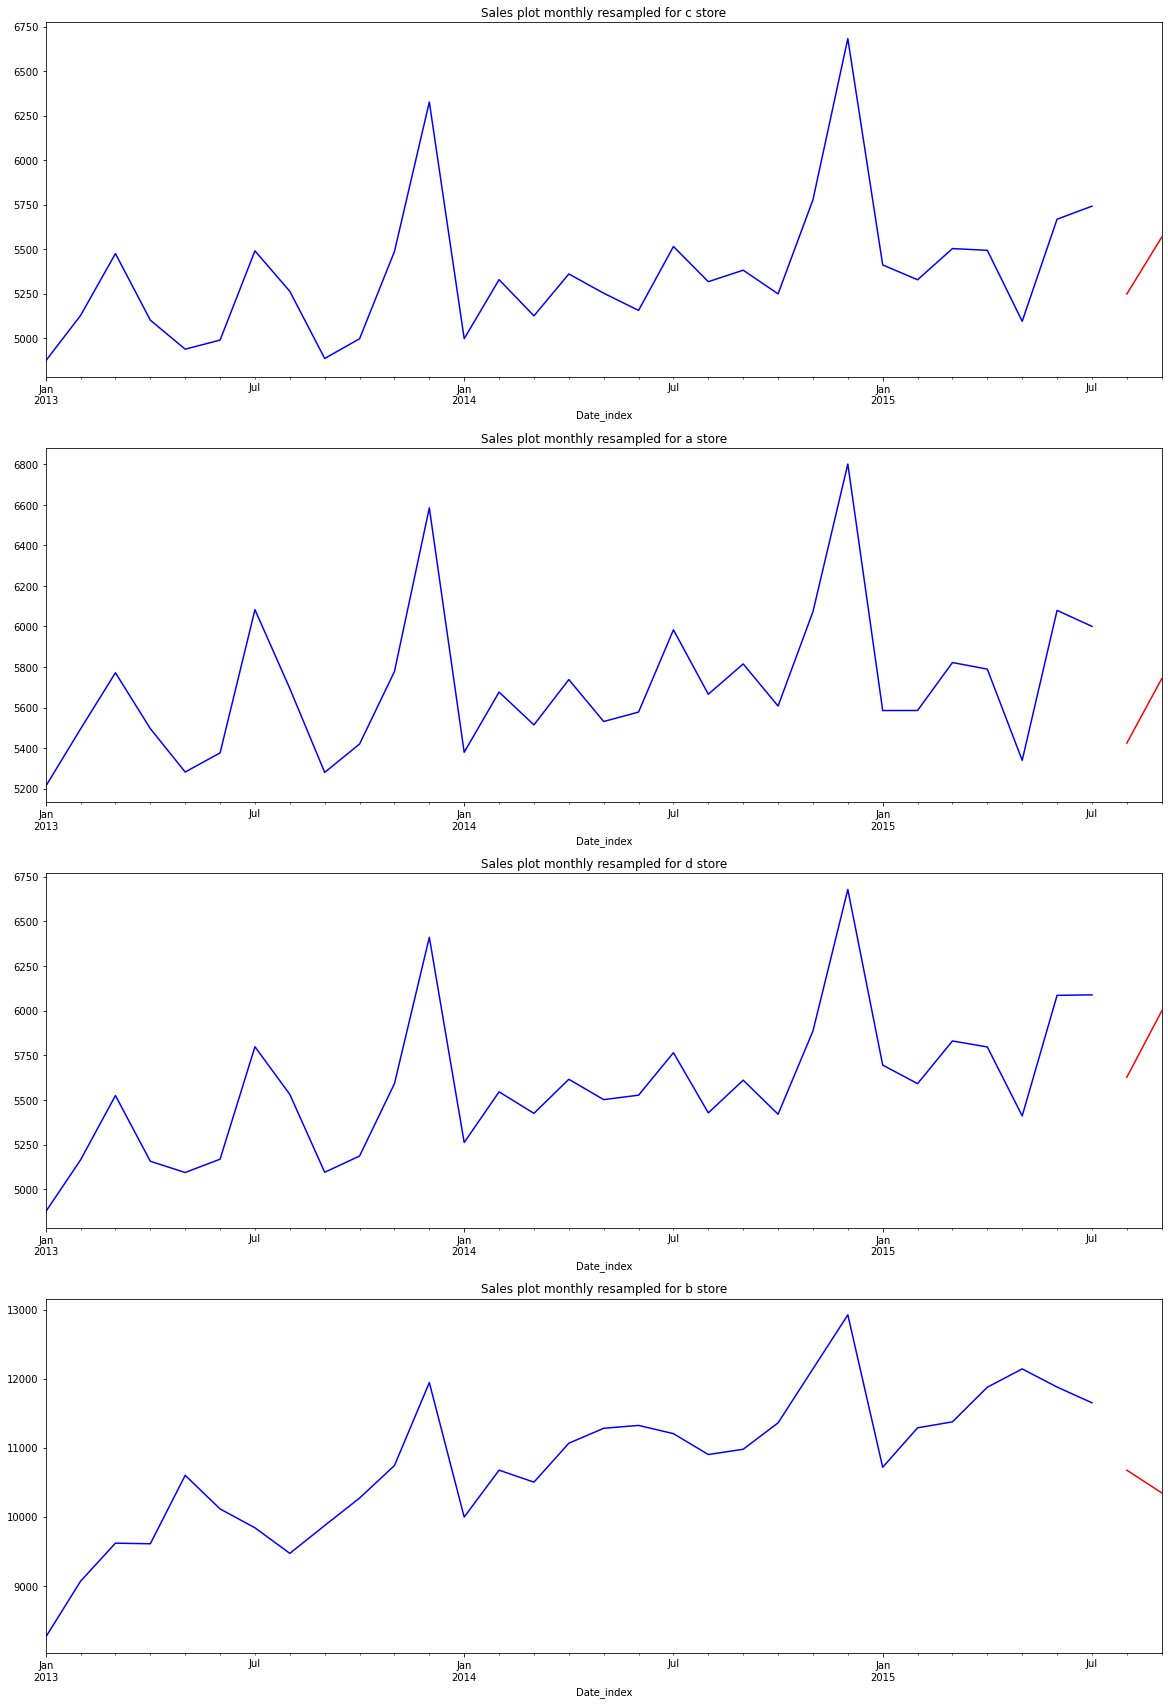

In [204]:
fig, axs = plt.subplots(nrows=all_data.StoreType.nunique(), ncols=1, figsize=(20, 30))

for idx, store_type in enumerate(all_data.StoreType.unique()):
    all_data.loc[(all_data.StoreType == store_type) & (all_data.color == 'b'), :].set_index(
        'Date_index').Sales.resample('M').mean().plot(
        ax=axs[idx], title=f'Sales plot monthly resampled for {store_type} store', color='b');
    
    all_data.loc[(all_data.StoreType == store_type) & (all_data.color == 'r'), :].set_index(
        'Date_index').Sales.resample('M').mean().plot(
        ax=axs[idx], title=f'Sales plot monthly resampled for {store_type} store', color='r');

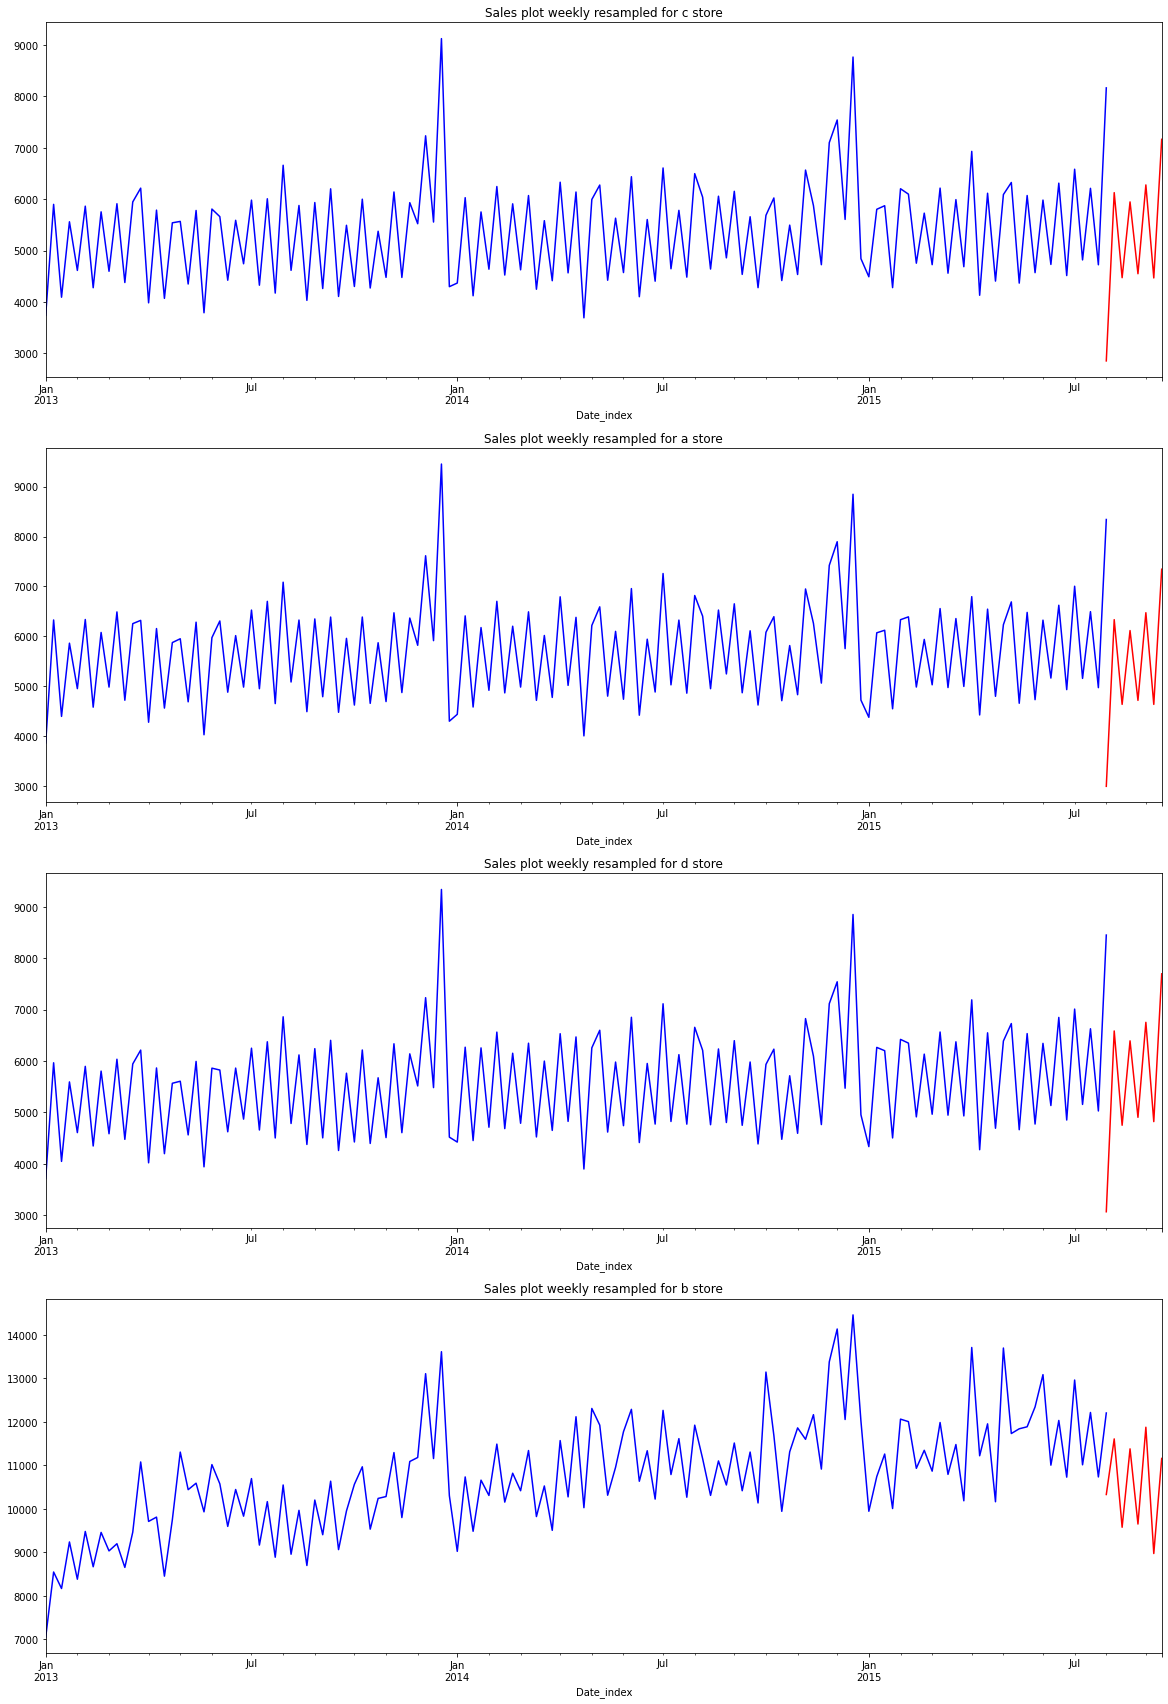

In [205]:
fig, axs = plt.subplots(nrows=all_data.StoreType.nunique(), ncols=1, figsize=(20, 30))

for idx, store_type in enumerate(all_data.StoreType.unique()):
    all_data.loc[(all_data.StoreType == store_type) & (all_data.color == 'b'), :].set_index(
        'Date_index').Sales.resample('W').mean().plot(
        ax=axs[idx], title=f'Sales plot weekly resampled for {store_type} store', color='b');
    
    all_data.loc[(all_data.StoreType == store_type) & (all_data.color == 'r'), :].set_index(
        'Date_index').Sales.resample('W').mean().plot(
        ax=axs[idx], title=f'Sales plot weekly resampled for {store_type} store', color='r');